In [1]:
import pandas as pd
import os
import seaborn as sn
import matplotlib as mpl
from tqdm import tqdm

sn.set_theme()
mpl.rcParams['figure.dpi'] = 300
sn.set_style("whitegrid")
import numpy as np
from matplotlib import pyplot as plt
from Bio.pairwise2 import format_alignment
from Bio import pairwise2

anno = pd.read_csv('scraped_annotations.csv')
binding_db = pd.read_csv('binding_db.csv')

C:\Users\HannesStark\anaconda3\envs\geom\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (10,11,13,14,15,16,17) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\HannesStark\anaconda3\envs\geom\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (7,9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [2]:
def realign(preds, truth, dist=2):
    # Produce different shifts for the `preds` array
    pad_preds = np.pad(preds, [(dist, dist)])
    shift_preds = []
    shift_array = np.concatenate([np.arange(-dist, 0), np.arange(1, dist + 1)])
    for ii in shift_array:
        this_preds = np.pad(pad_preds.copy(), [(0, 1)])
        shift_preds.append(this_preds[dist - ii:-dist - ii - 1] * truth)

    # Shift the `preds` array according to the maximum intersection with the truth
    EPS = 1e-8
    eps = np.zeros_like(shift_preds[0]) + EPS
    shift_preds = np.stack([eps] + shift_preds, axis=0)
    shift_idx = np.argmax(shift_preds, axis=0)
    shift_idx[shift_idx == 0] = -1
    shift_preds = np.concatenate([shift_preds, preds.reshape(1, *preds.shape)], axis=0)
    preds2 = shift_preds[shift_idx, np.arange(shift_preds.shape[1])]

    # Find the values that were shifted, and replace them by ~0
    shift_factor = np.array([shift_array[idx - 1] if idx >= 0 else 0 for idx in shift_idx])
    was_shifted = -shift_factor + np.arange(len(shift_factor))
    was_shifted = was_shifted[shift_factor != 0]
    preds2[was_shifted] = EPS

    # In case of intersection with the truth, keep the highest value to prevent bad shifts
    preds2[truth] = np.maximum(preds[truth], preds2[truth])
    return preds2


In [3]:
def binding_site_annotation(alignments_input, has_target_frame, input_sequence):
    is_binding_site = np.zeros(len(input_sequence))
    for alignment, sequence, binding_sites in list(zip(alignments_input, has_target_frame['sequence'],
                                                       has_target_frame['Binding site residues1'])):
        if alignment.score < len(input_sequence) * alignment_ratio or alignment.score < len(
                input_sequence) - misaligned_allowance: continue
        acids = []
        site_indices = []
        for site in binding_sites.split():
            acids.append(site[0])
            site_indices.append(int(site[1:]) - 1)
        reverse_indices = site_indices[::-1]
        annotated_count = 0
        to_annotate_count = 0
        target_sequence = ''
        target_sequence_annotations = ''
        annotated_sequence_annotations = ''
        annotated_sequence_annotations_manual = ''
        align_annotation_annotated_sequence = ''
        align_annotation_target = ''
        for i in range(len(is_binding_site)):
            if i in reverse_indices:
                annotated_sequence_annotations += '1'
            else:
                annotated_sequence_annotations += '0'

        for annotated, to_annotate in list(zip(alignment[1], alignment[0])):
            if len(reverse_indices) == 0: break
            is_binding_idx = False
            if reverse_indices[-1] == annotated_count and annotated != '-':
                reverse_indices.pop()
                is_binding_idx = True

            if to_annotate != '-':
                if is_binding_idx:
                    is_binding_site[to_annotate_count] = 1
                    target_sequence_annotations += '1'
                    align_annotation_target += '1'
                else:
                    target_sequence_annotations += '0'
                    align_annotation_target += '0'
                target_sequence += to_annotate
                to_annotate_count += 1
            else:
                align_annotation_target += '-'

            if annotated != '-':
                if is_binding_idx:
                    align_annotation_annotated_sequence += '1'
                    annotated_sequence_annotations_manual += '1'
                else:
                    align_annotation_annotated_sequence += '0'
                    annotated_sequence_annotations_manual += '0'
                annotated_count += 1
            else:
                align_annotation_annotated_sequence += '-'

        #print(align_annotation_target)
        #print(format_alignment(*alignment))
        #print(align_annotation_annotated_sequence)
        #print(target_sequence_annotations)
        #print(target_sequence)
        #print(sequence)
        #print(annotated_sequence_annotations)
        #print(annotated_sequence_annotations_manual)
        #print('\n')
    return is_binding_site

In [4]:
import os
import yaml
from zipfile import ZipFile

FILE_BEFORE = "metrics_before_finetune.yaml"
FILE_AFTER = "metrics.yaml"

def get_metrics_from_zipfile(path):
    with ZipFile(path) as zip:
        all_files = list(zip.namelist())
        metrics_before, metrics_after = {}, {}
        for file in tqdm(all_files):
            path = os.path.dirname(file)
            filename = os.path.basename(file)
            if filename == FILE_BEFORE:
                with zip.open(file) as file_yaml:
                    dic = yaml.load(file_yaml, Loader=yaml.FullLoader)
                metrics_before[path] = dic["best_epoch_metric_summaries"]["test"]
            elif filename == FILE_AFTER:
                with zip.open(file) as file_yaml:
                    dic = yaml.load(file_yaml, Loader=yaml.FullLoader)
                metrics_after[path] = dic["best_epoch_metric_summaries"]["test"]
    return metrics_before, metrics_after

In [5]:
output_name = 'images_1head'
if not os.path.exists(output_name):
    os.mkdir(output_name)
input_name = 'finetune_all_lr0.0001_loss-mse-heads-4'

In [6]:
metrics_before, metrics_after = get_metrics_from_zipfile(
    'binding_db_DGN_ESM_models_finetuned_finetune_all_lr0.0001_loss-mse_heads-4.zip')

100%|██████████| 17675/17675 [01:14<00:00, 238.74it/s]


In [7]:
names = os.listdir(input_name)
pearsonRs = []
for name in tqdm(names):
    try:
        pearsonRs.append(metrics_after[f'{input_name}/{name}/default/version_0']['pearsonr/test'])
    except:
        pearsonRs.append(0)


100%|██████████| 1502/1502 [00:00<00:00, 751143.99it/s]


[0.8145701885223389, 0.49462834000587463, 0.9646537899971008, 0.5731199383735657, 0.8451725840568542, 0.6022332310676575, 0.6300548315048218, 0.8434053659439087, 0.7480970025062561, 0.8445910811424255, 0.9001150727272034, 0.5694912672042847, 0.8639413714408875, 0.7347918152809143, 0.6175902485847473, 0.8591361045837402, 0.7164551615715027, 0.6473925709724426, 0.7240944504737854, 0.7104583382606506, 0.8884080648422241, 0.5878764390945435, 0.5807839035987854, 0.8389644622802734, 0.5859314203262329, 0.6814963817596436, -0.1638195961713791, 0.9048876762390137, 0.7041203379631042, 0.7455573081970215, 0.8903614282608032, 0.8864412307739258, 0.9136614799499512, 0.7103506922721863, 0.7559975385665894, 0.5934273600578308, 0.7838701605796814, 0.9248798489570618, 0.968853771686554, 0.7735518217086792, 0.7988300919532776, 0.8715358376502991, 0, 0.8826389908790588, 0, 0.9643498659133911, 0.7860217094421387, 0.897131621837616, 0.8958600163459778, 0.8556990623474121, 0.7770144939422607, 0.26456123590

0it [00:00, ?it/s]

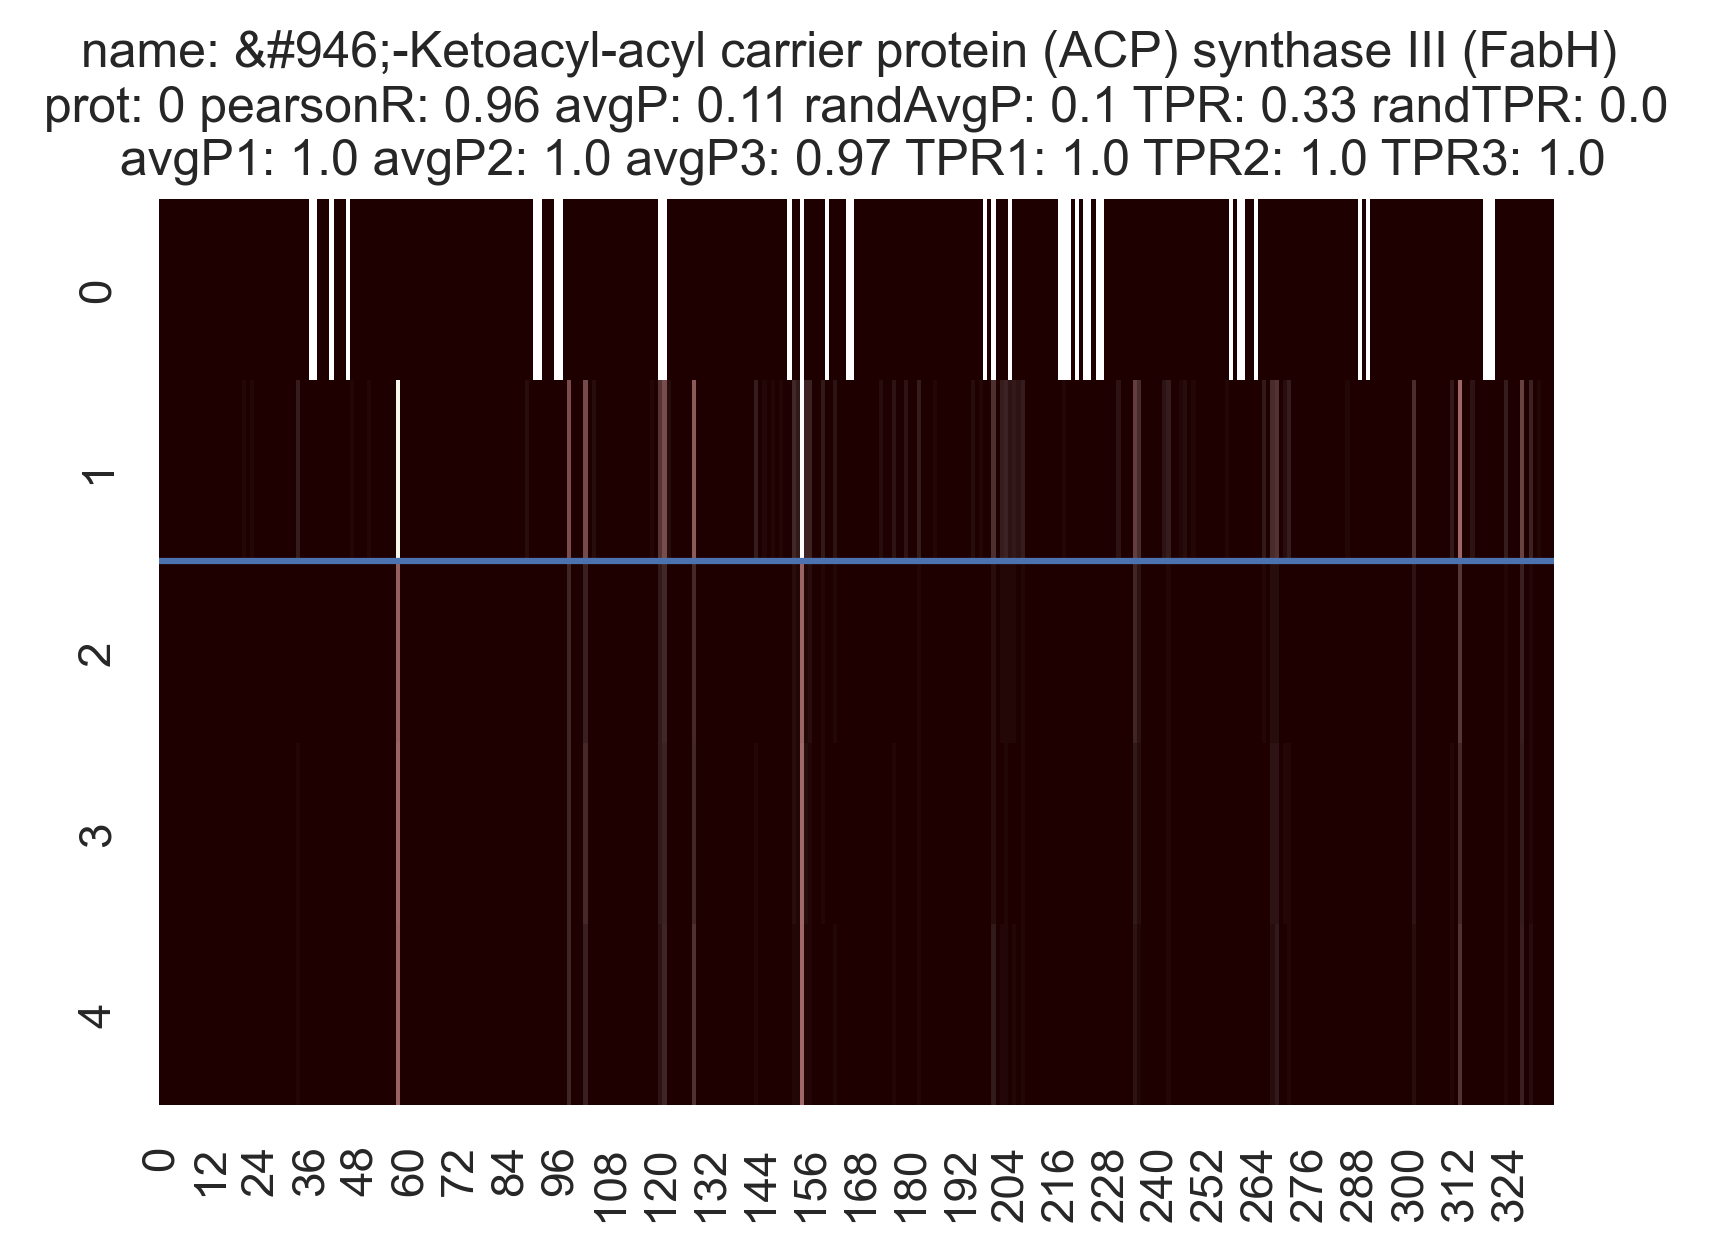

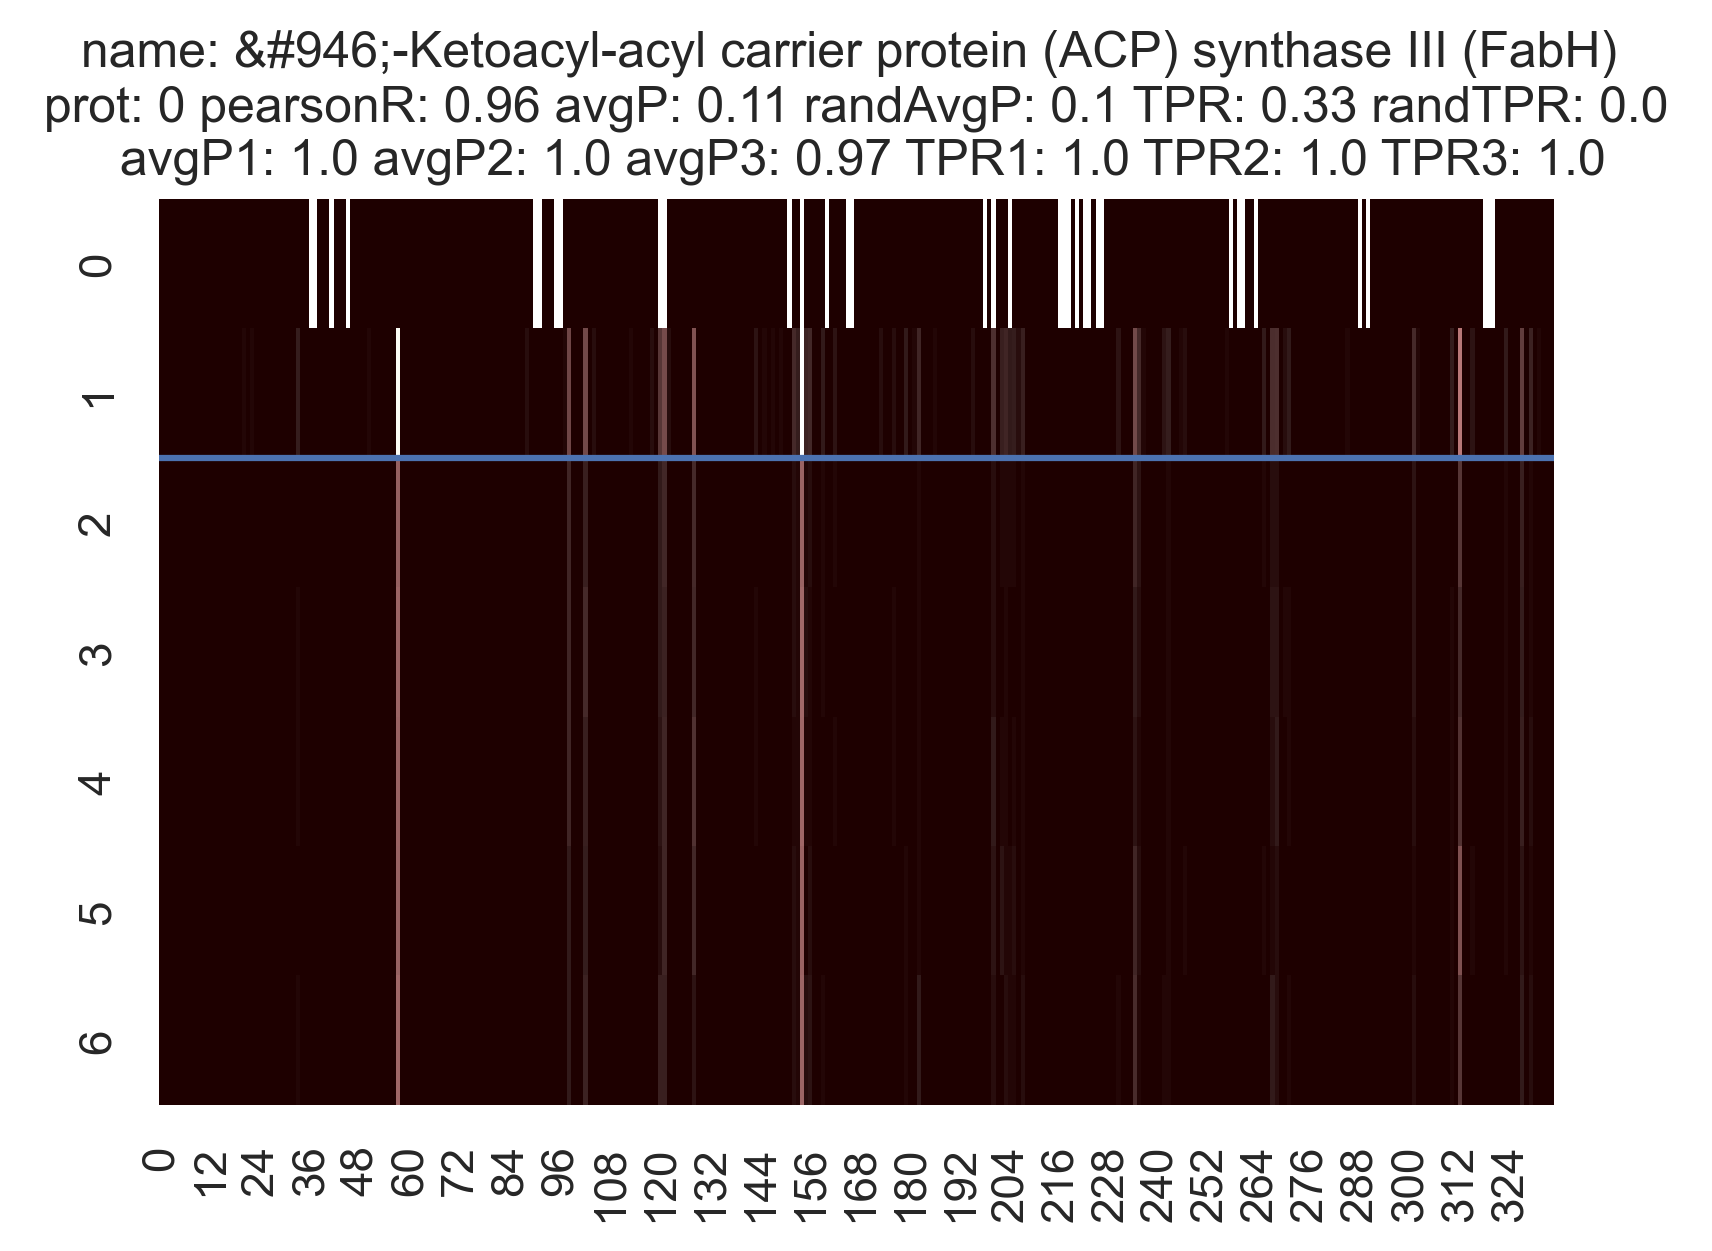

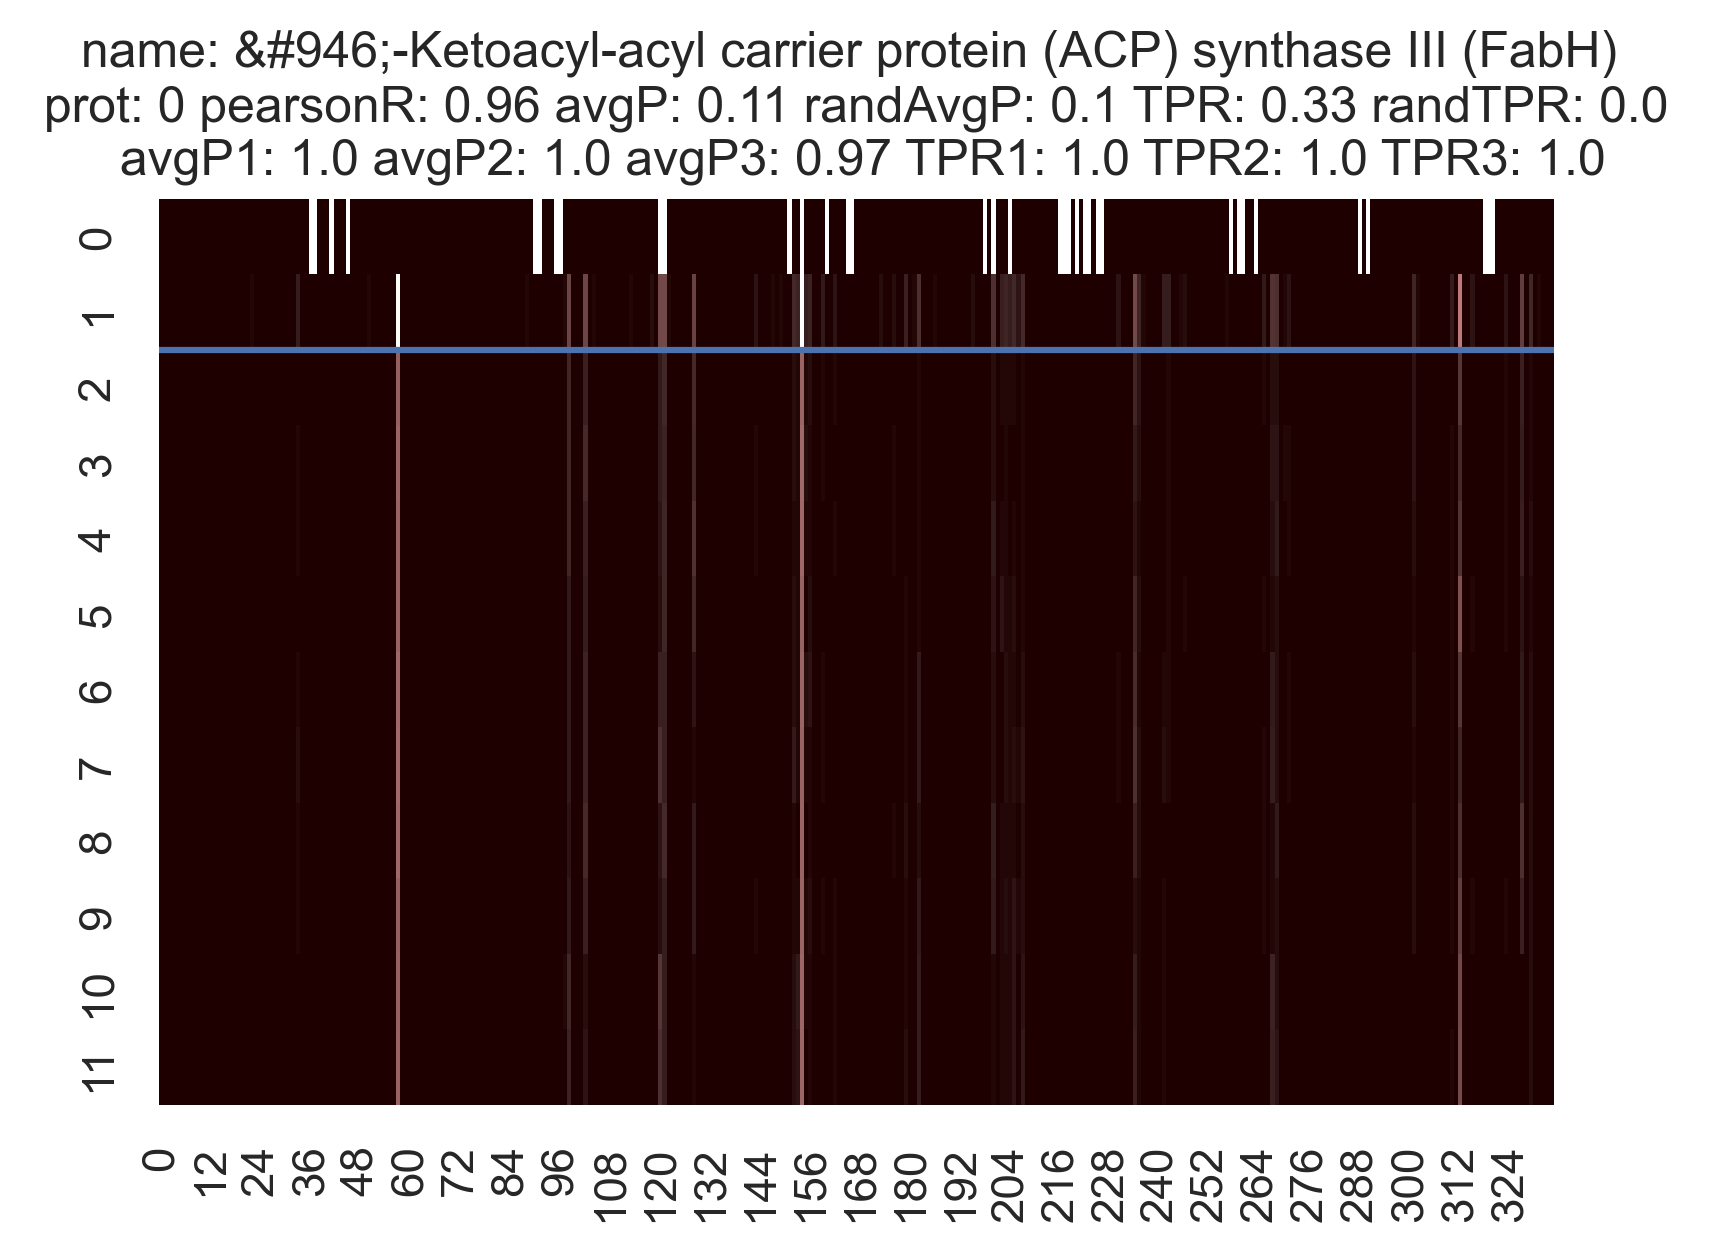

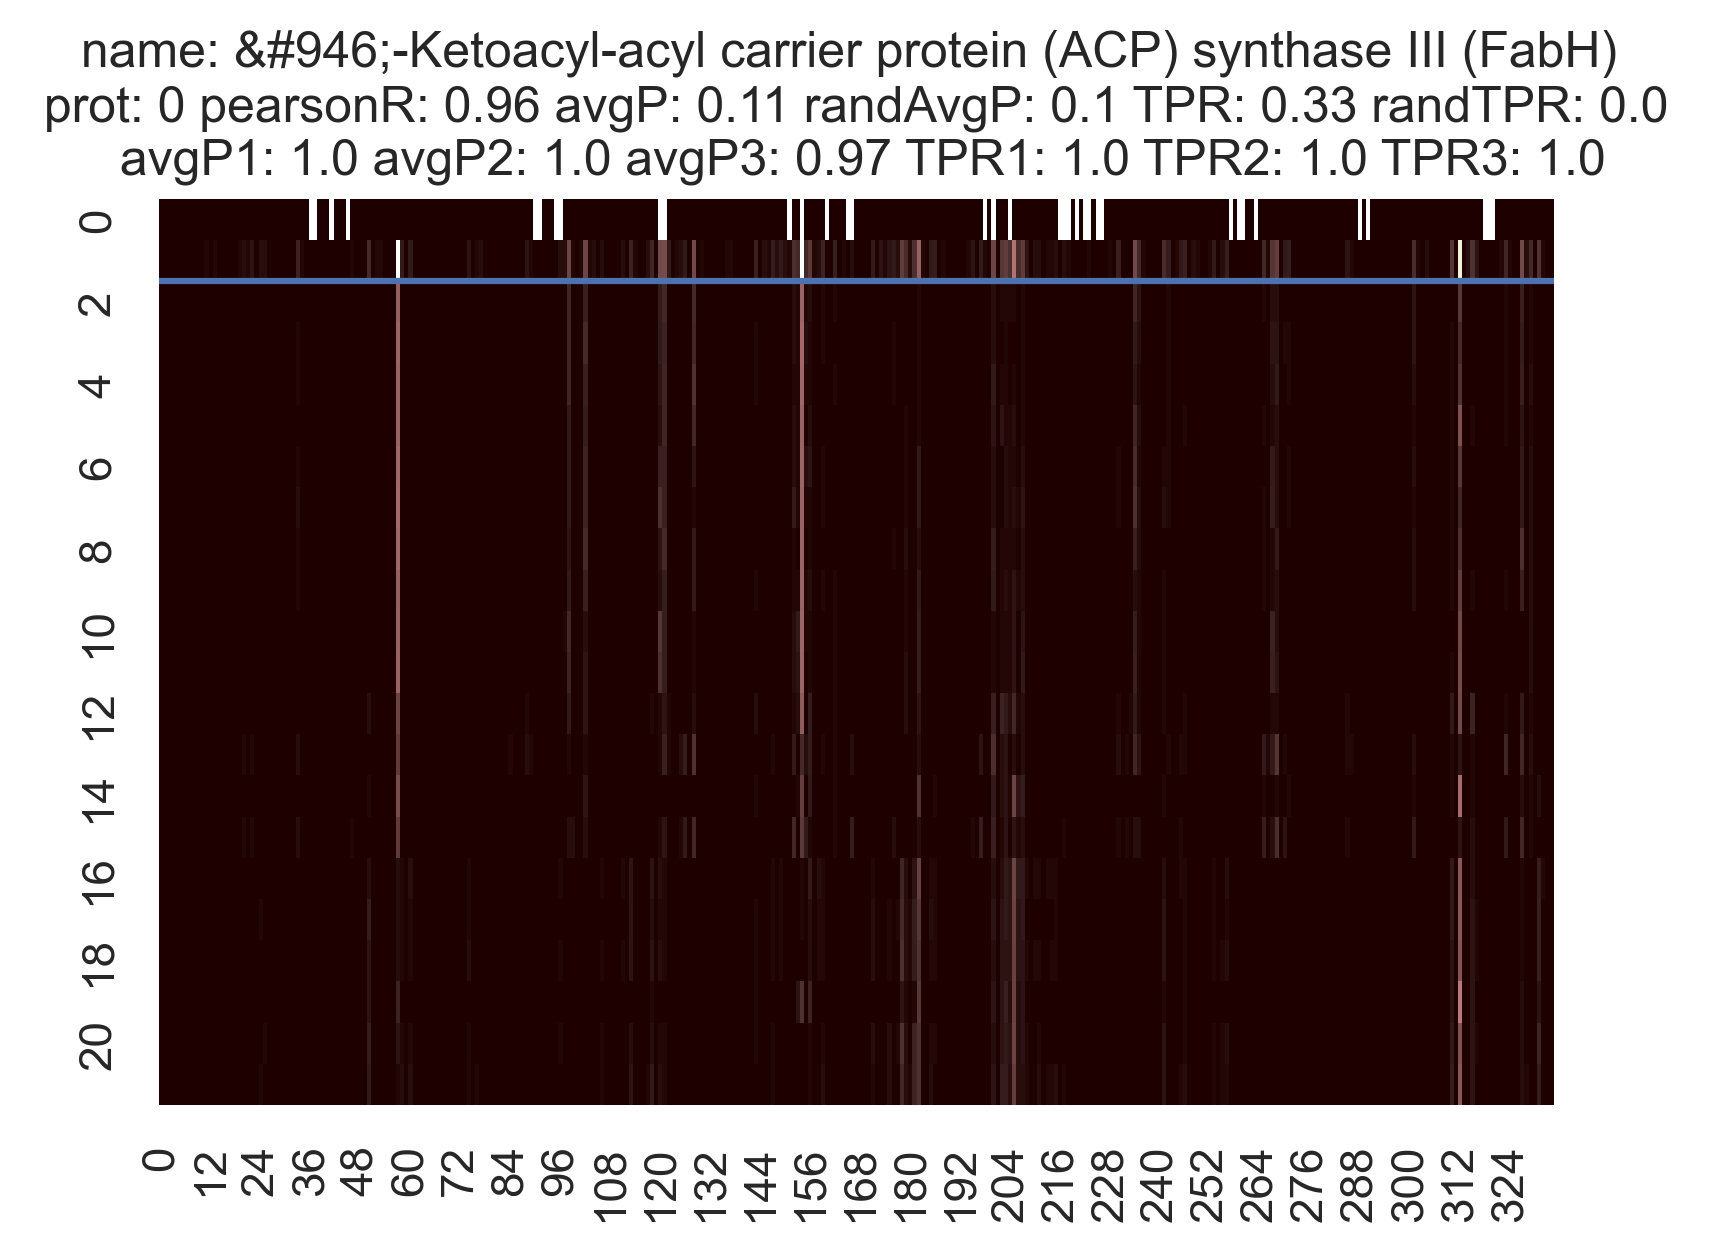

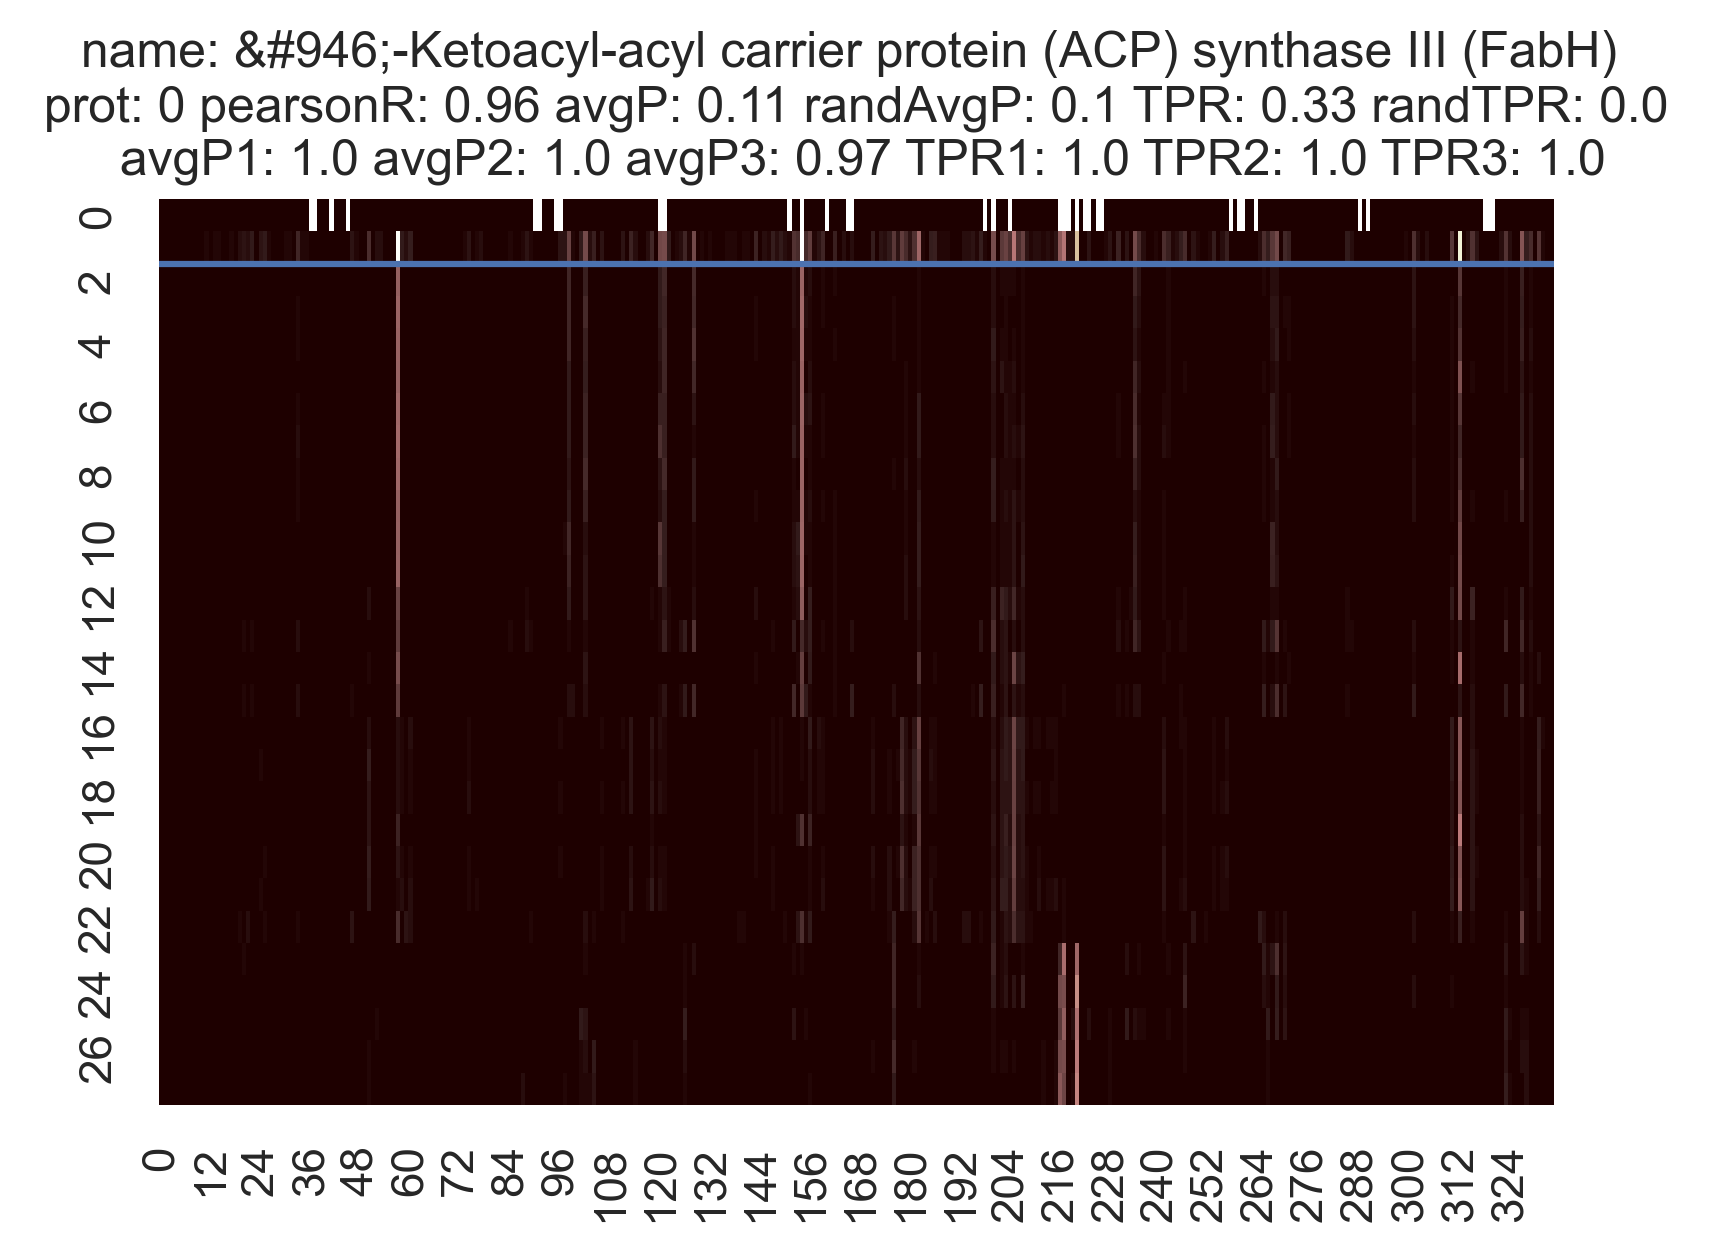

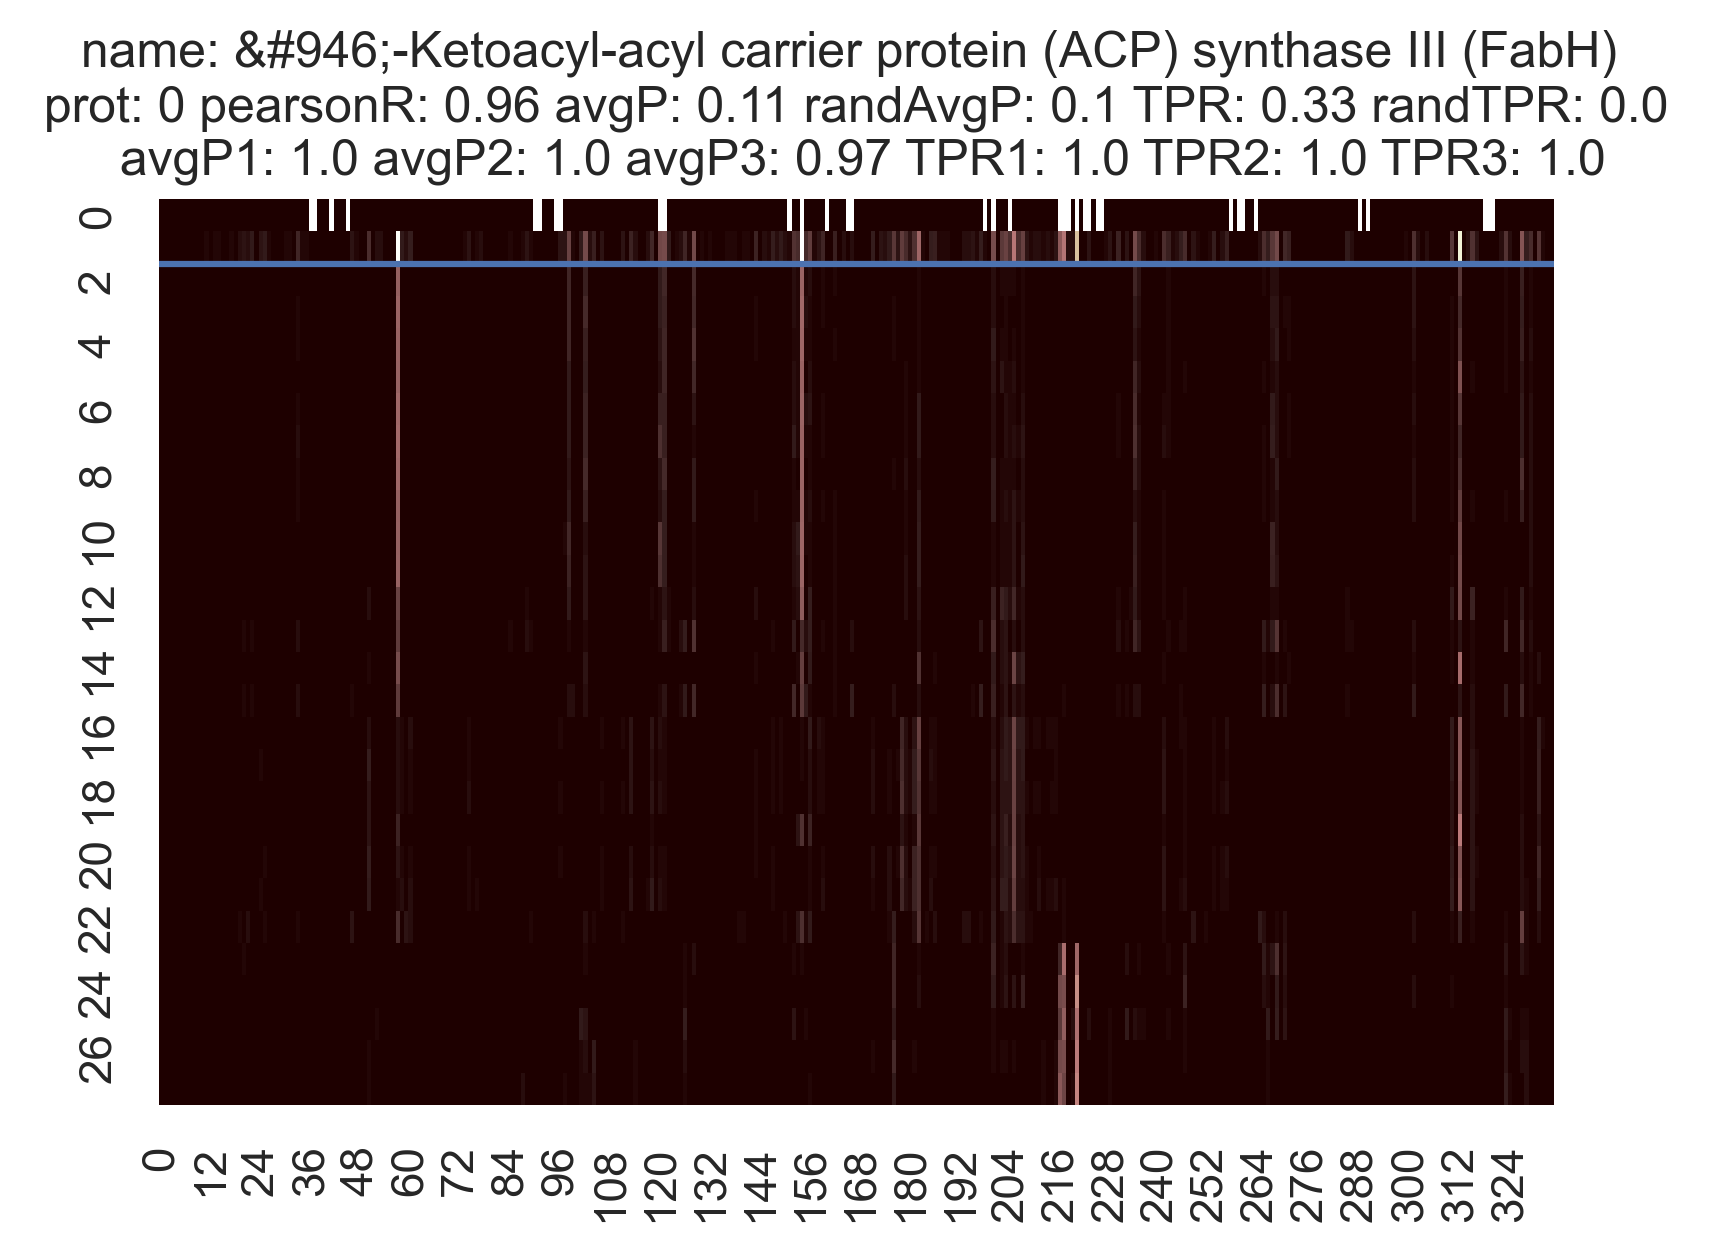

5it [00:05,  1.02s/it]

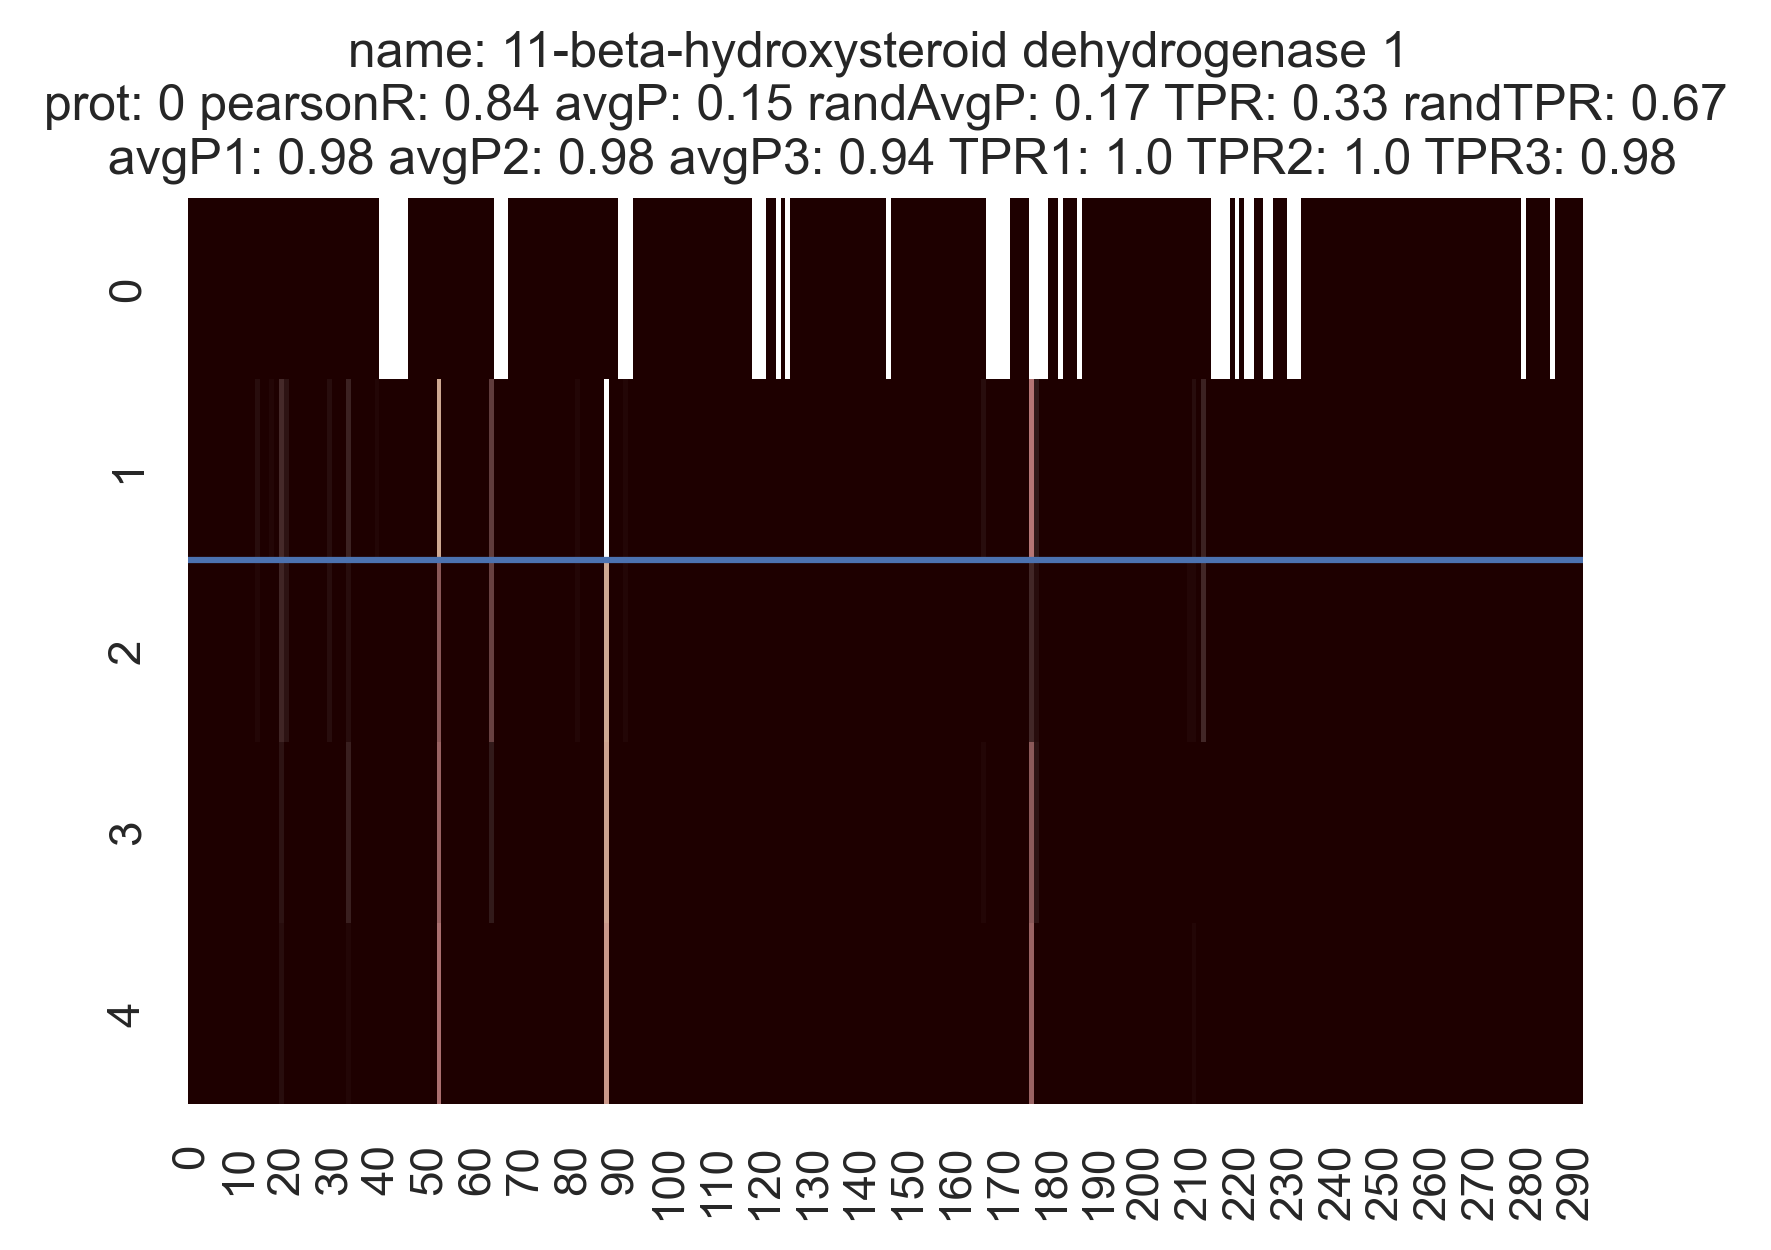

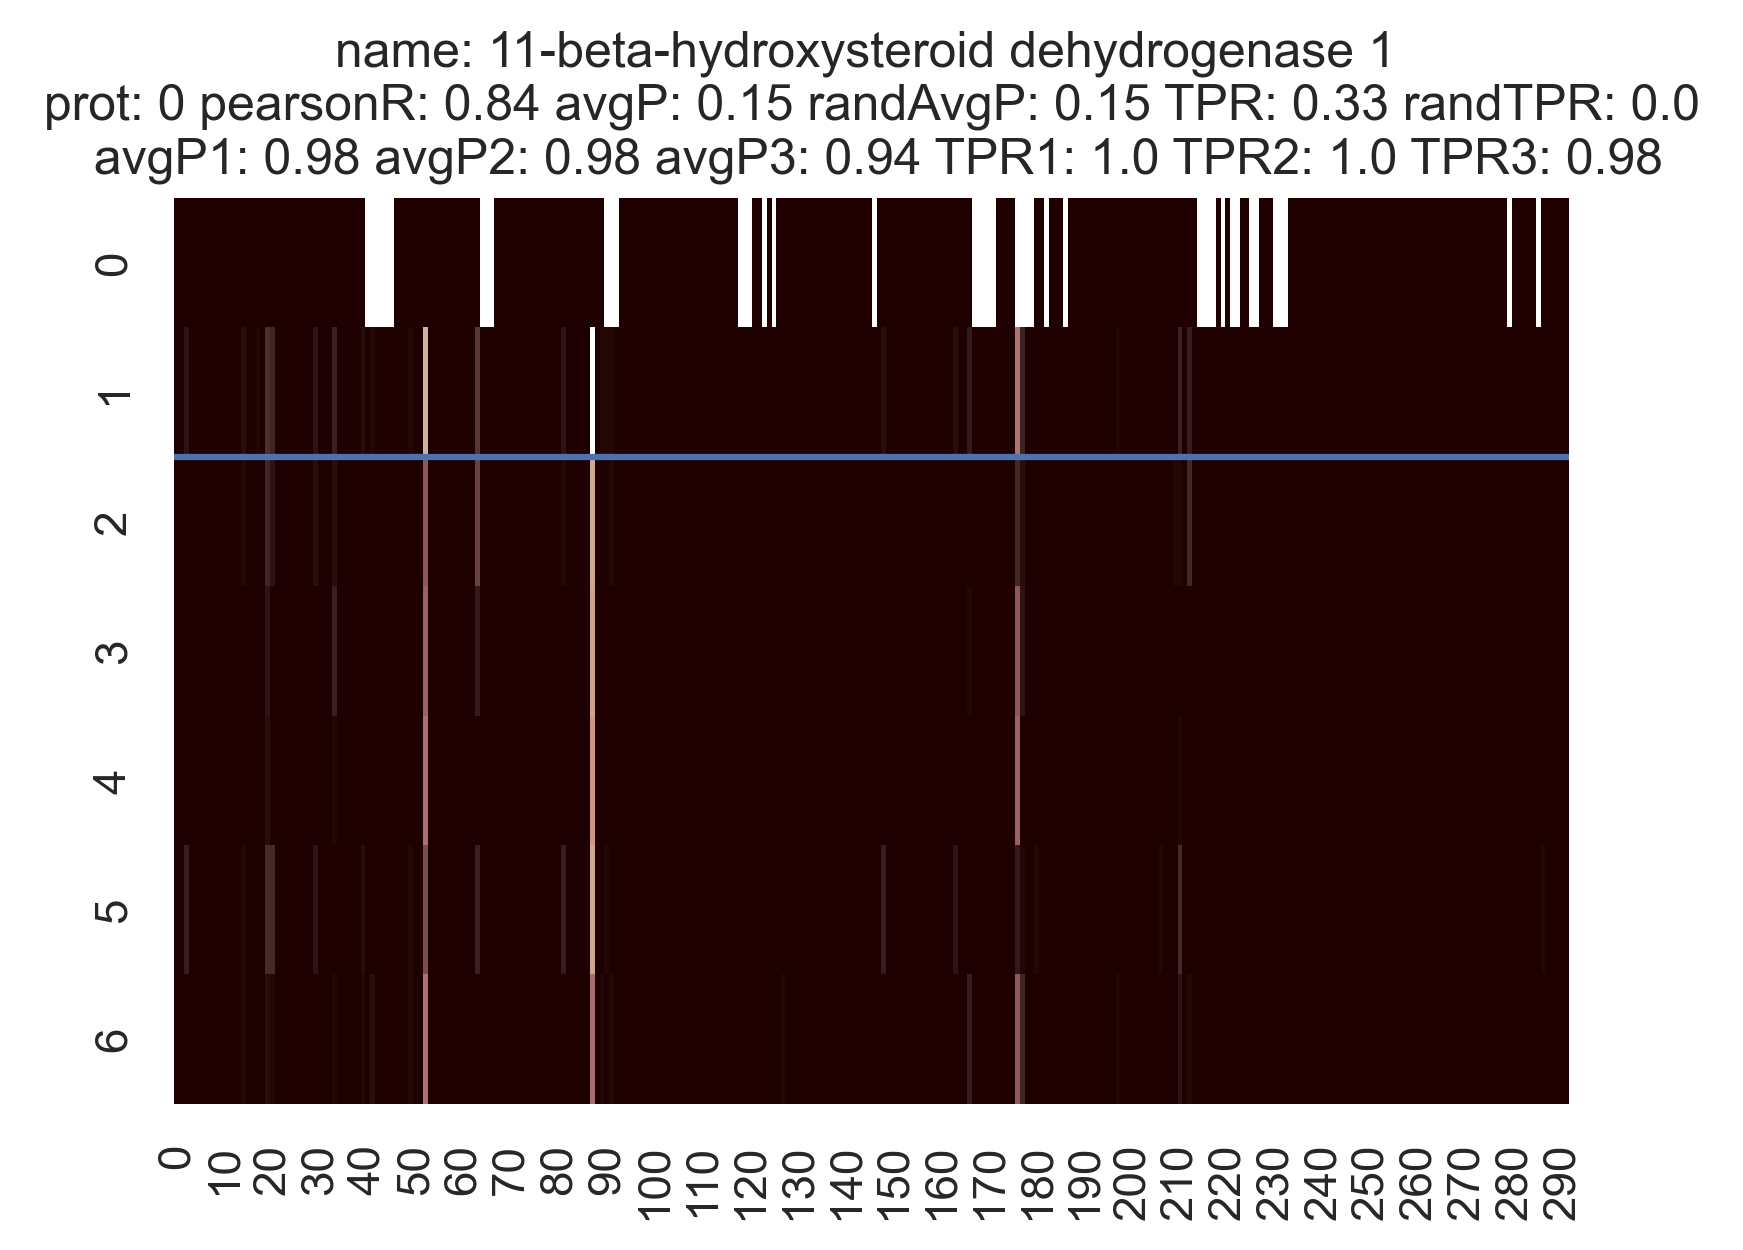

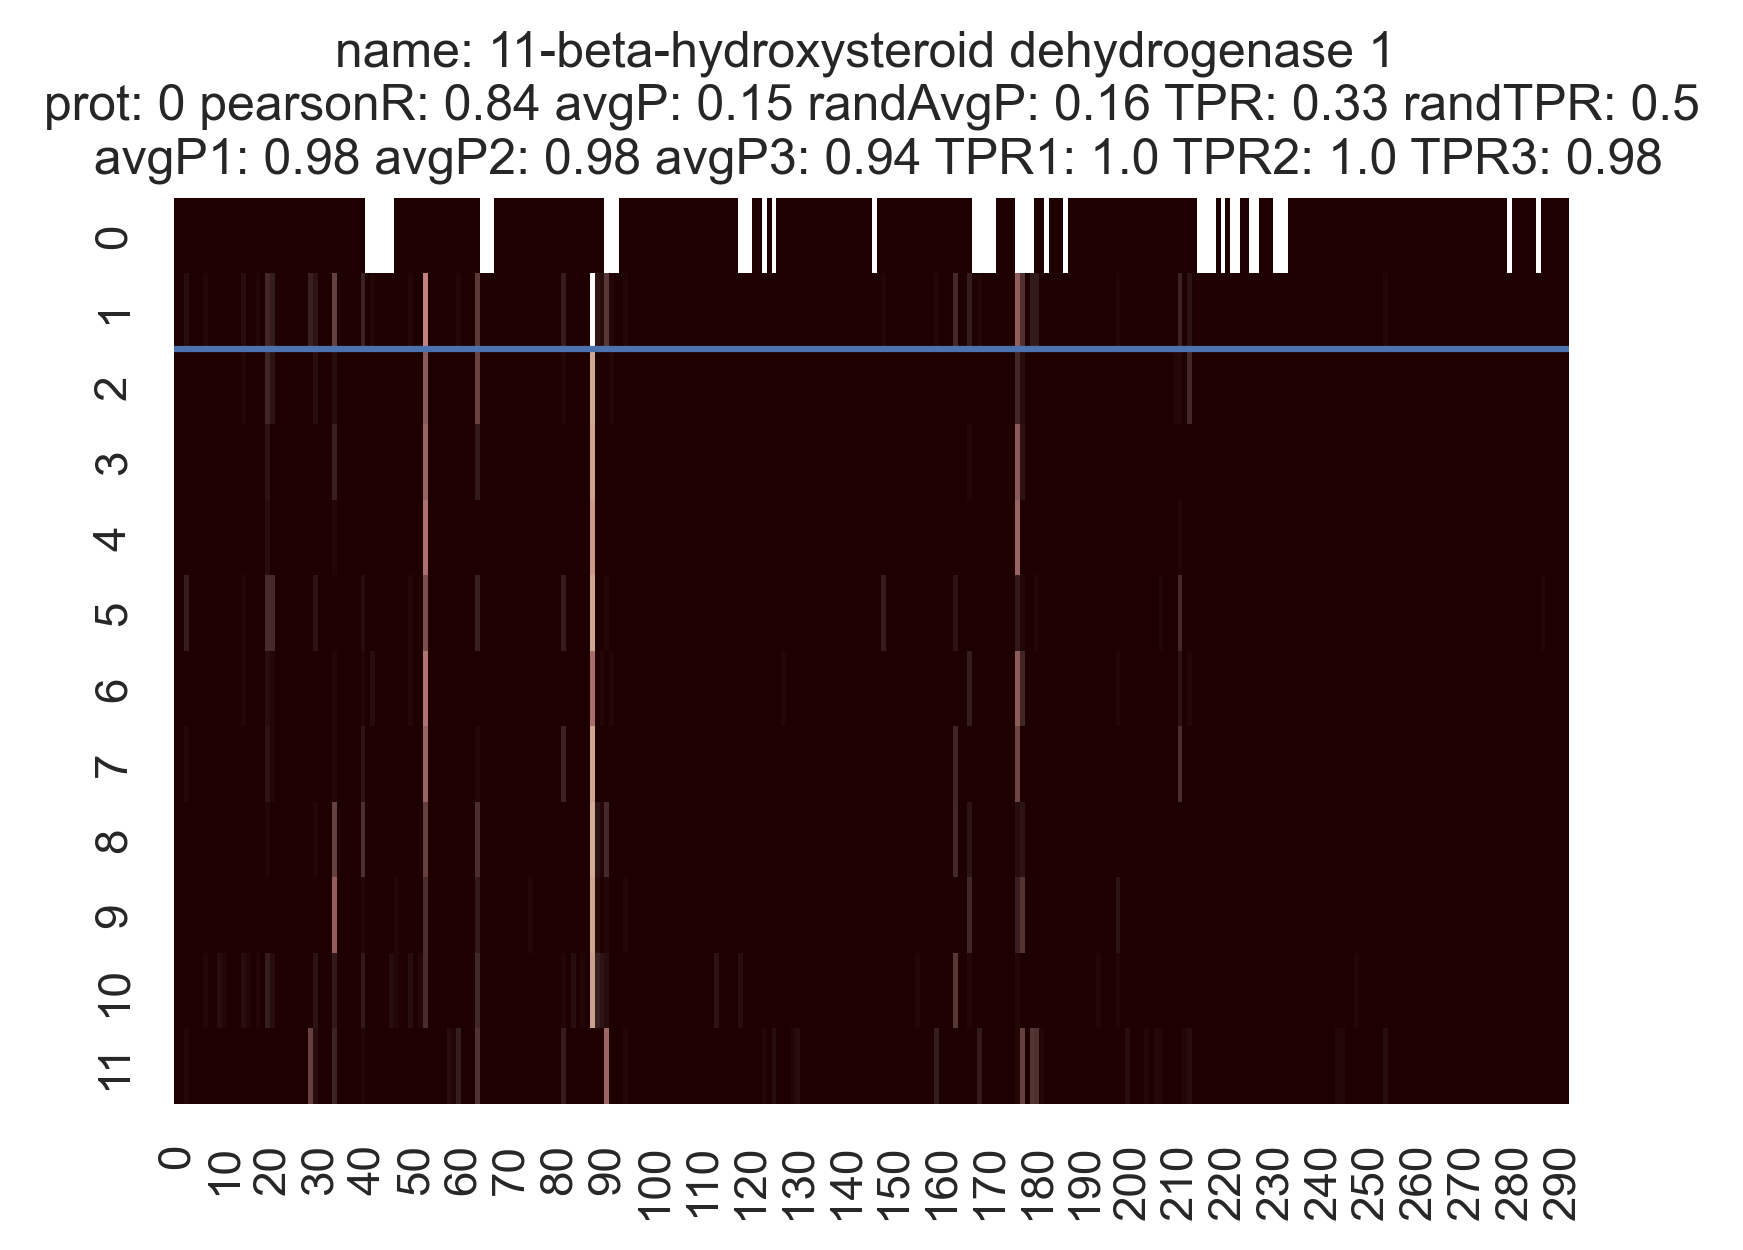

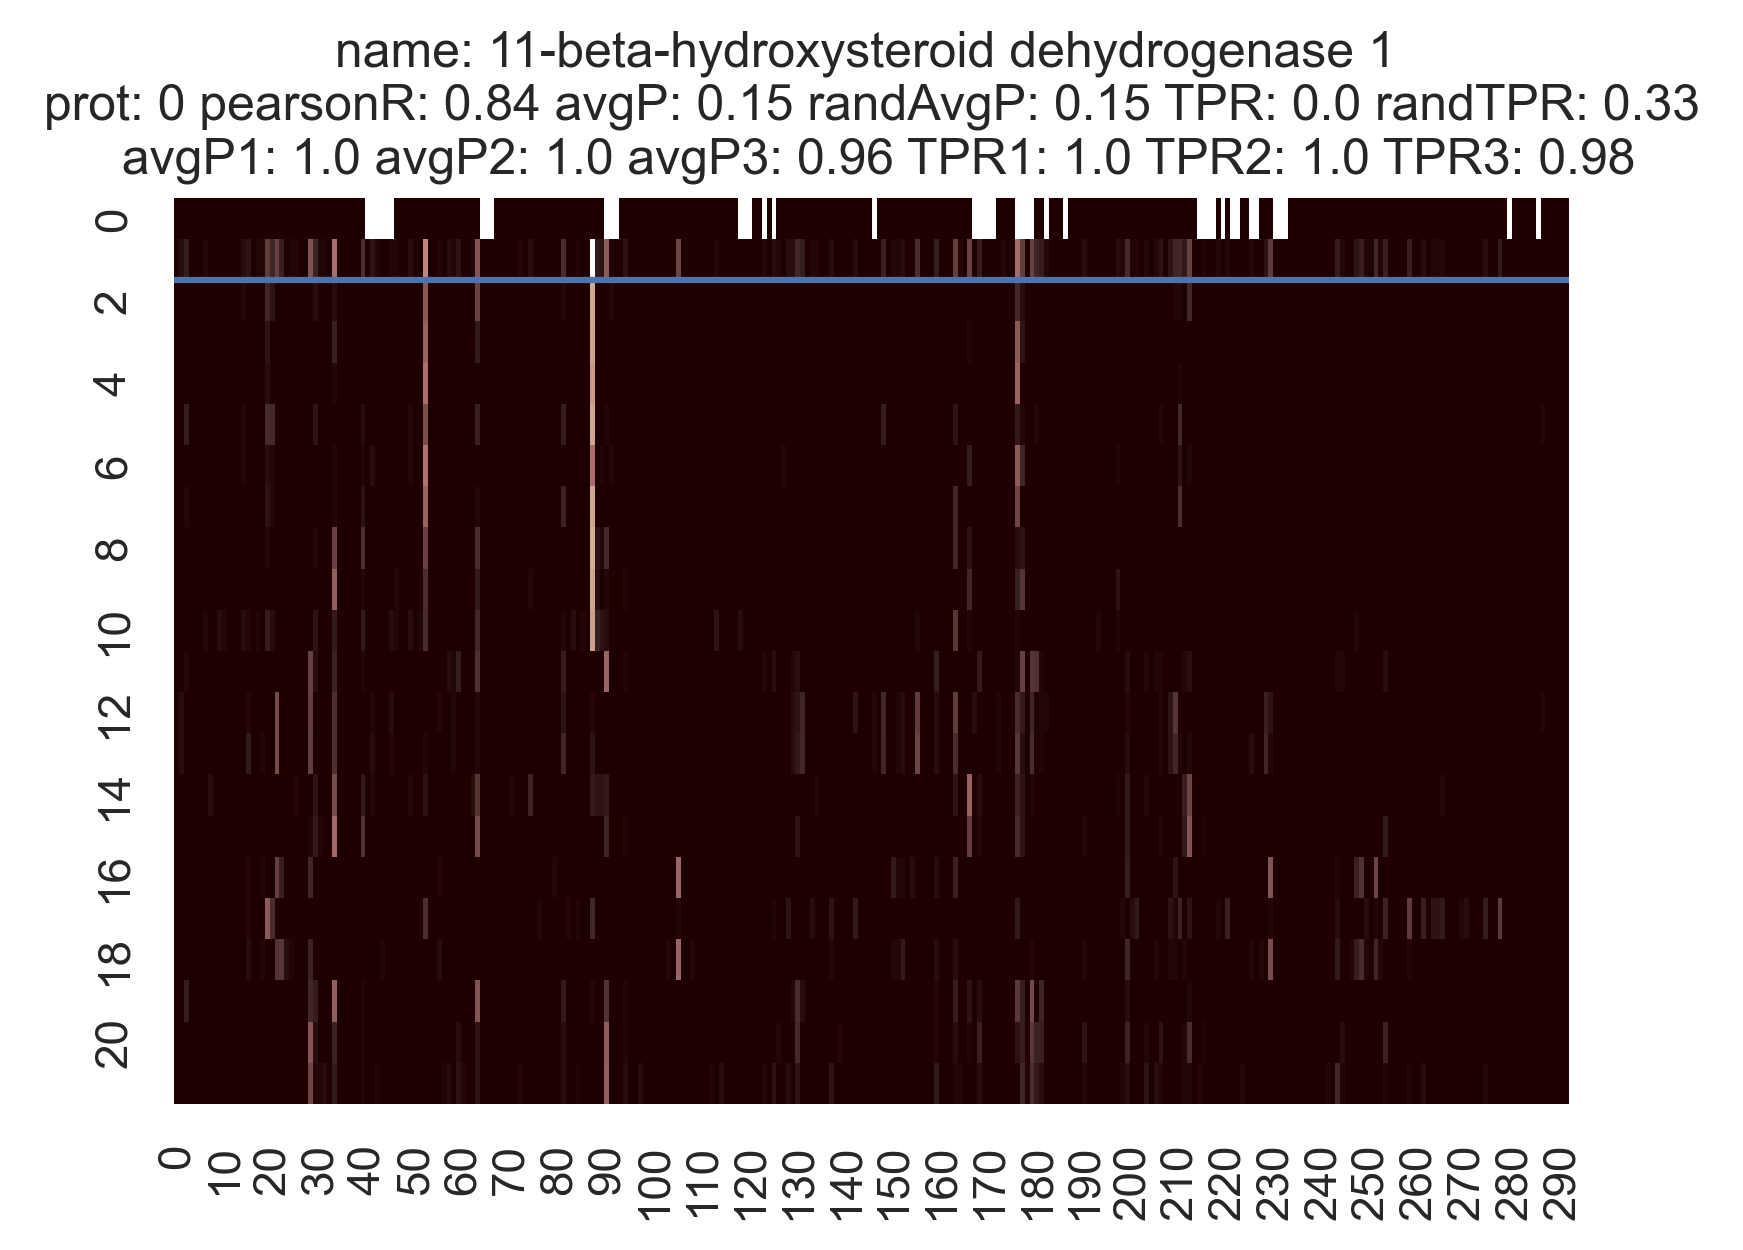

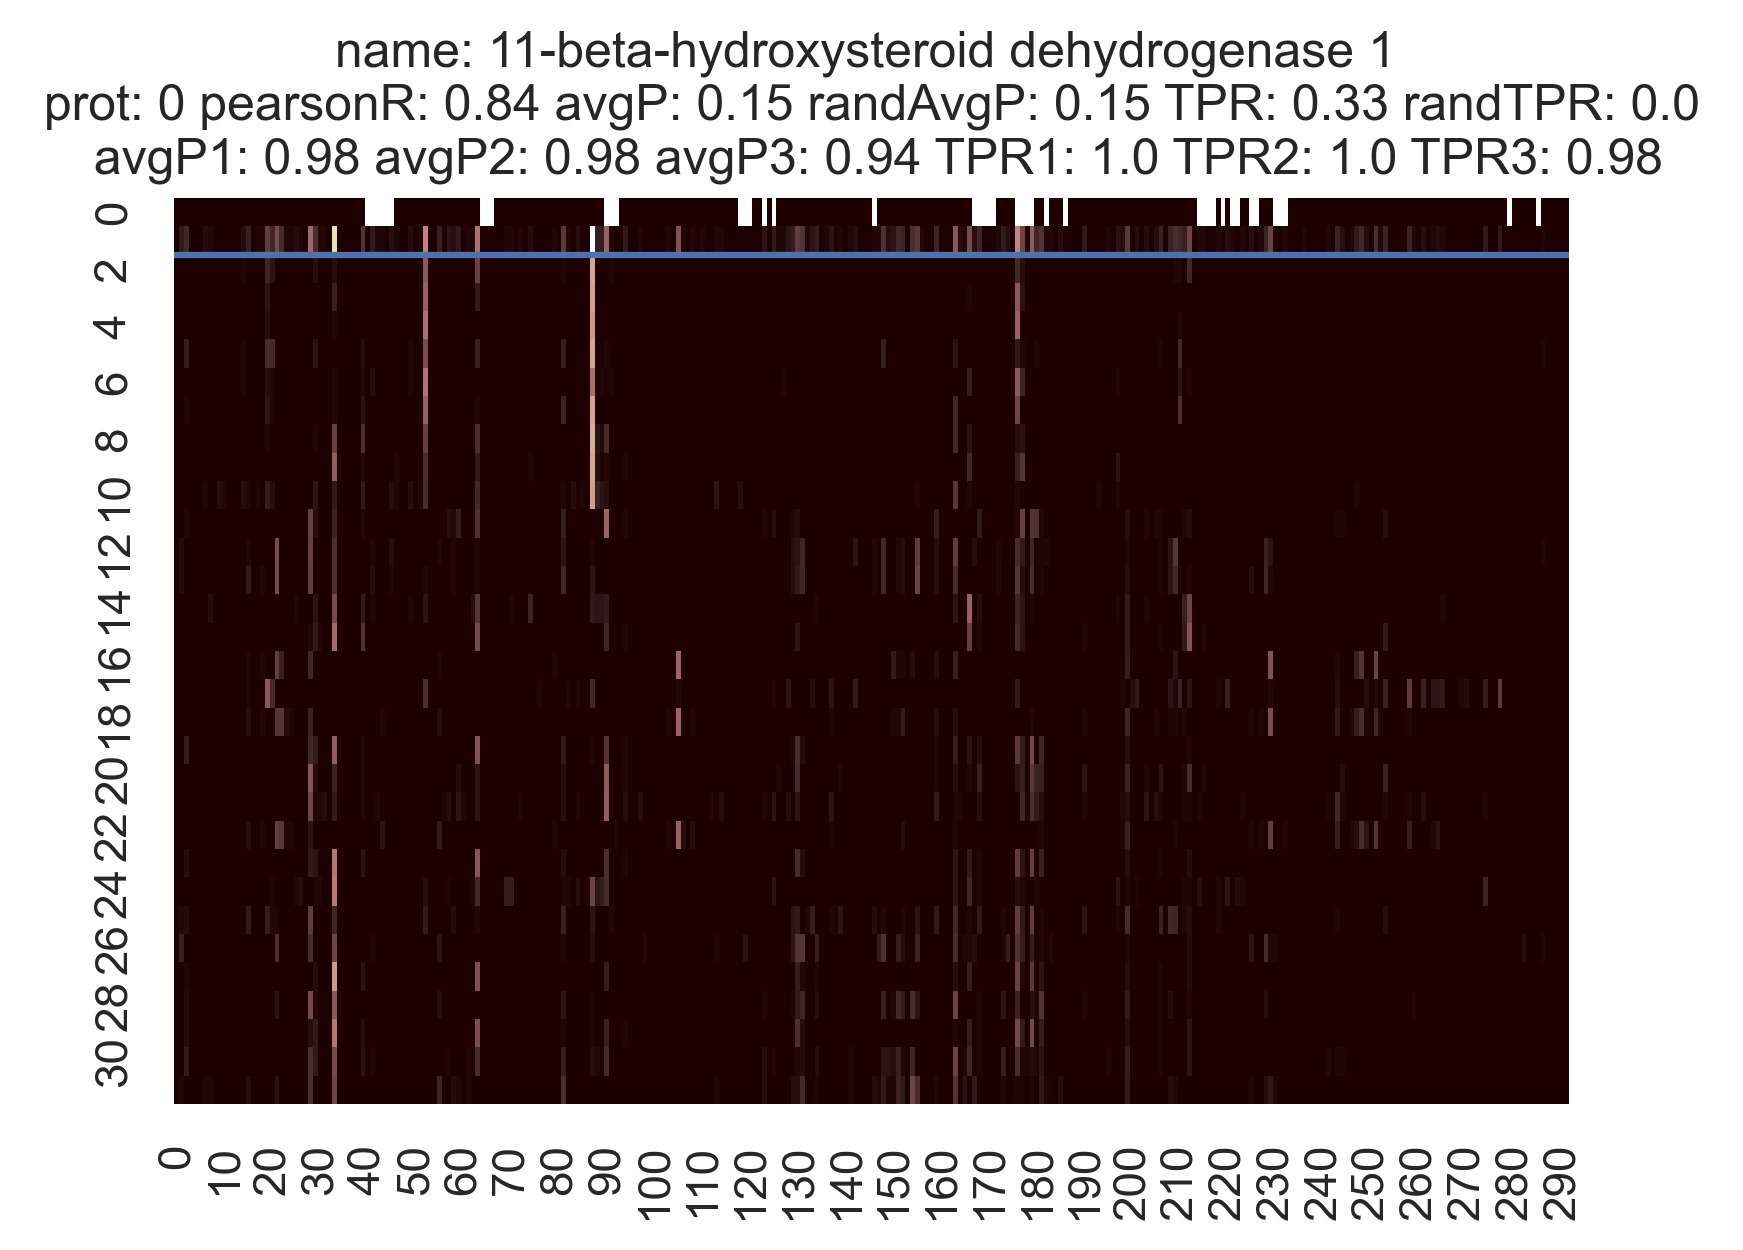

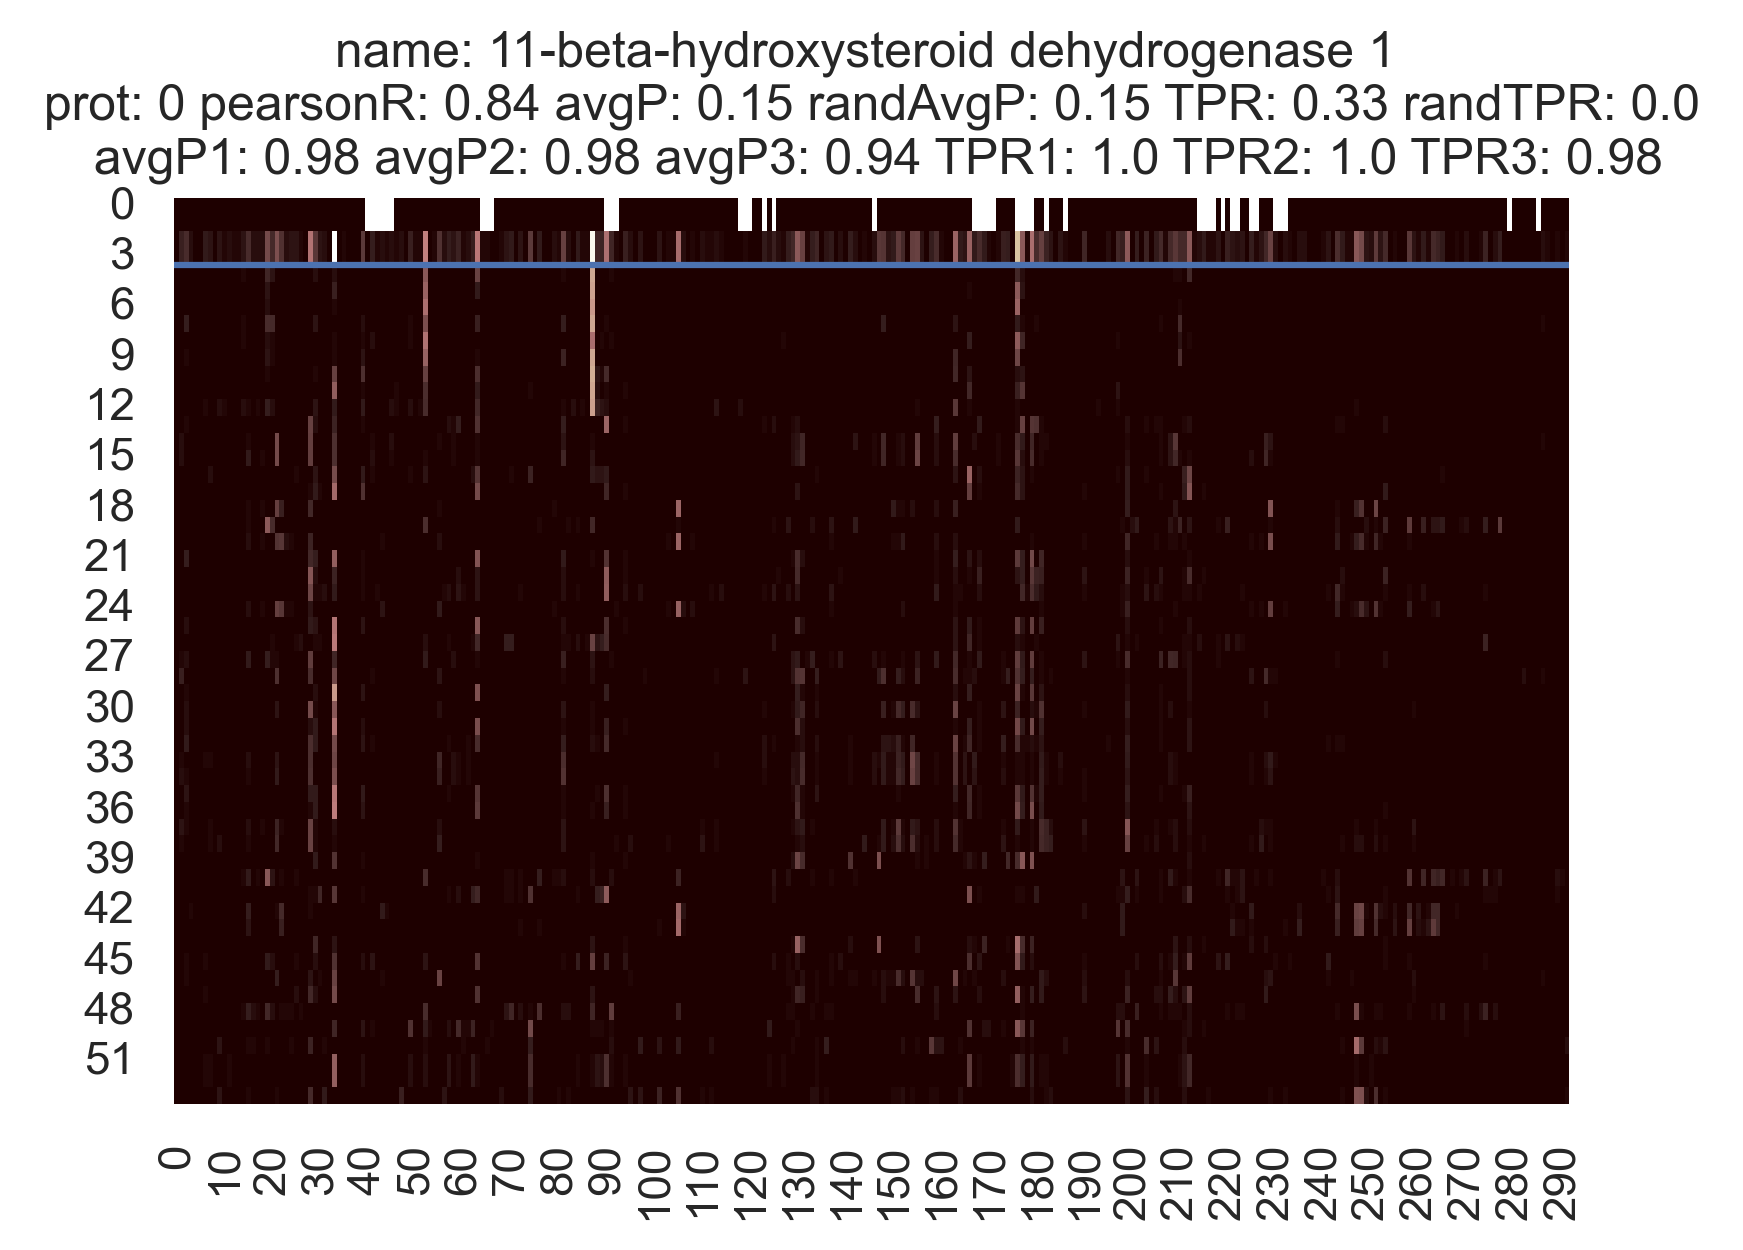

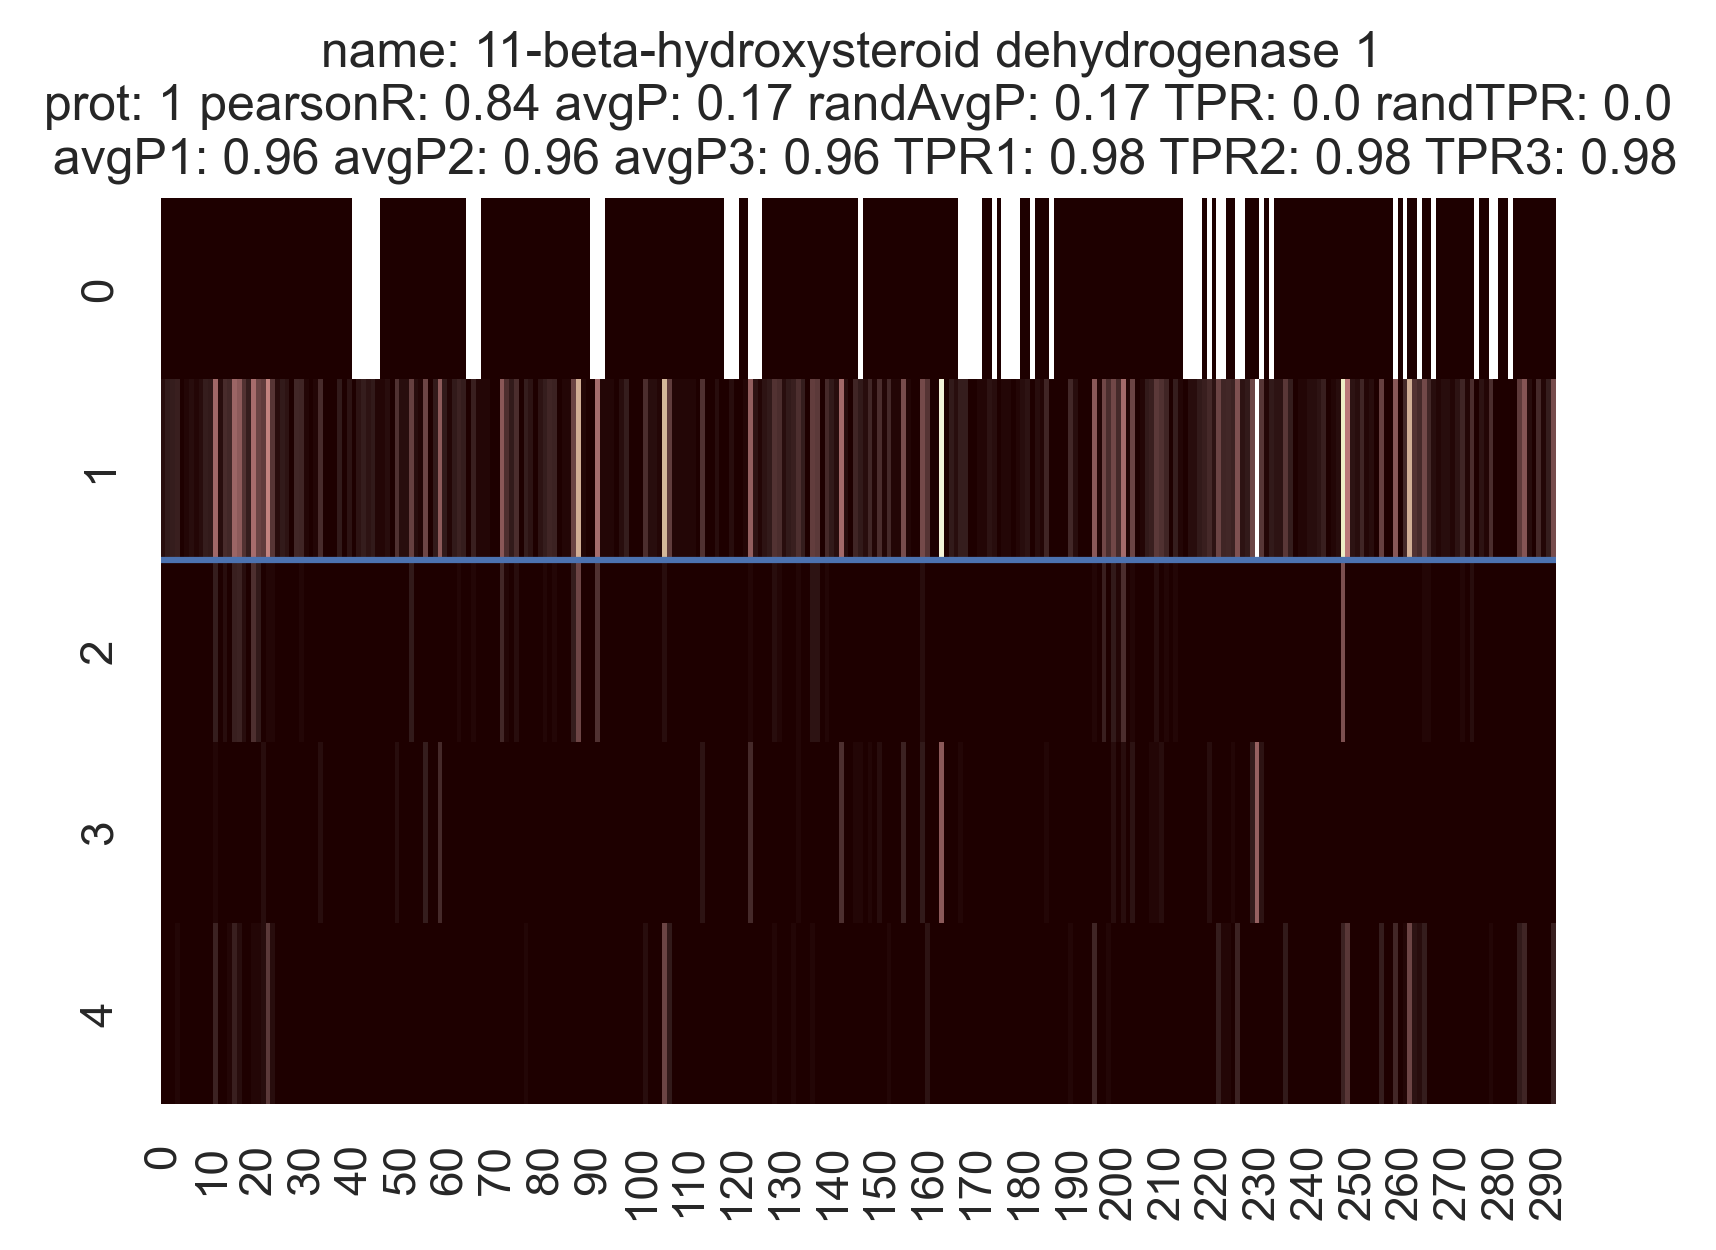

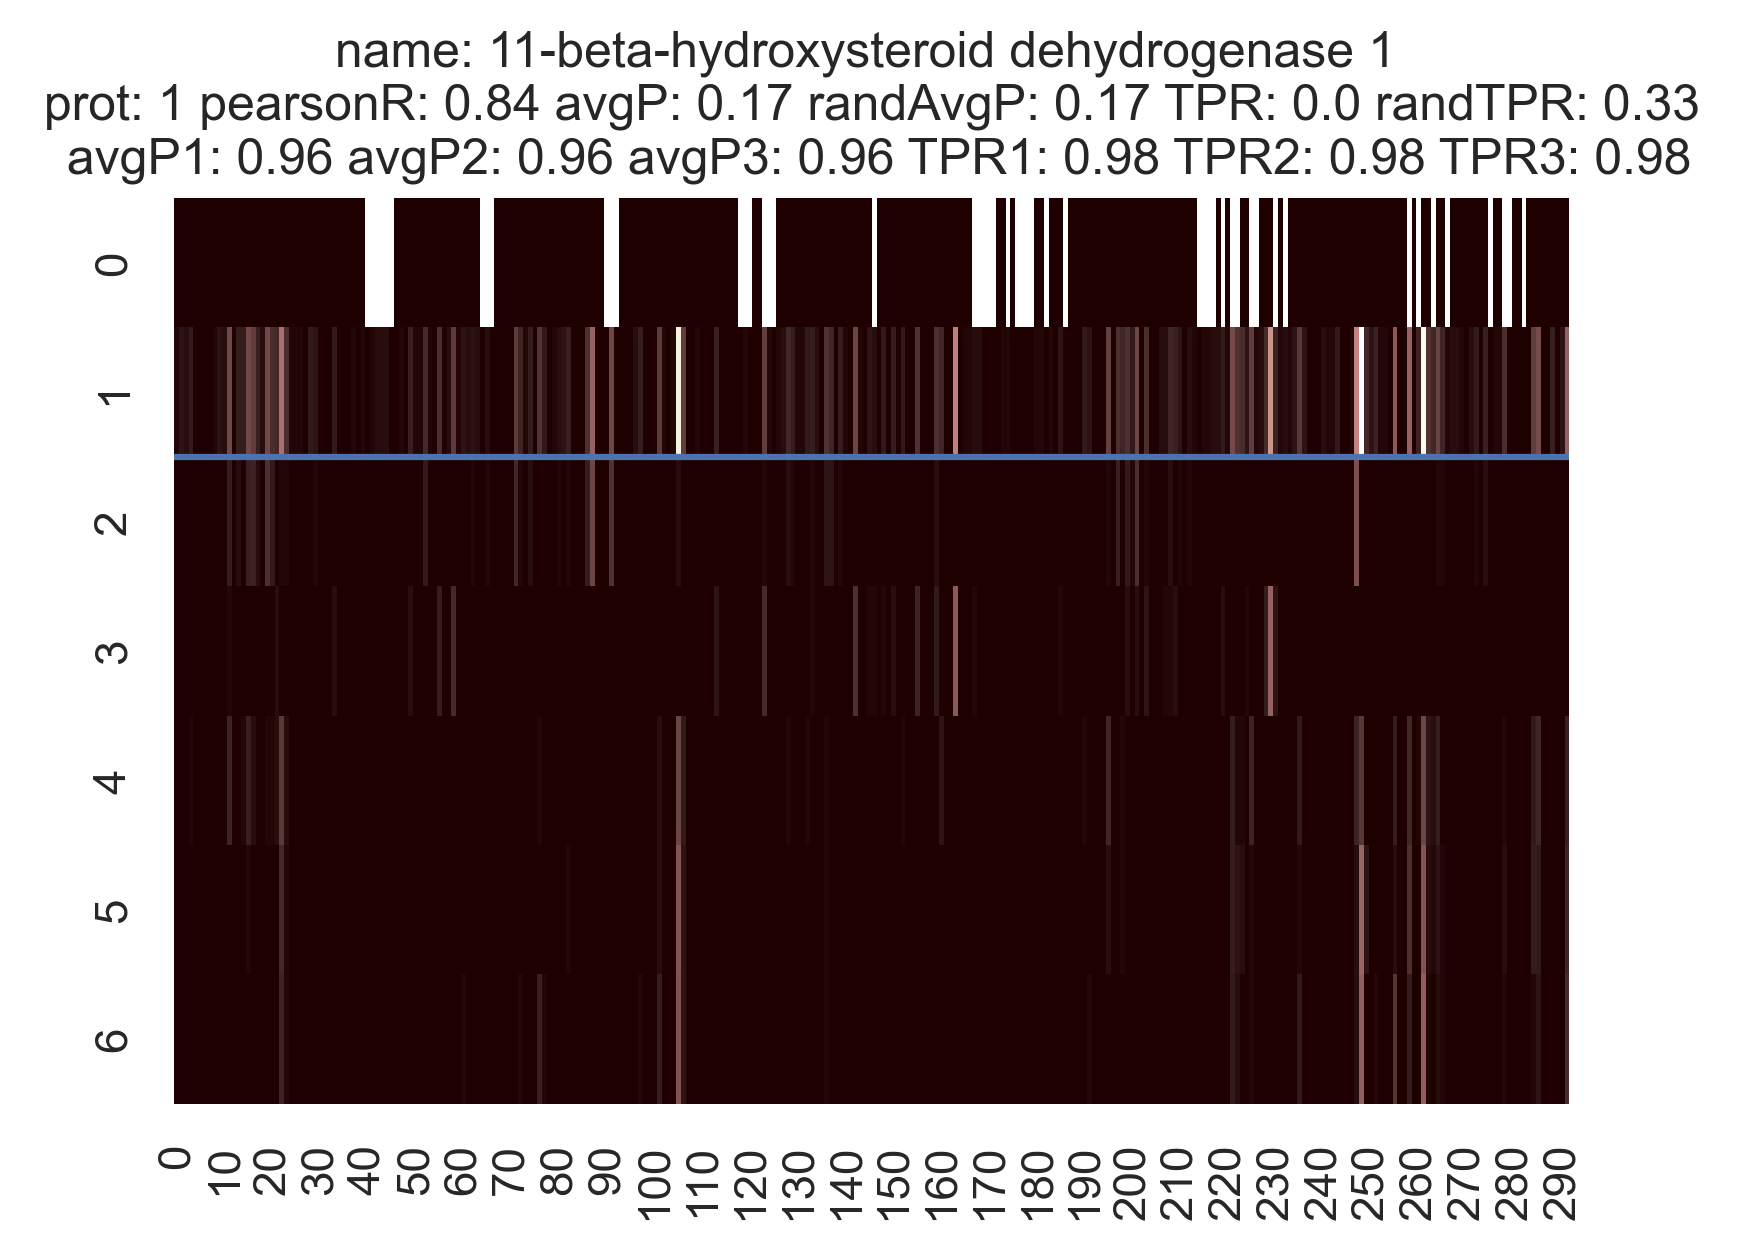

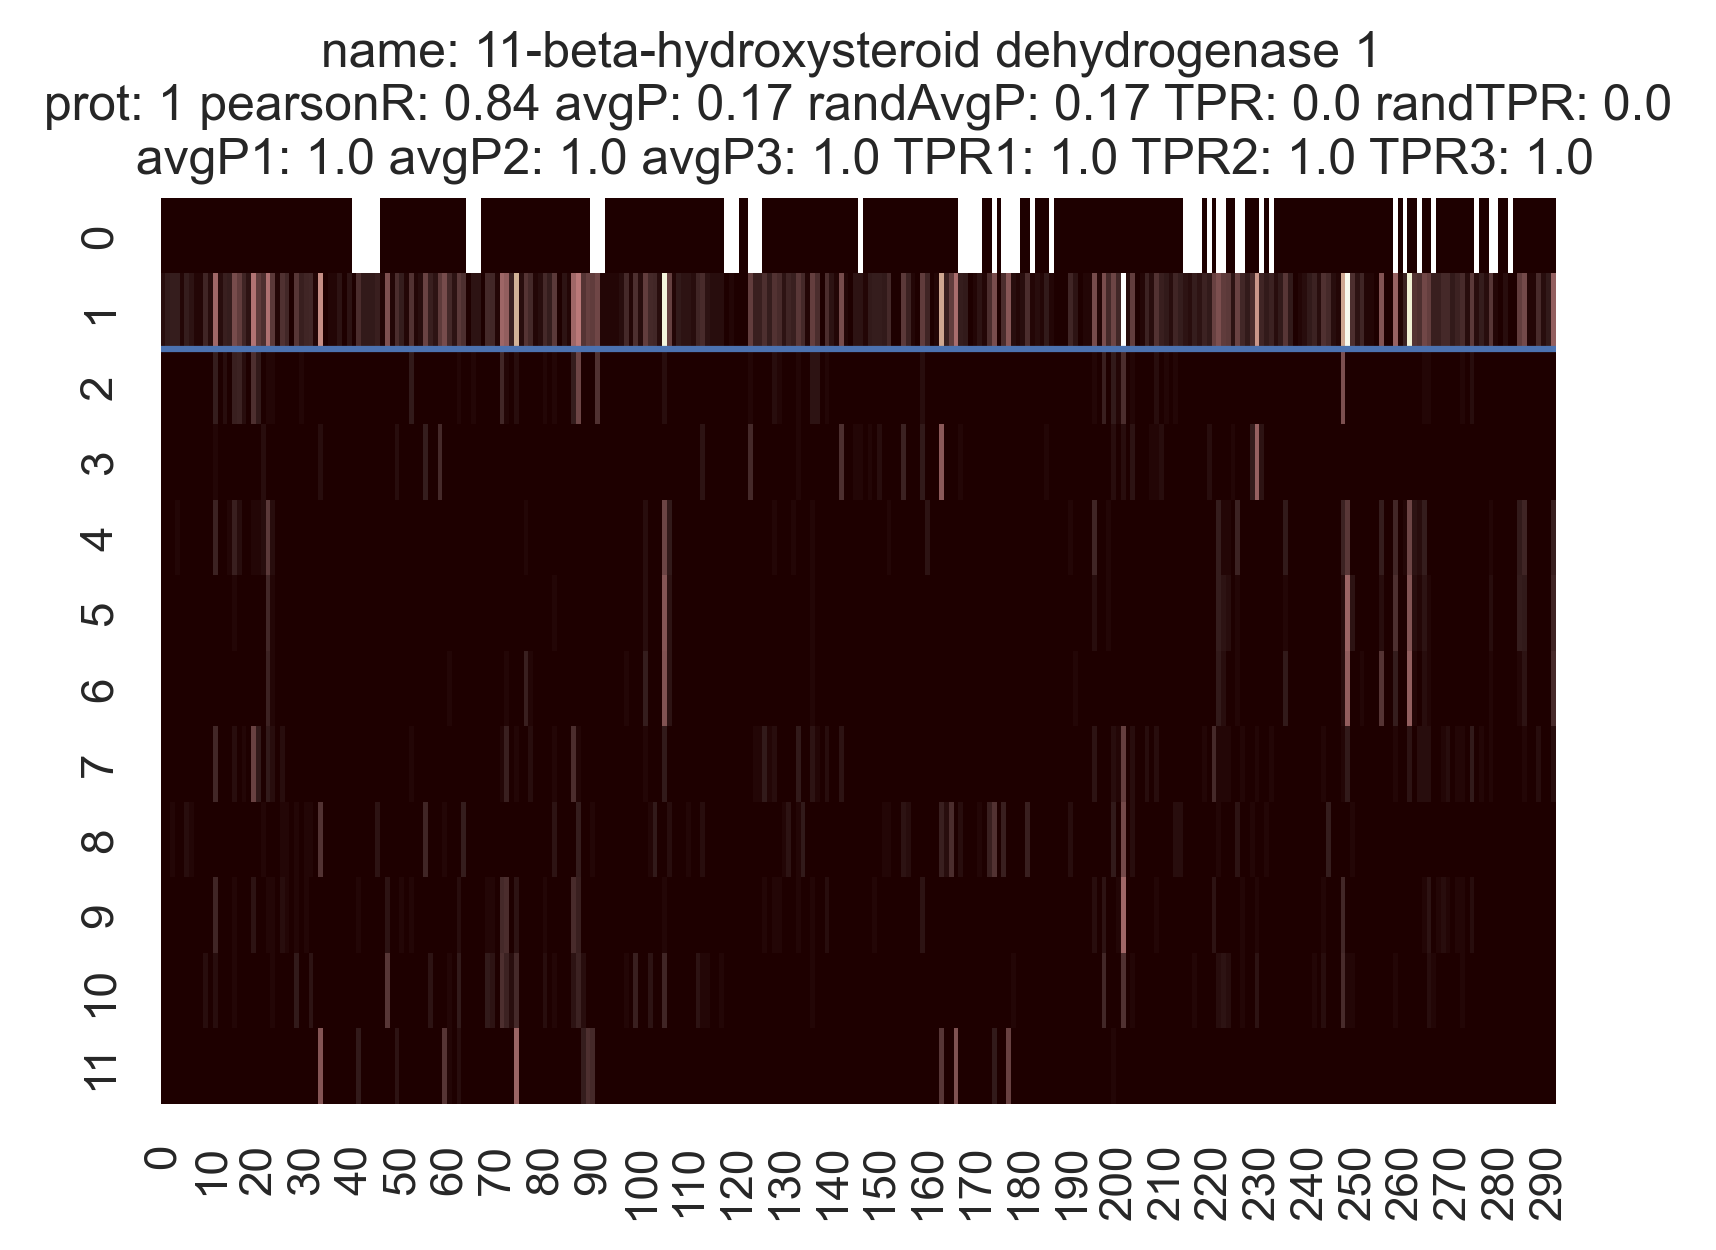

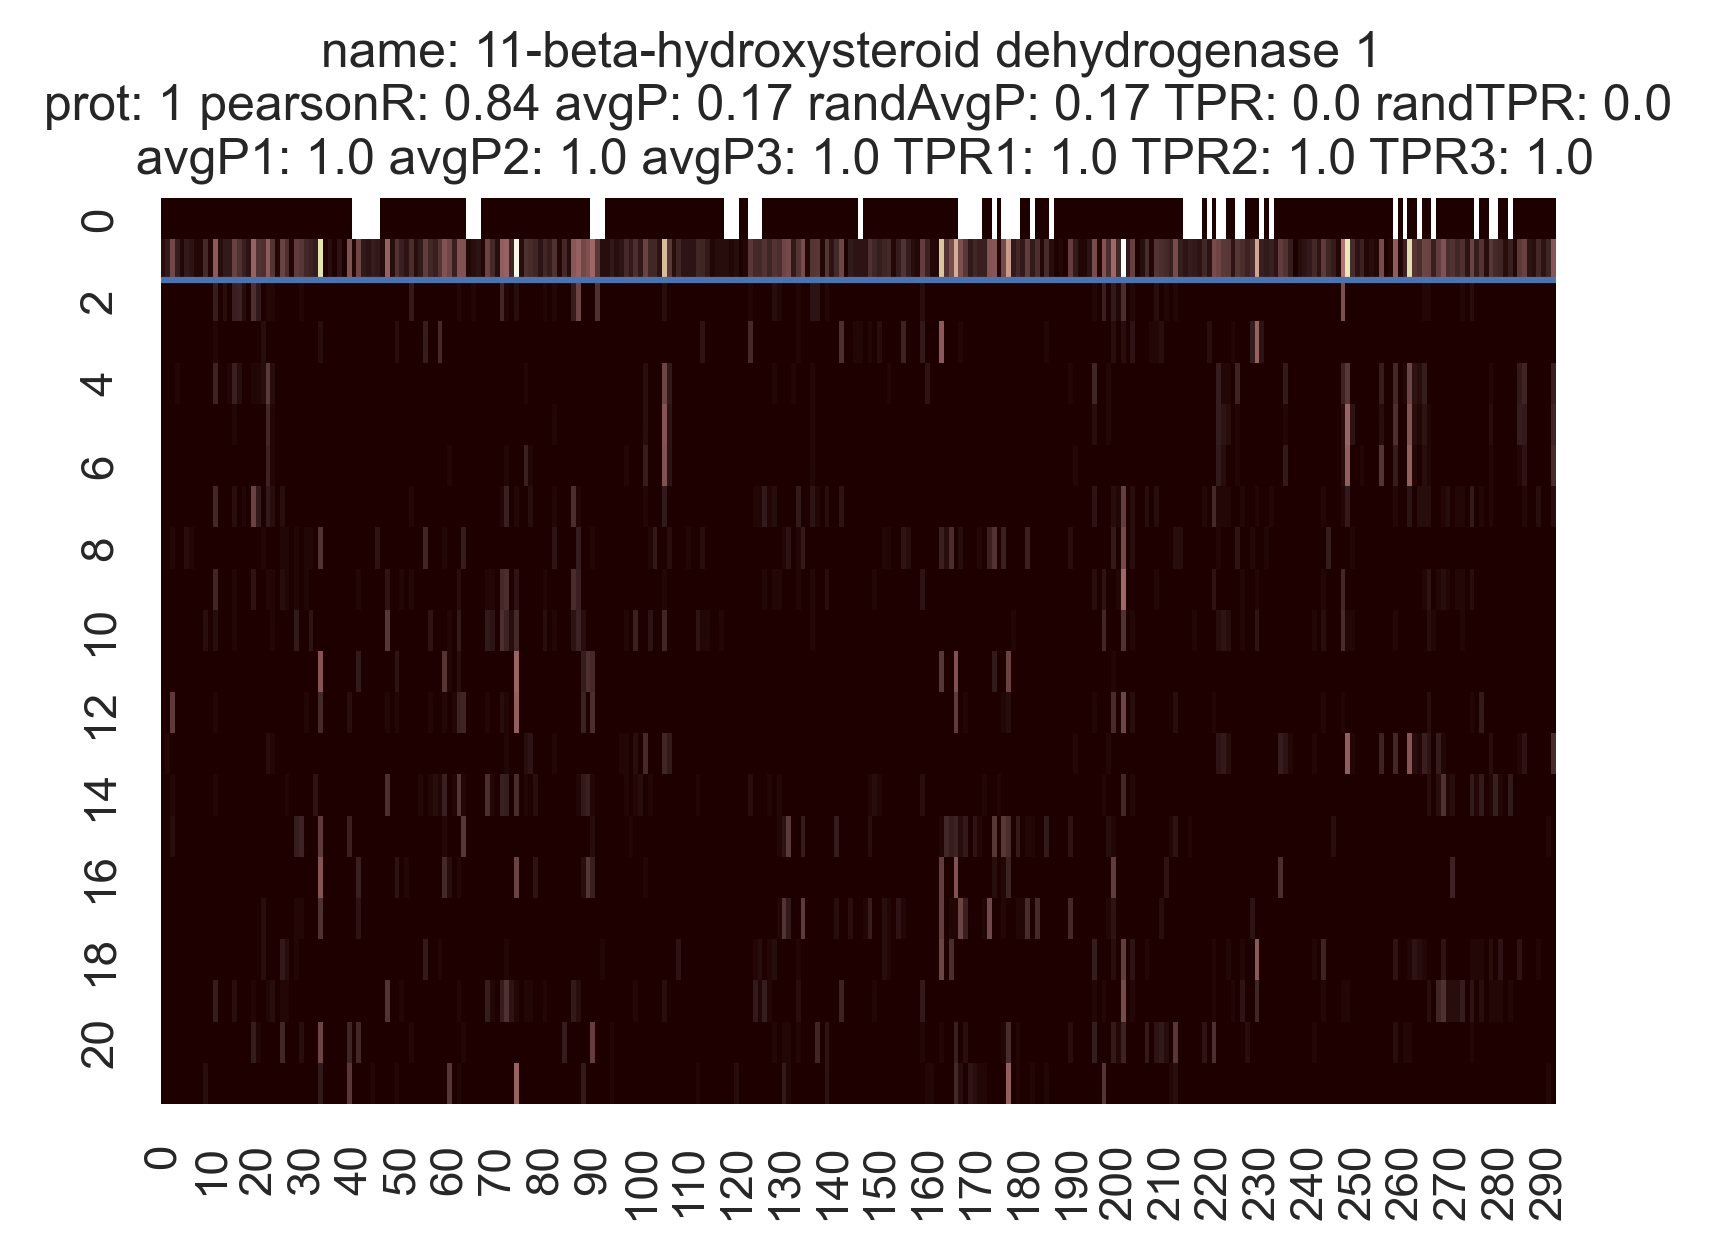

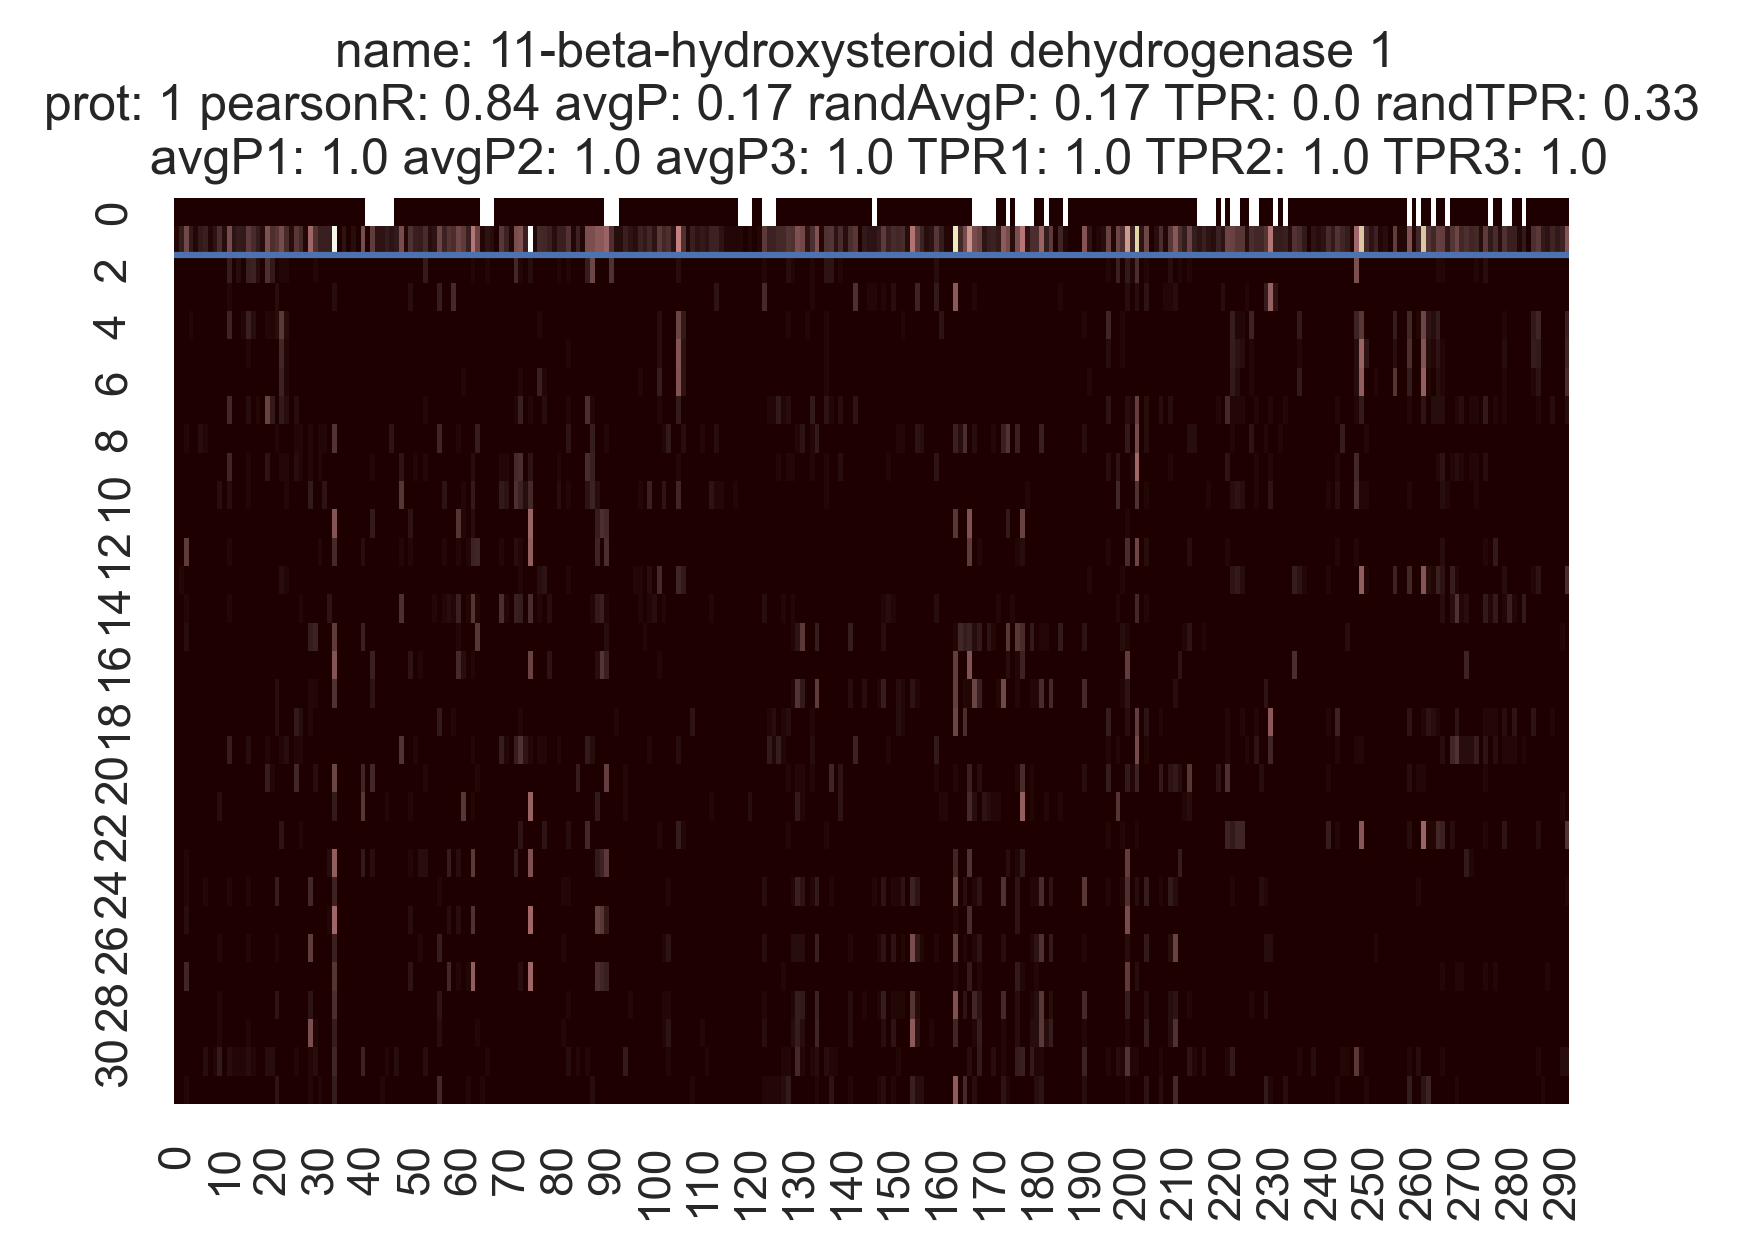

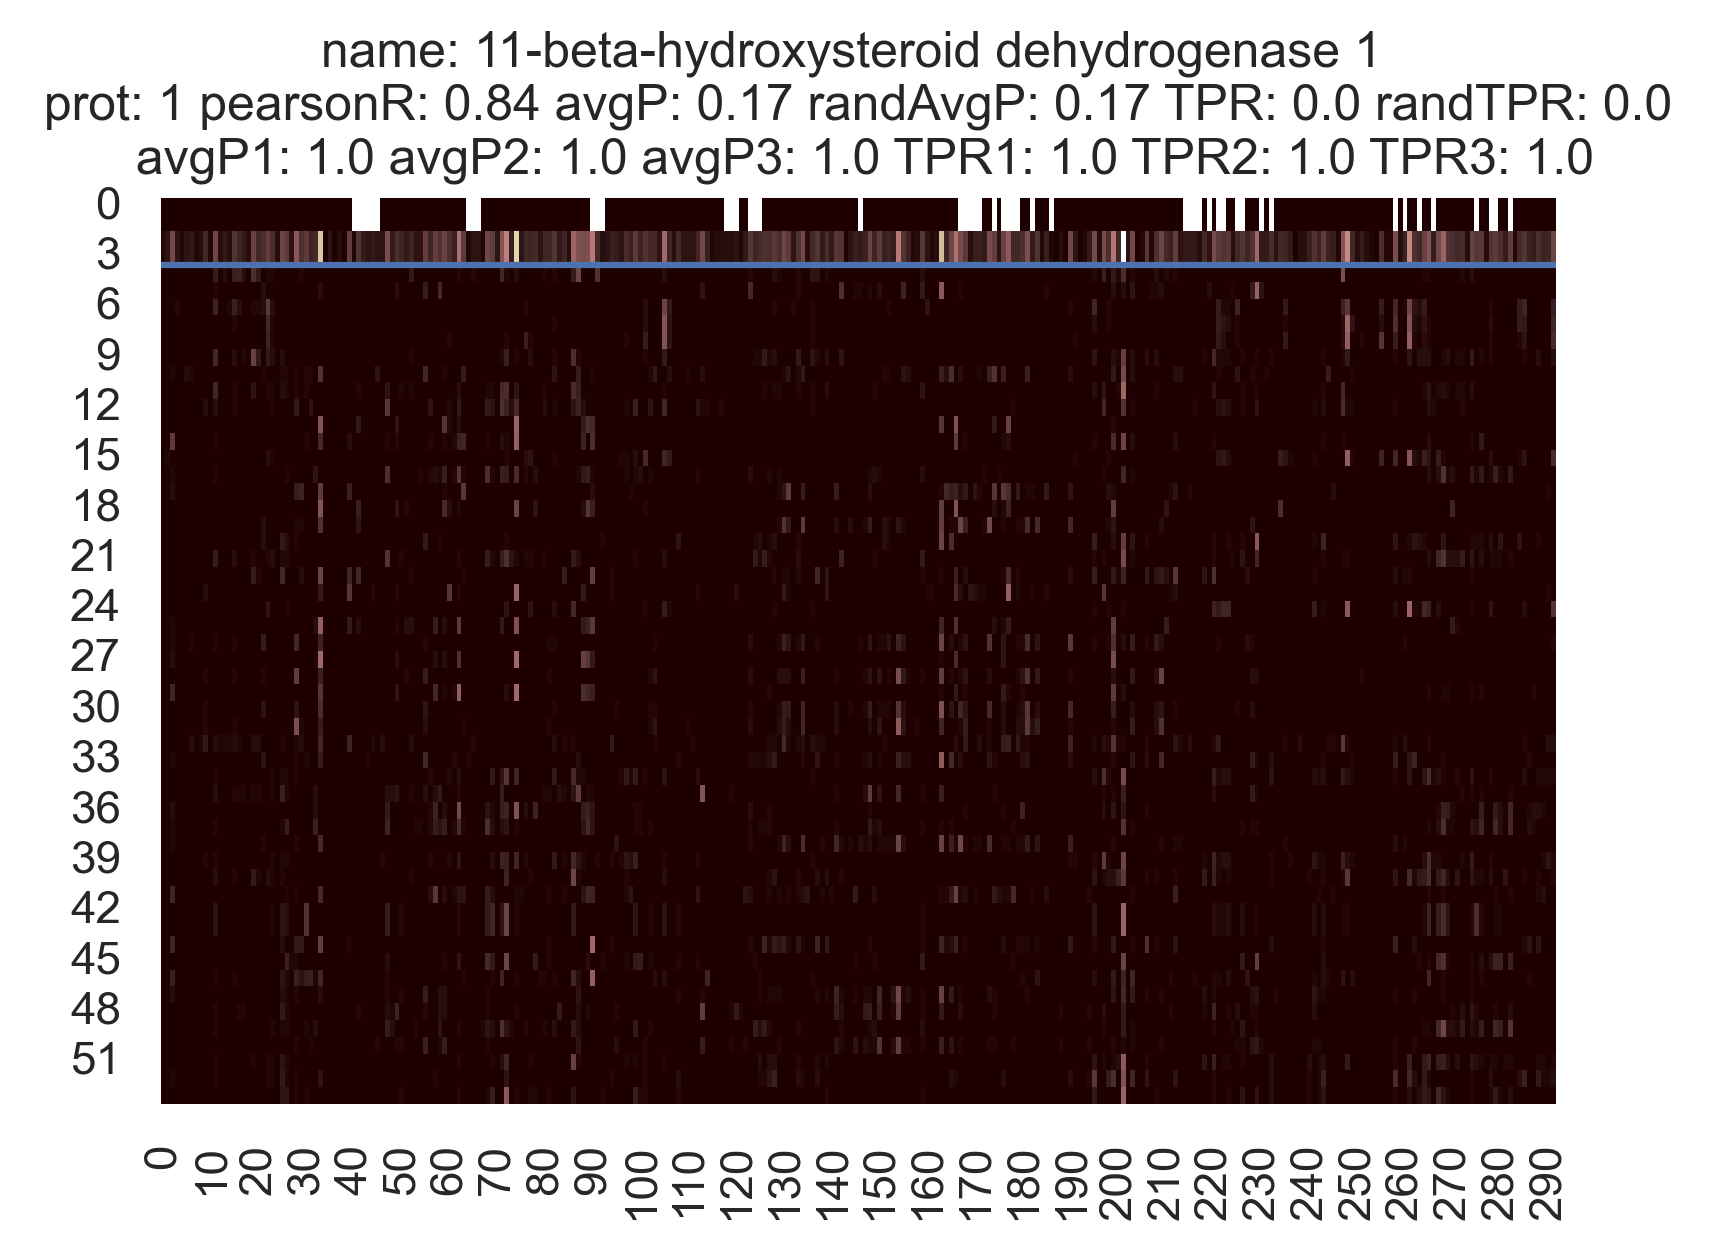

16it [00:56,  1.32s/it]

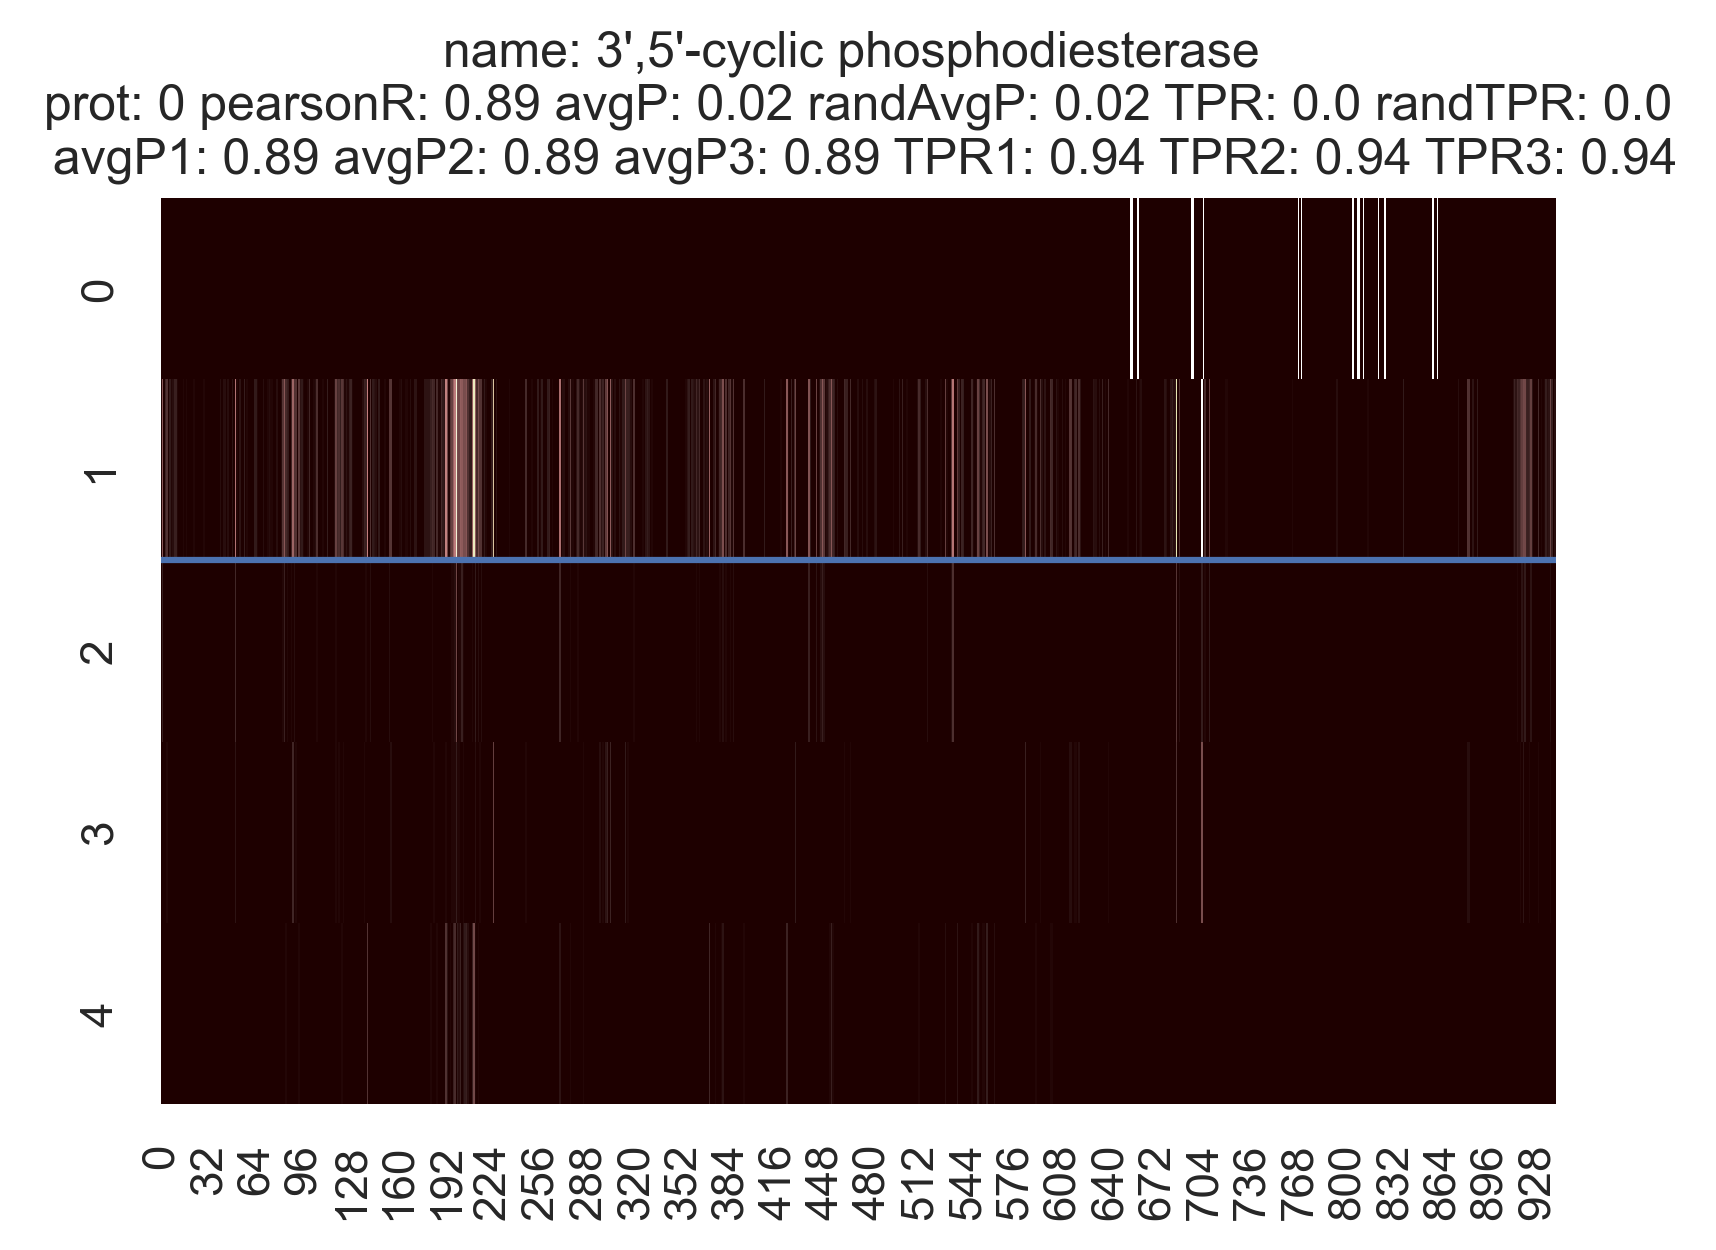

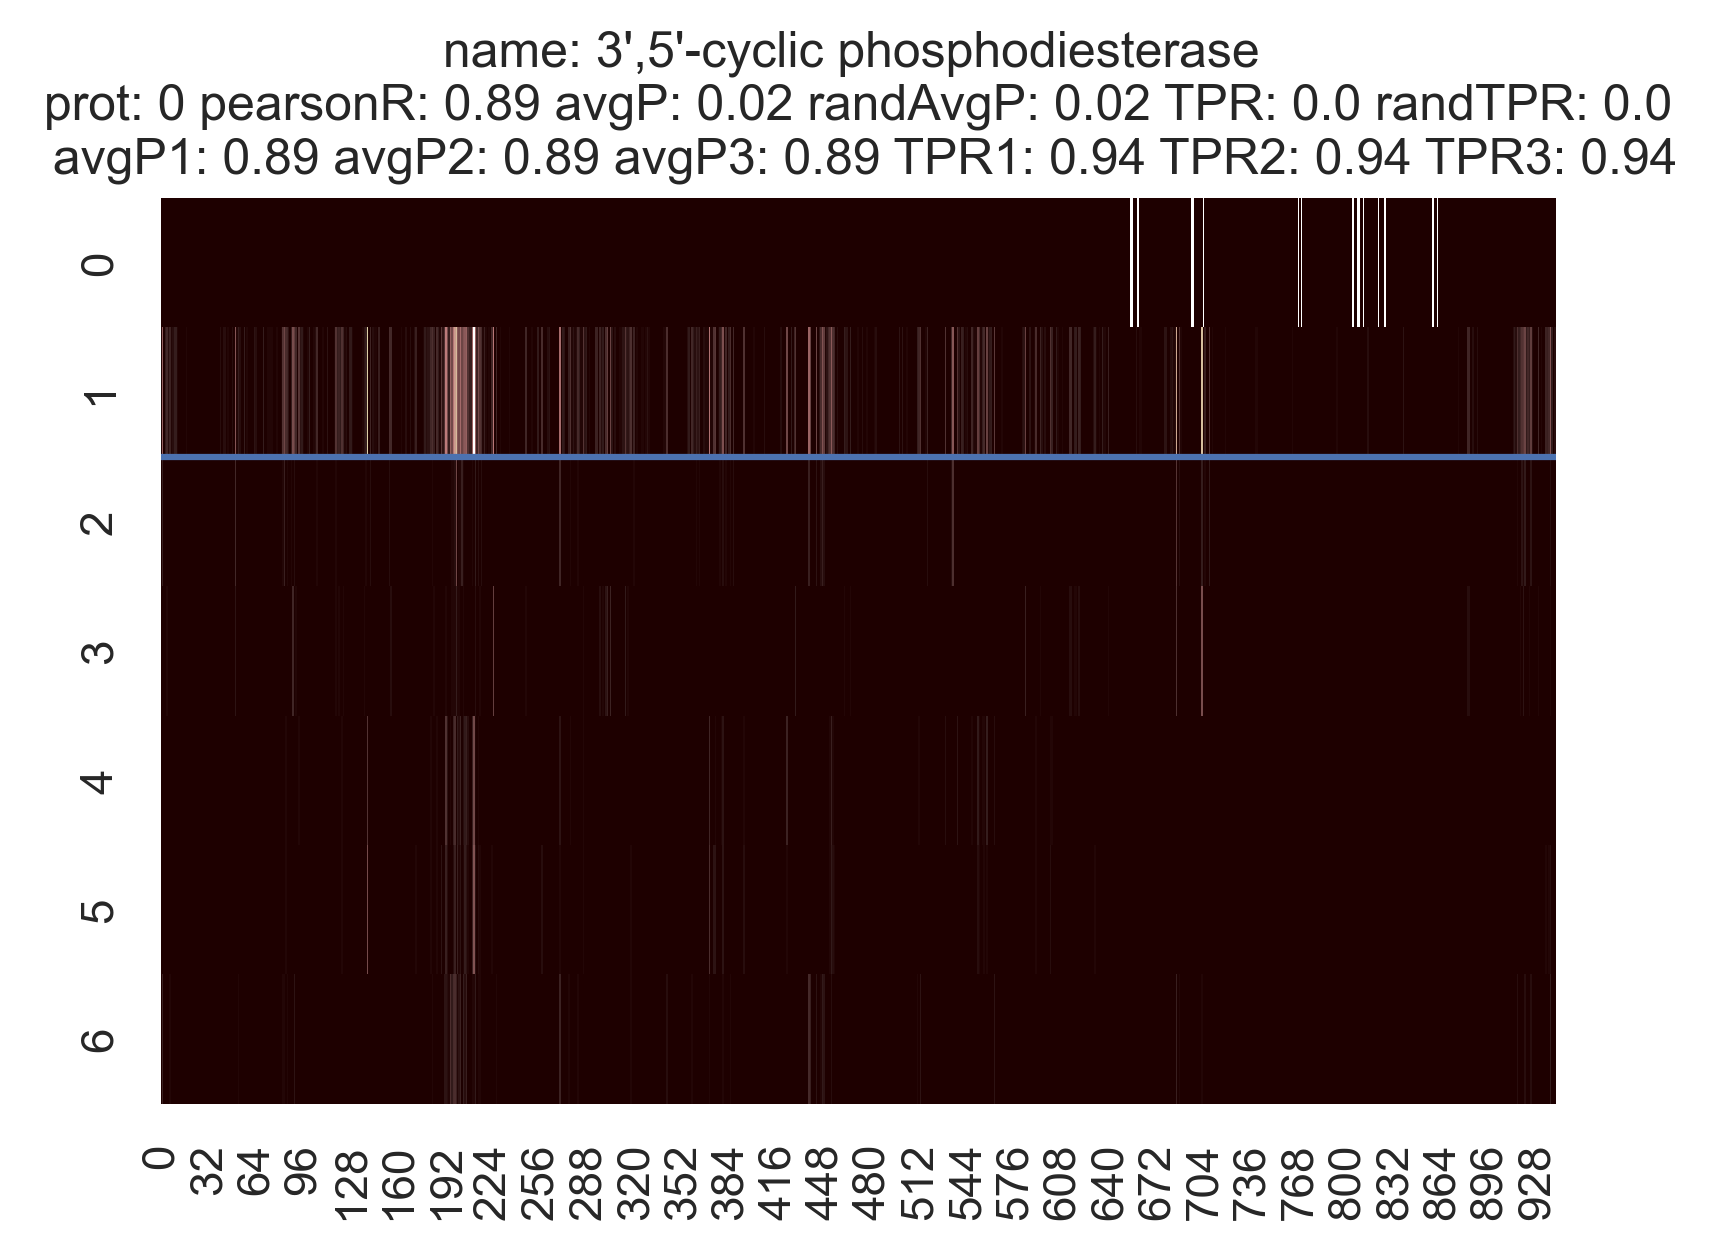

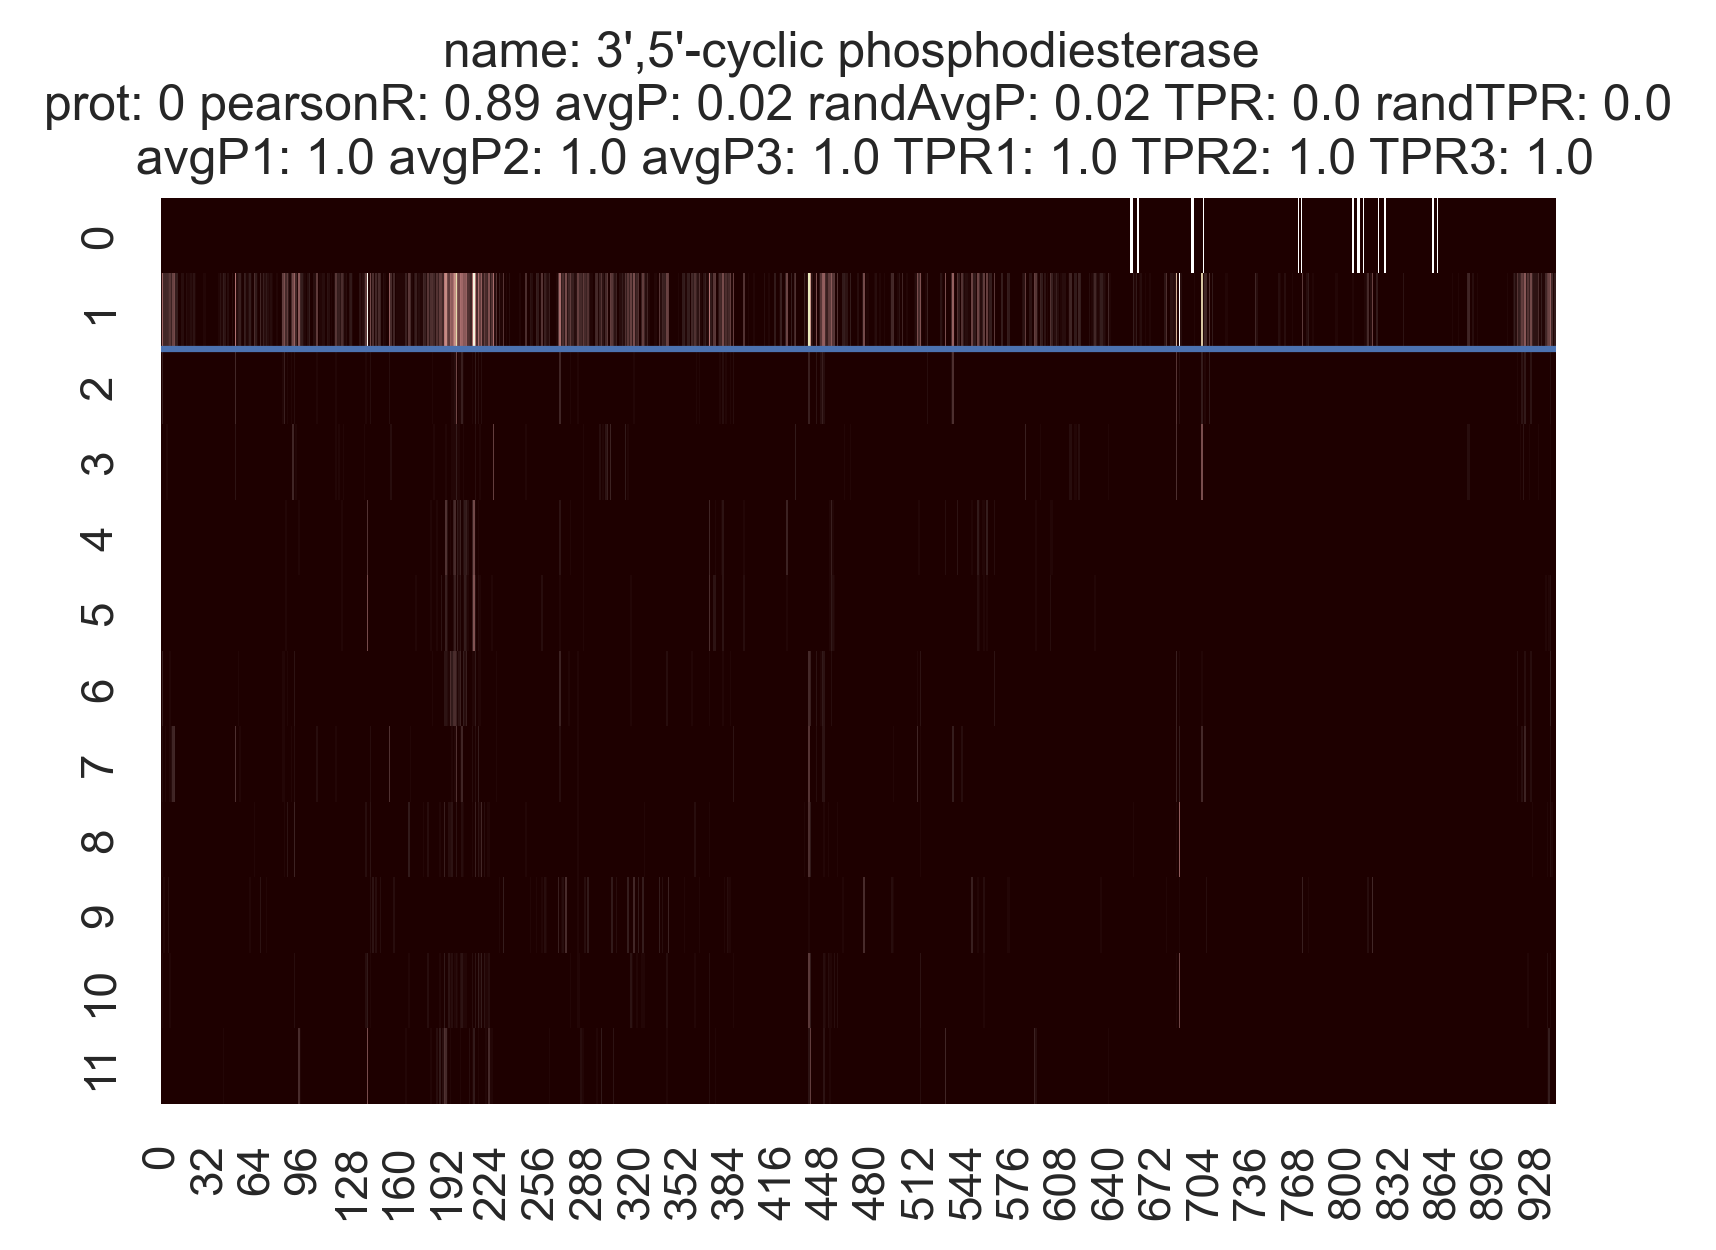

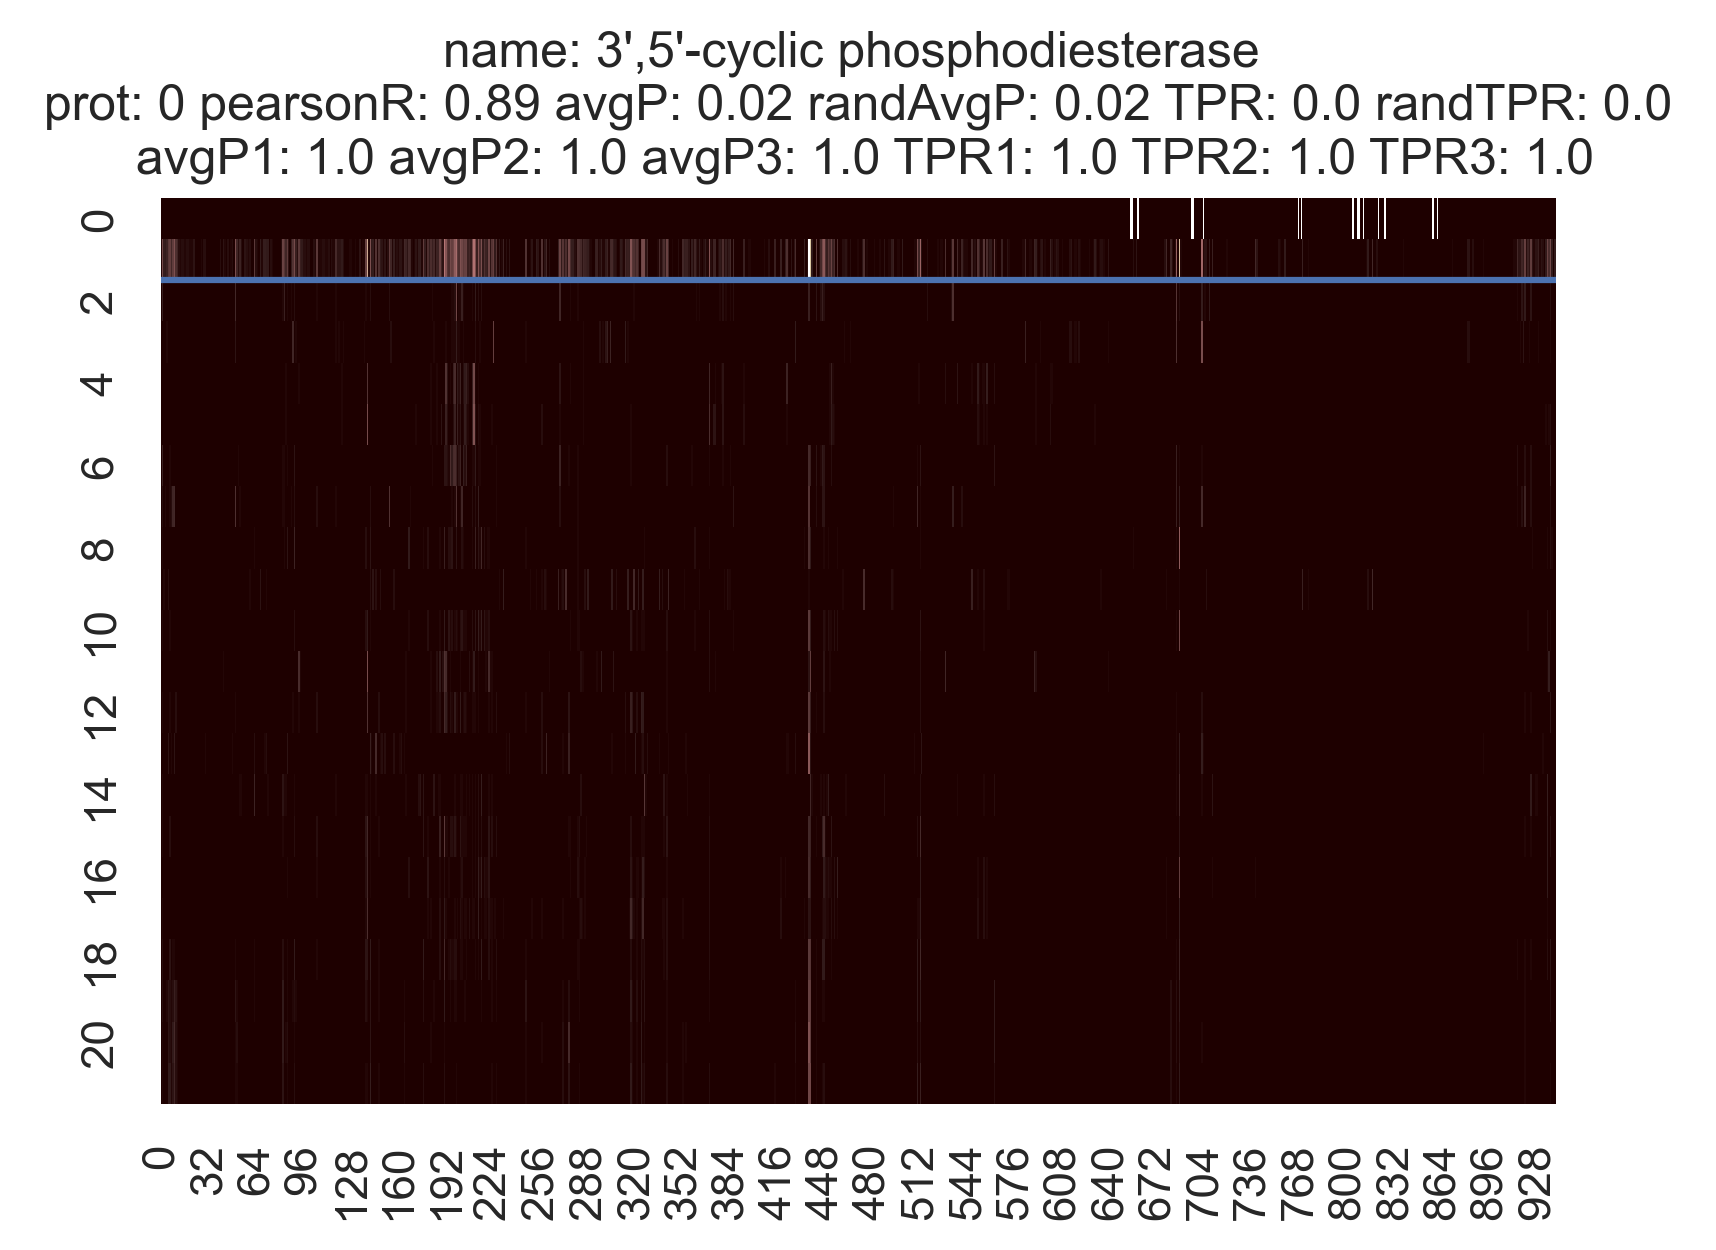

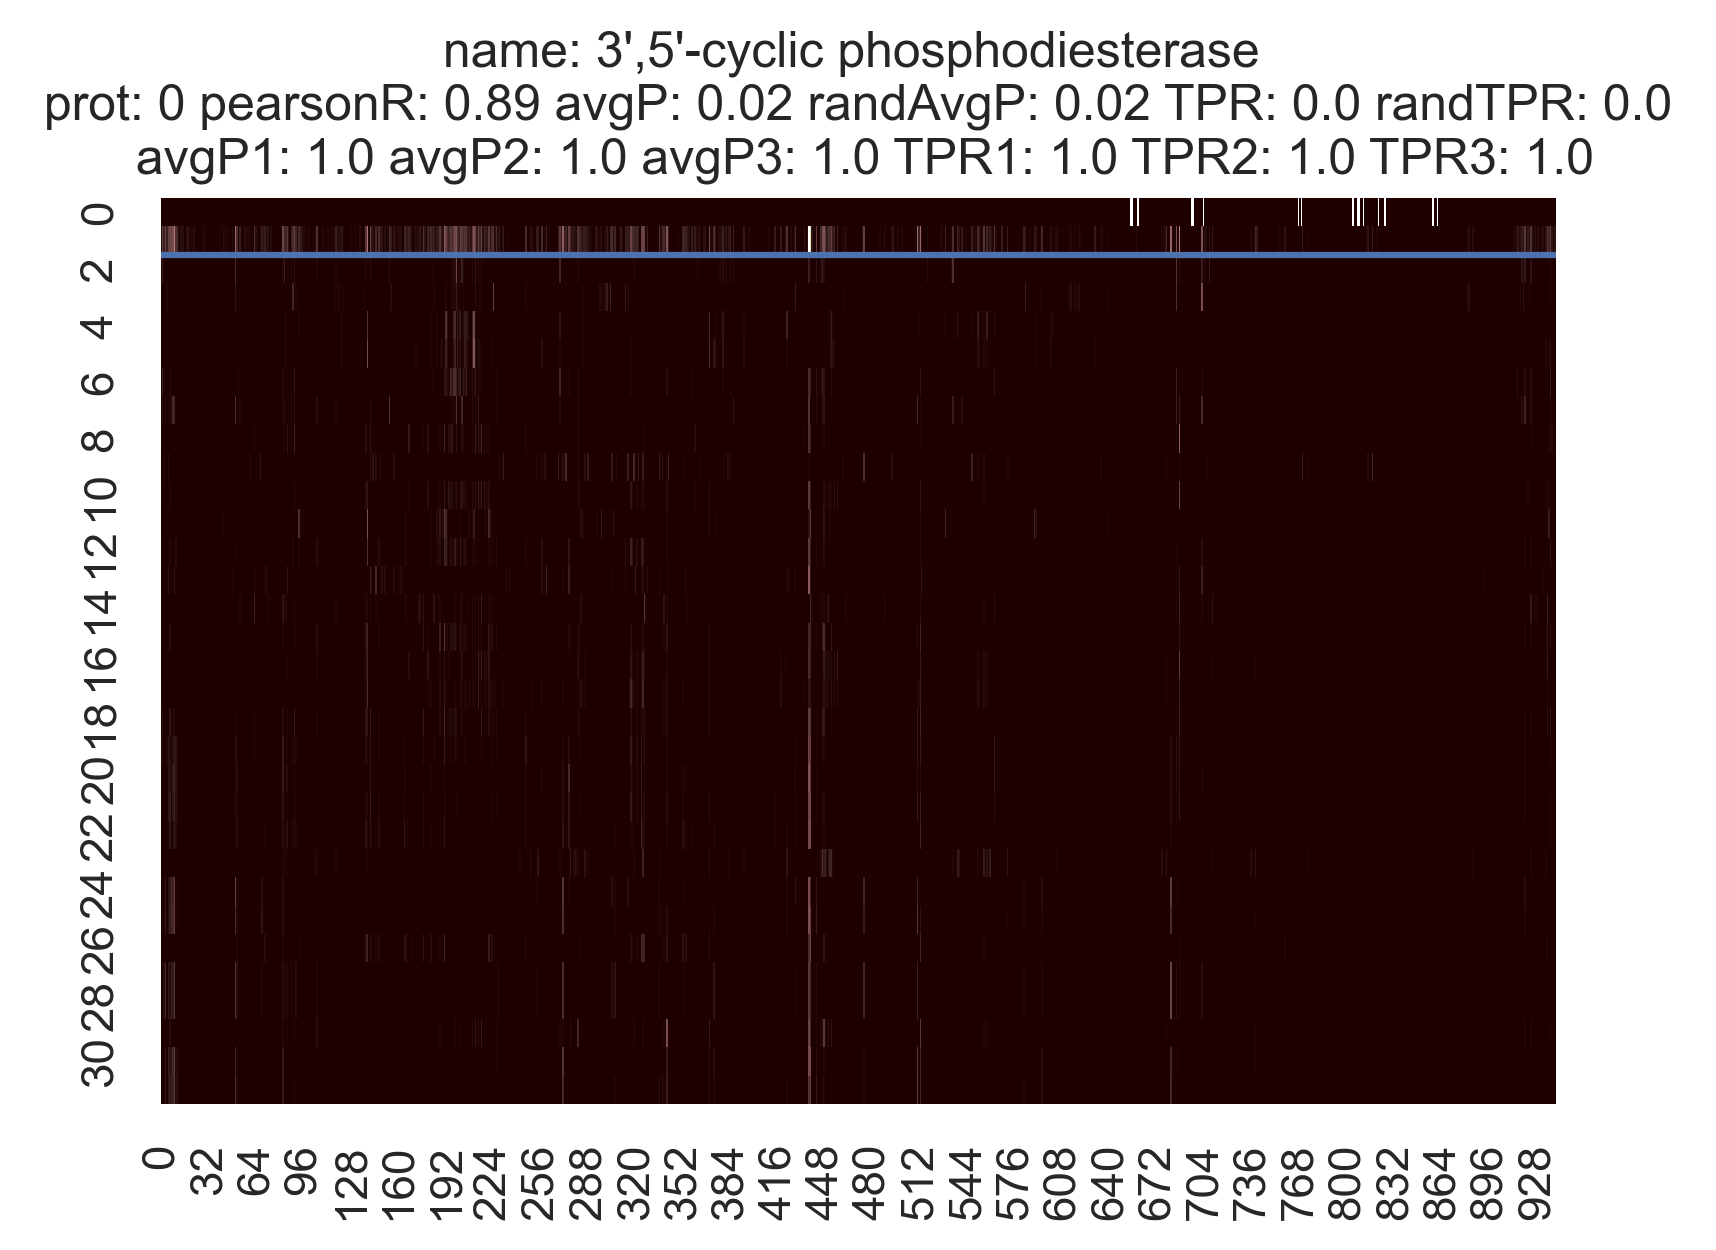

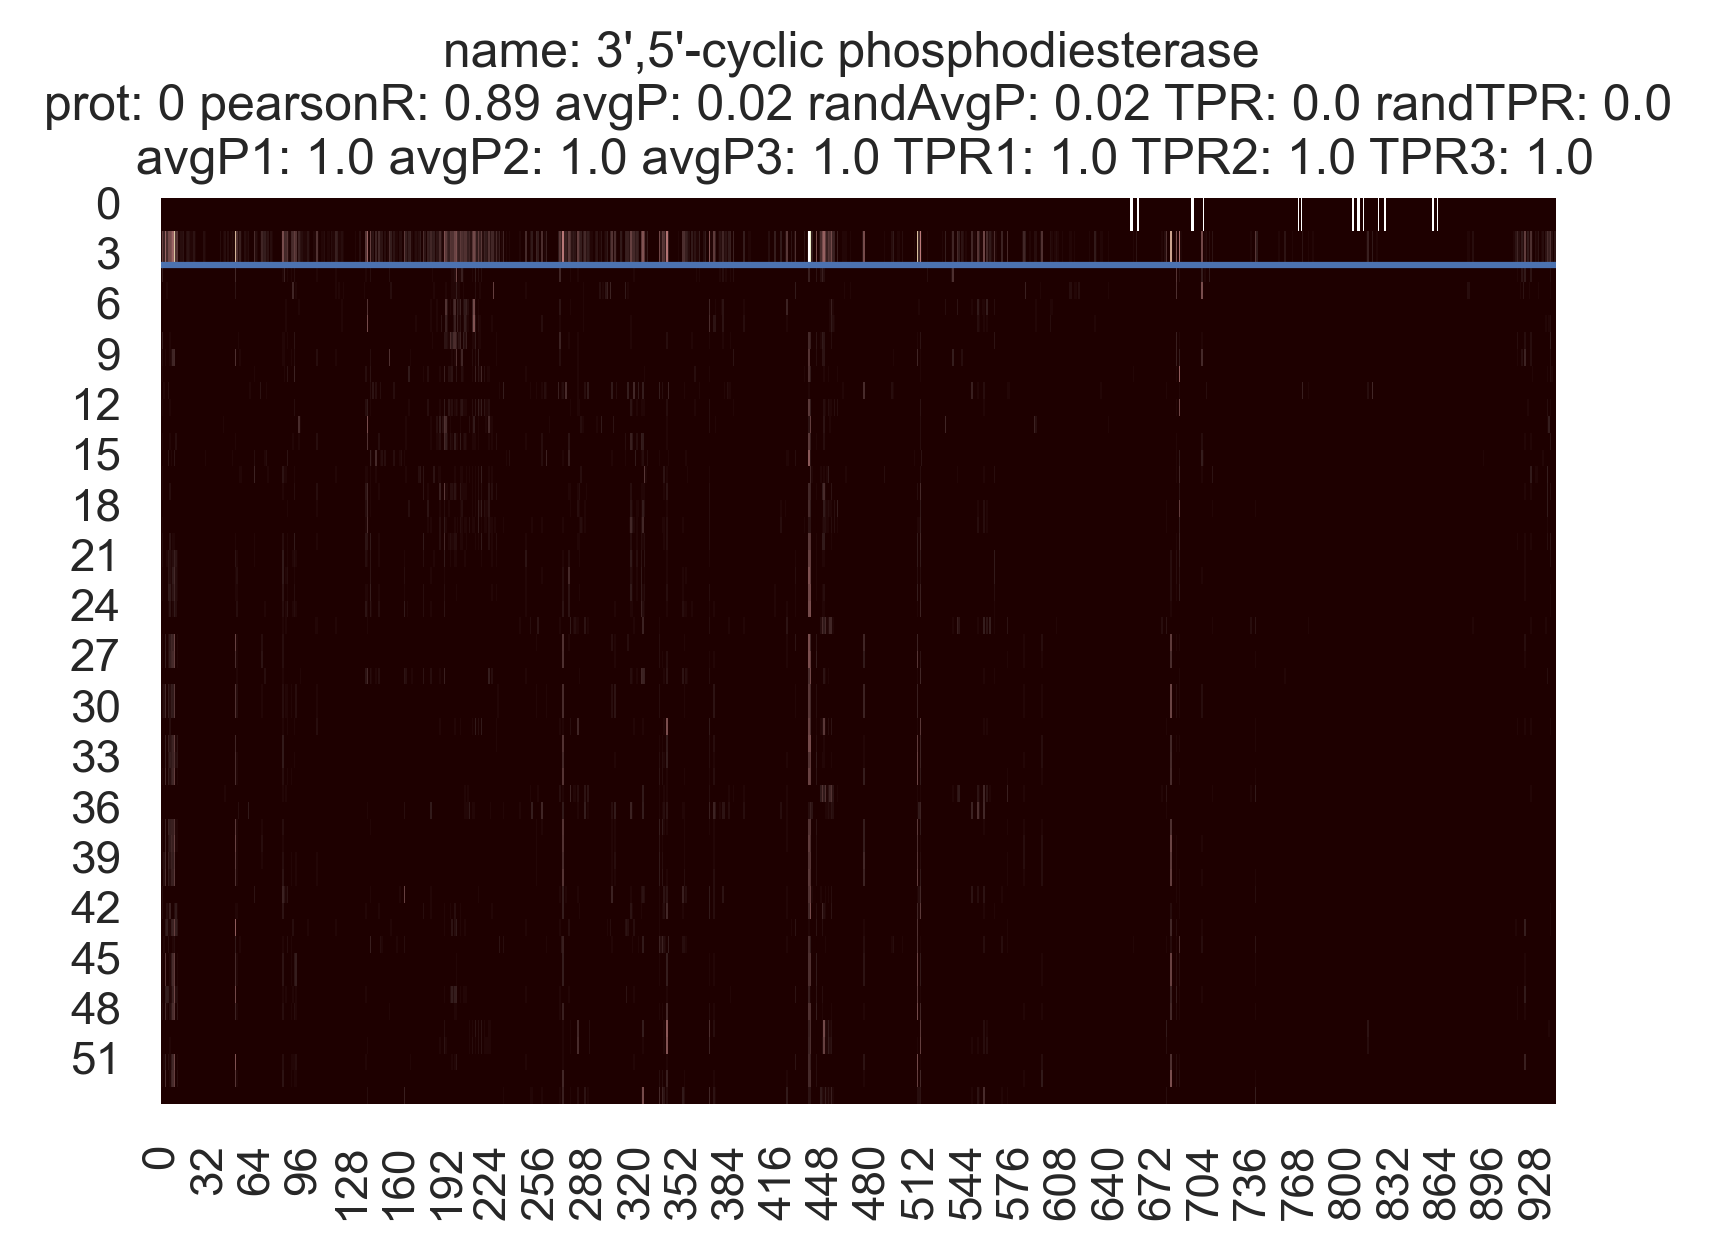

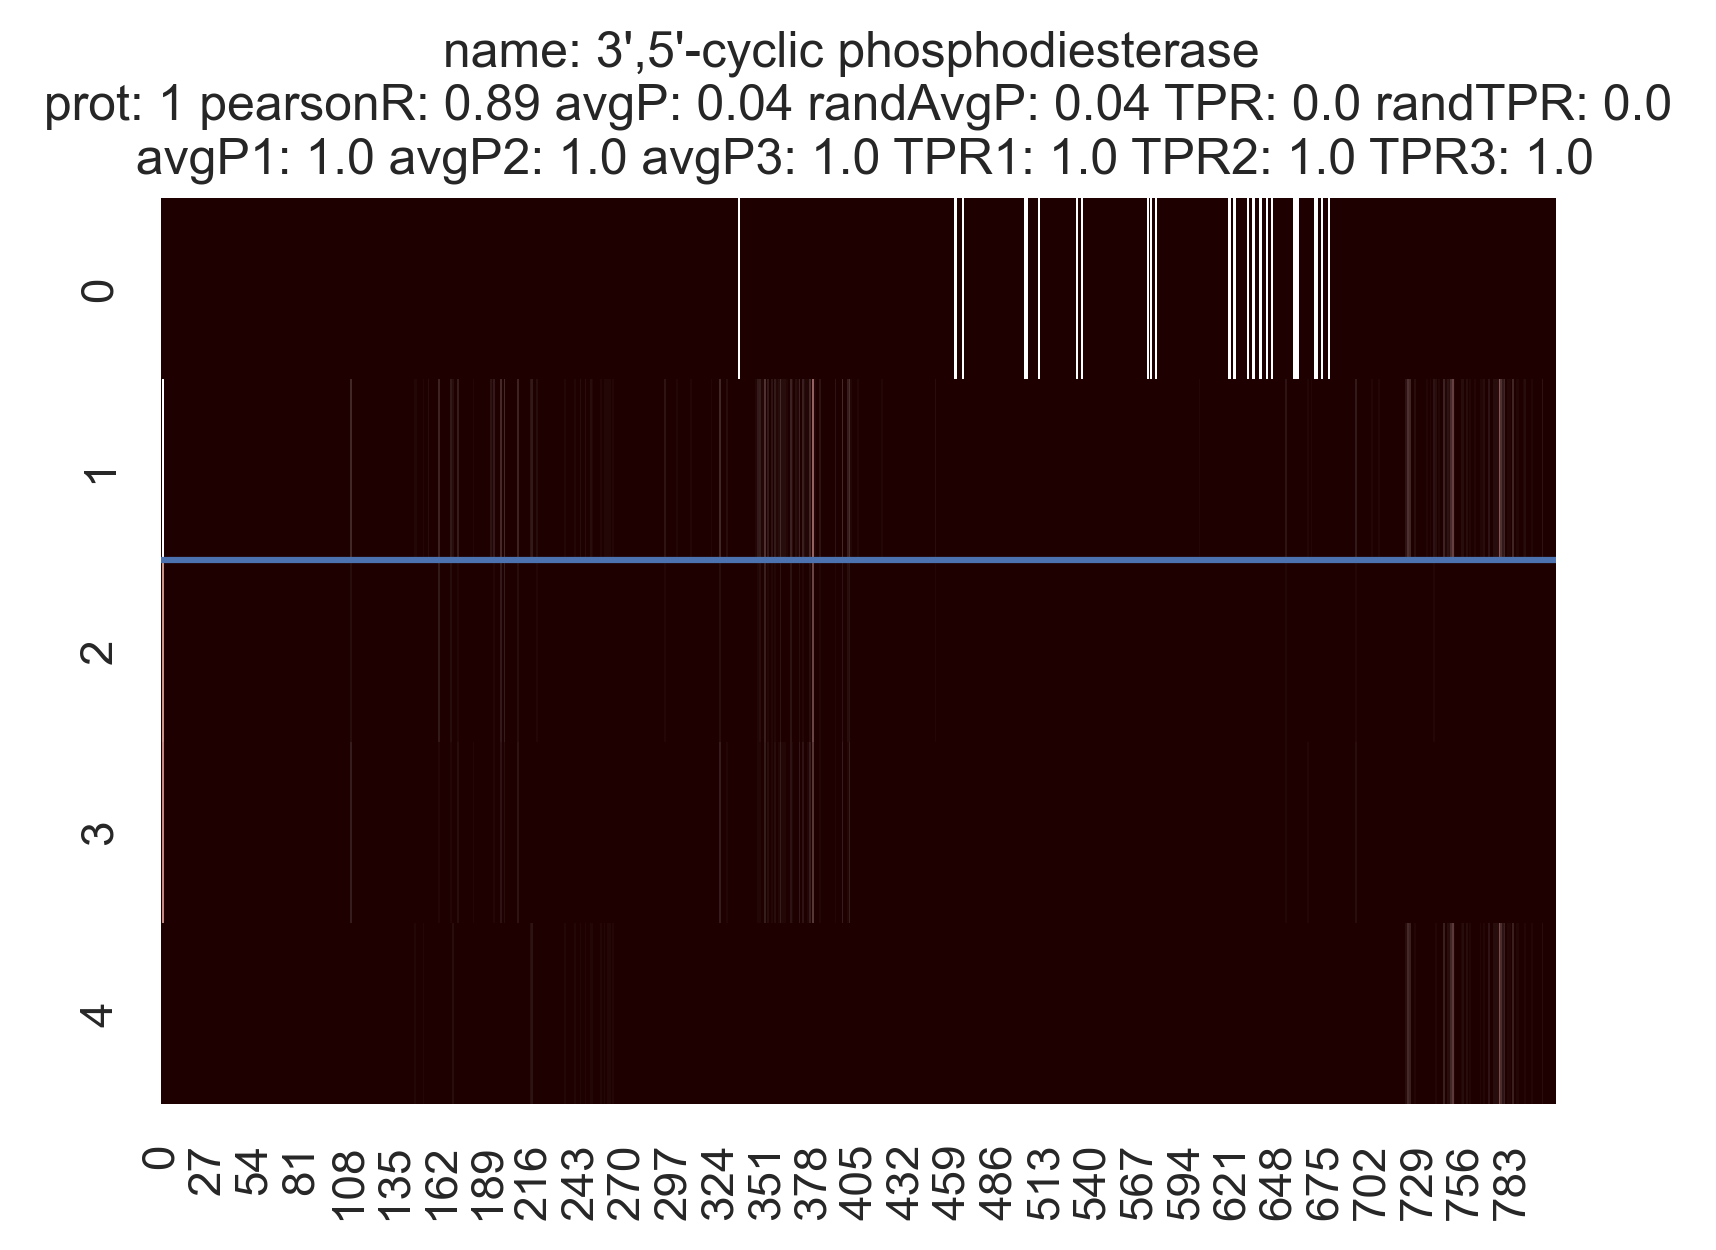

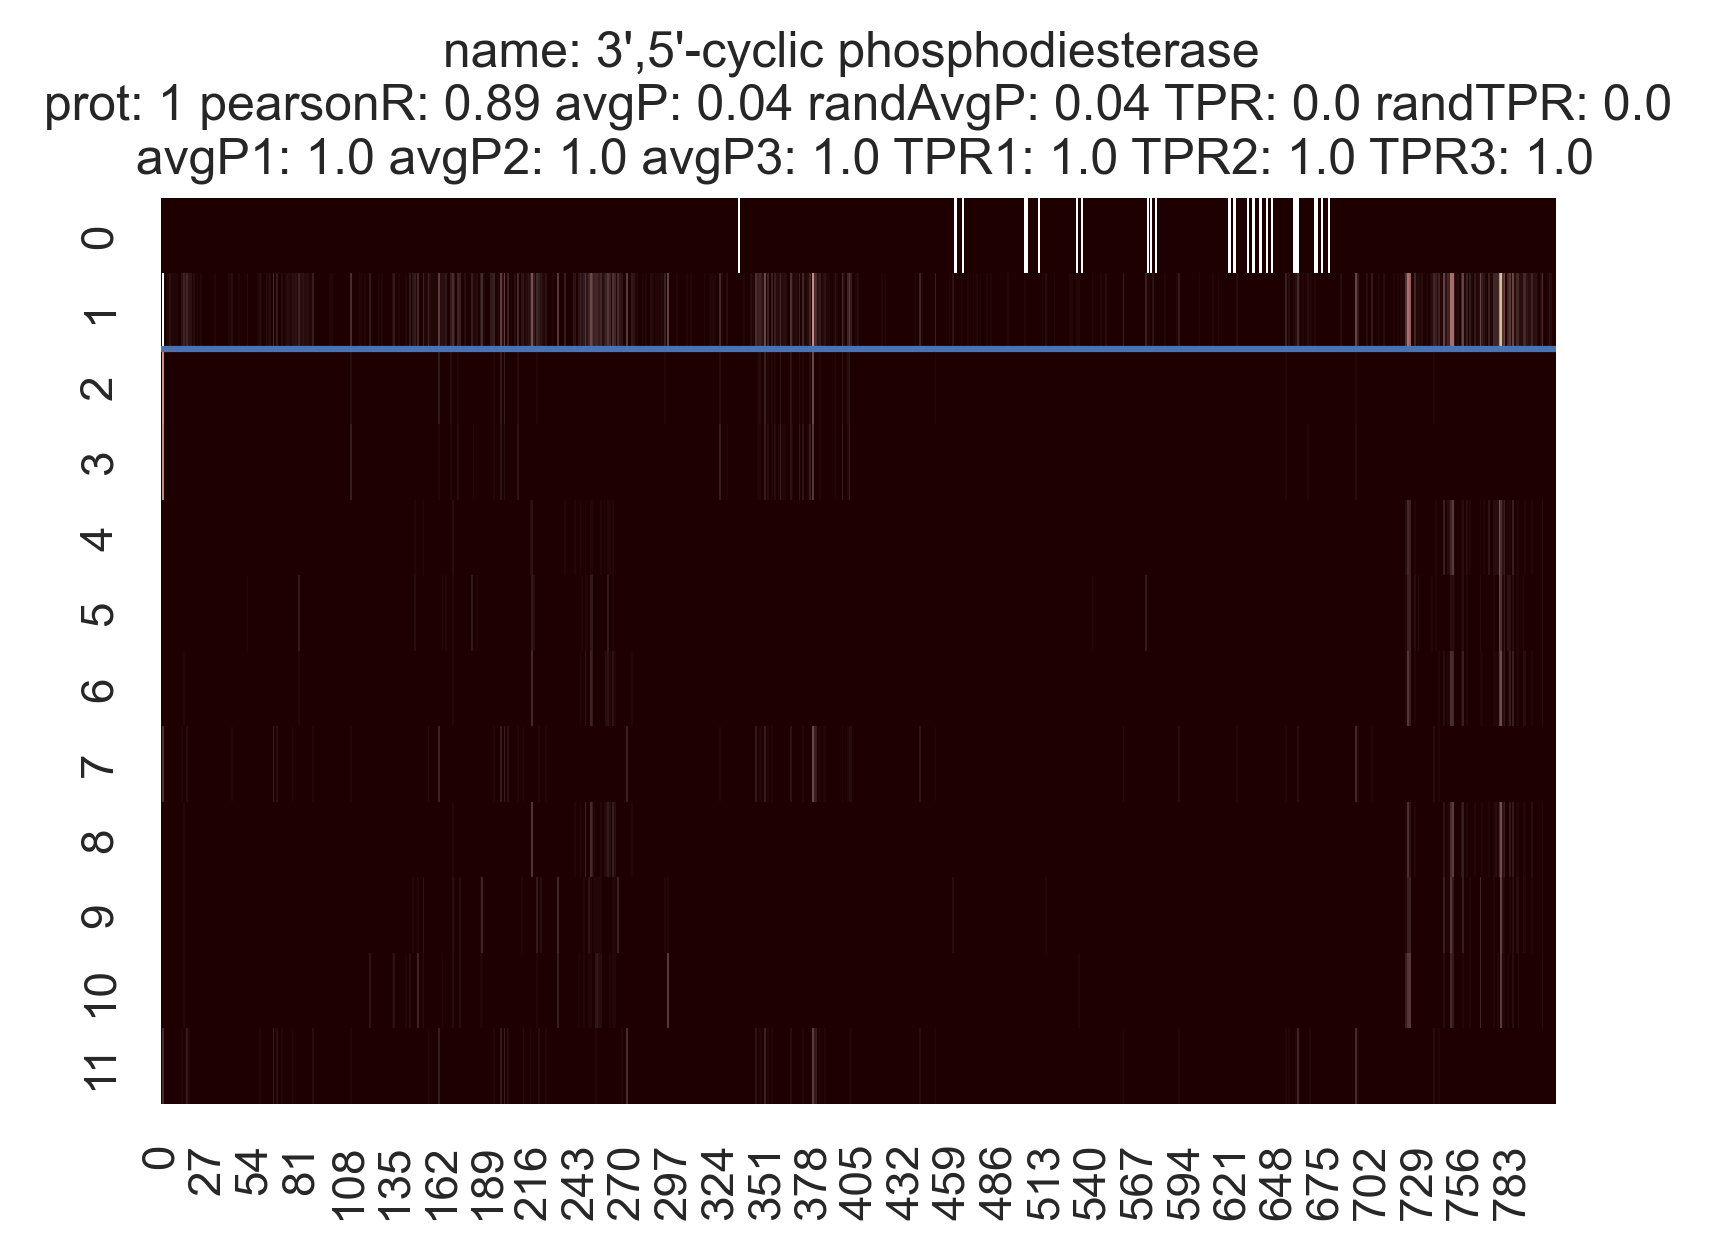

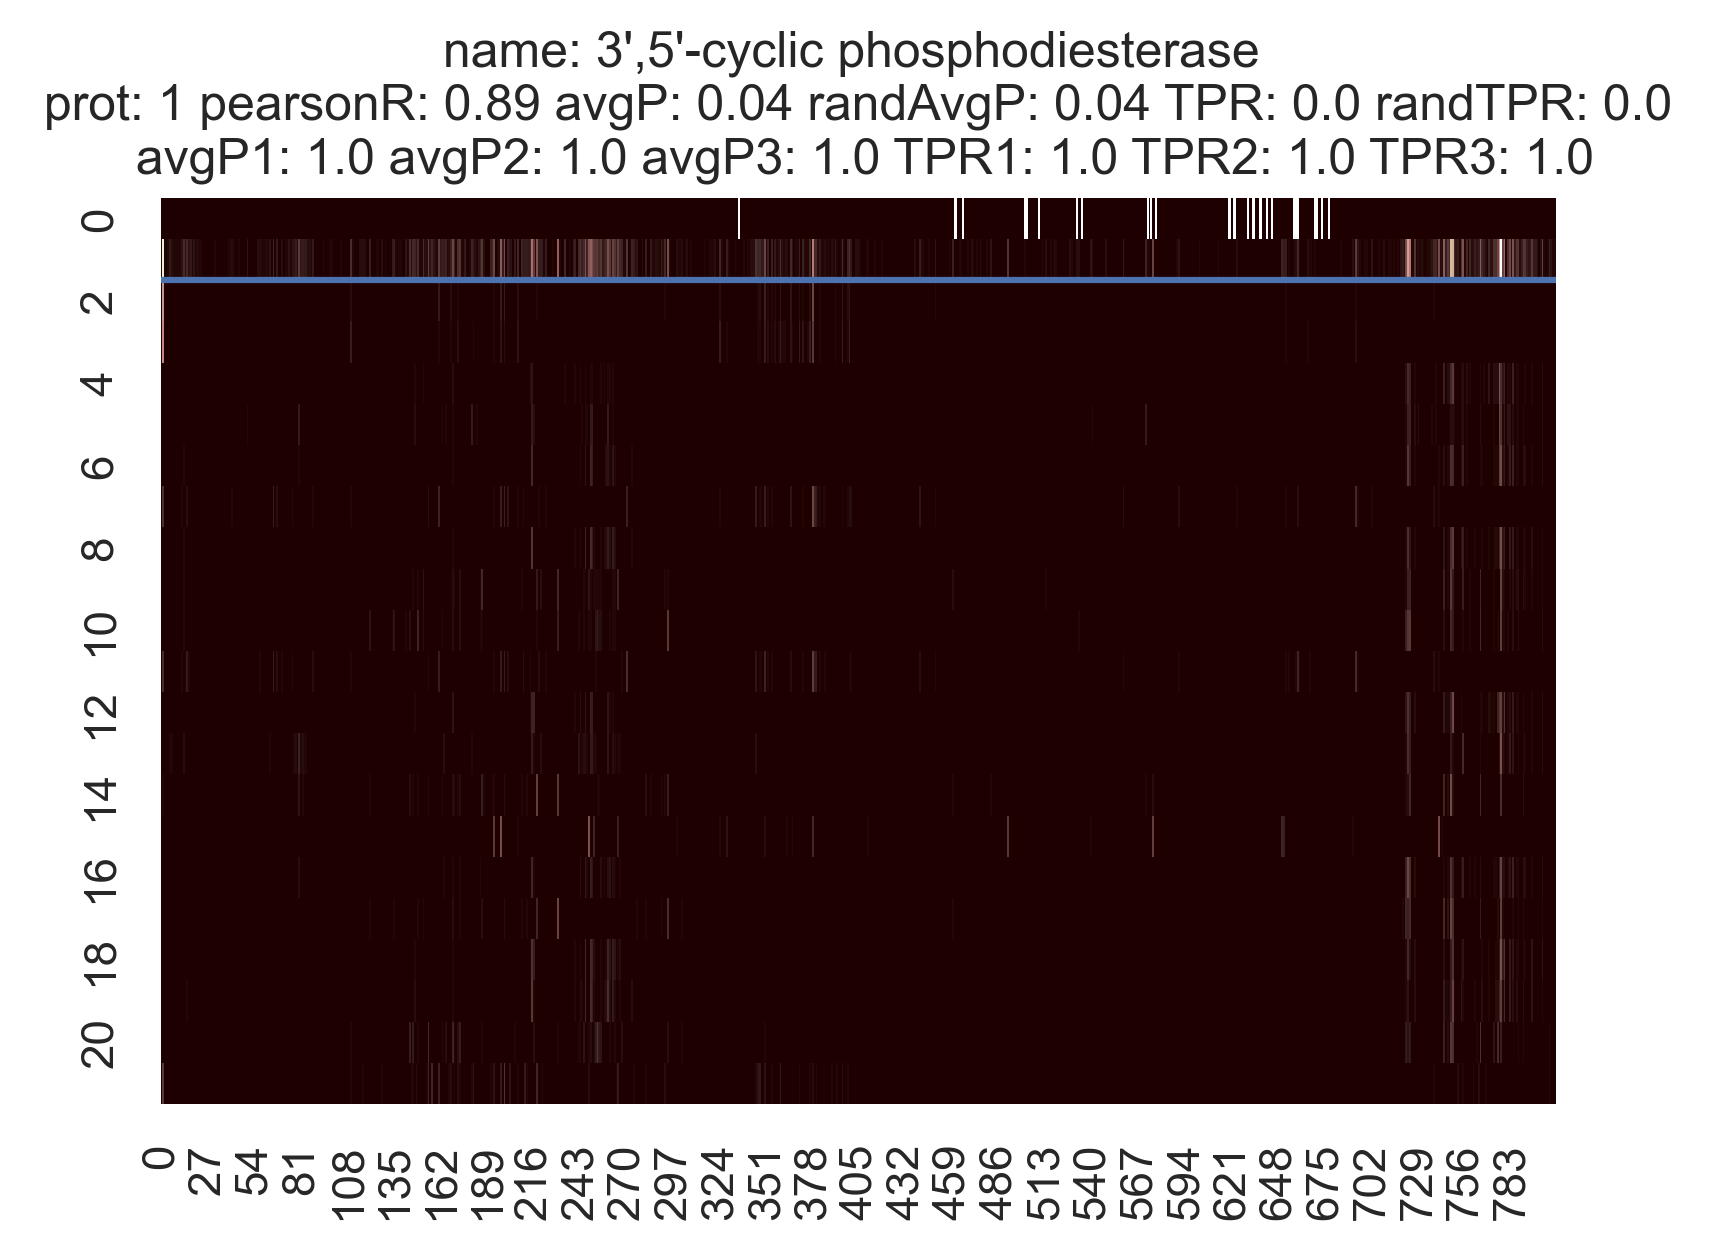

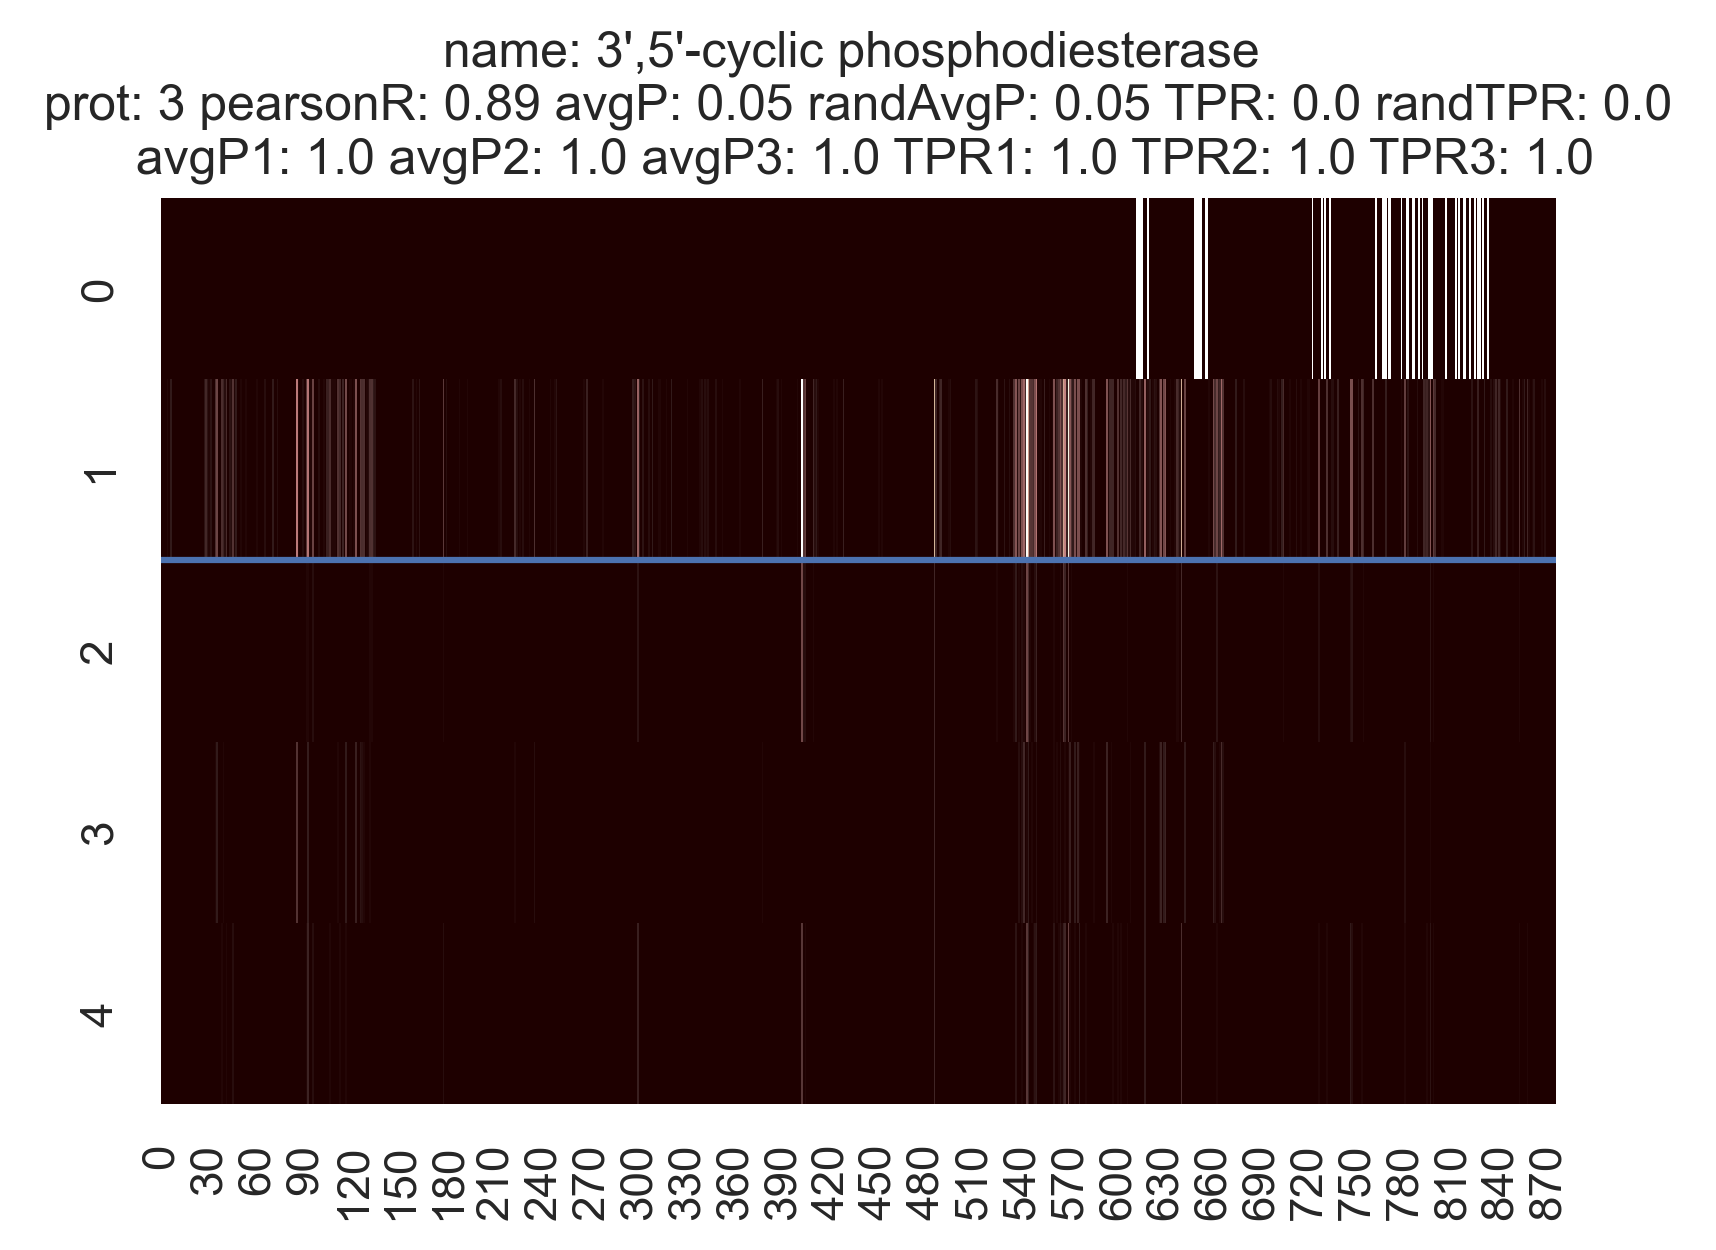

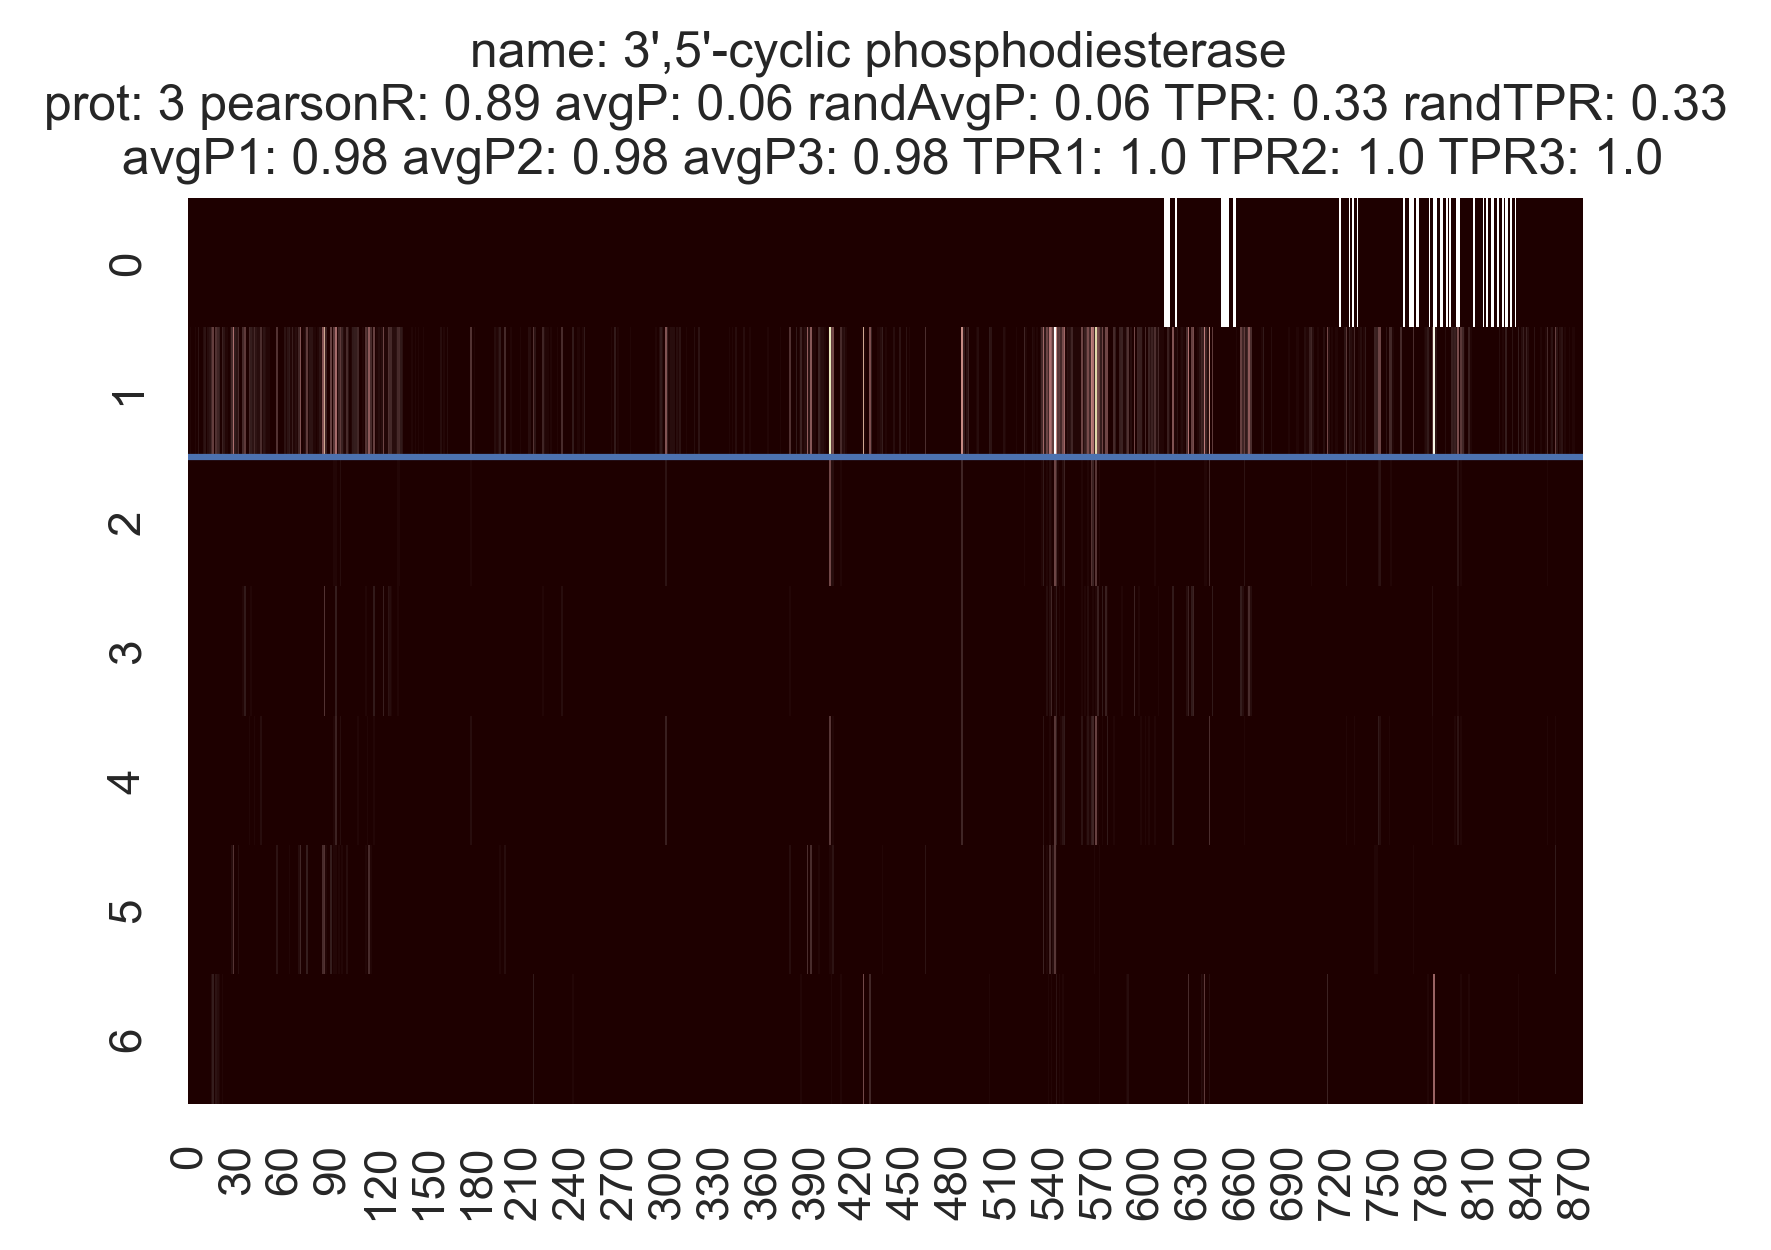

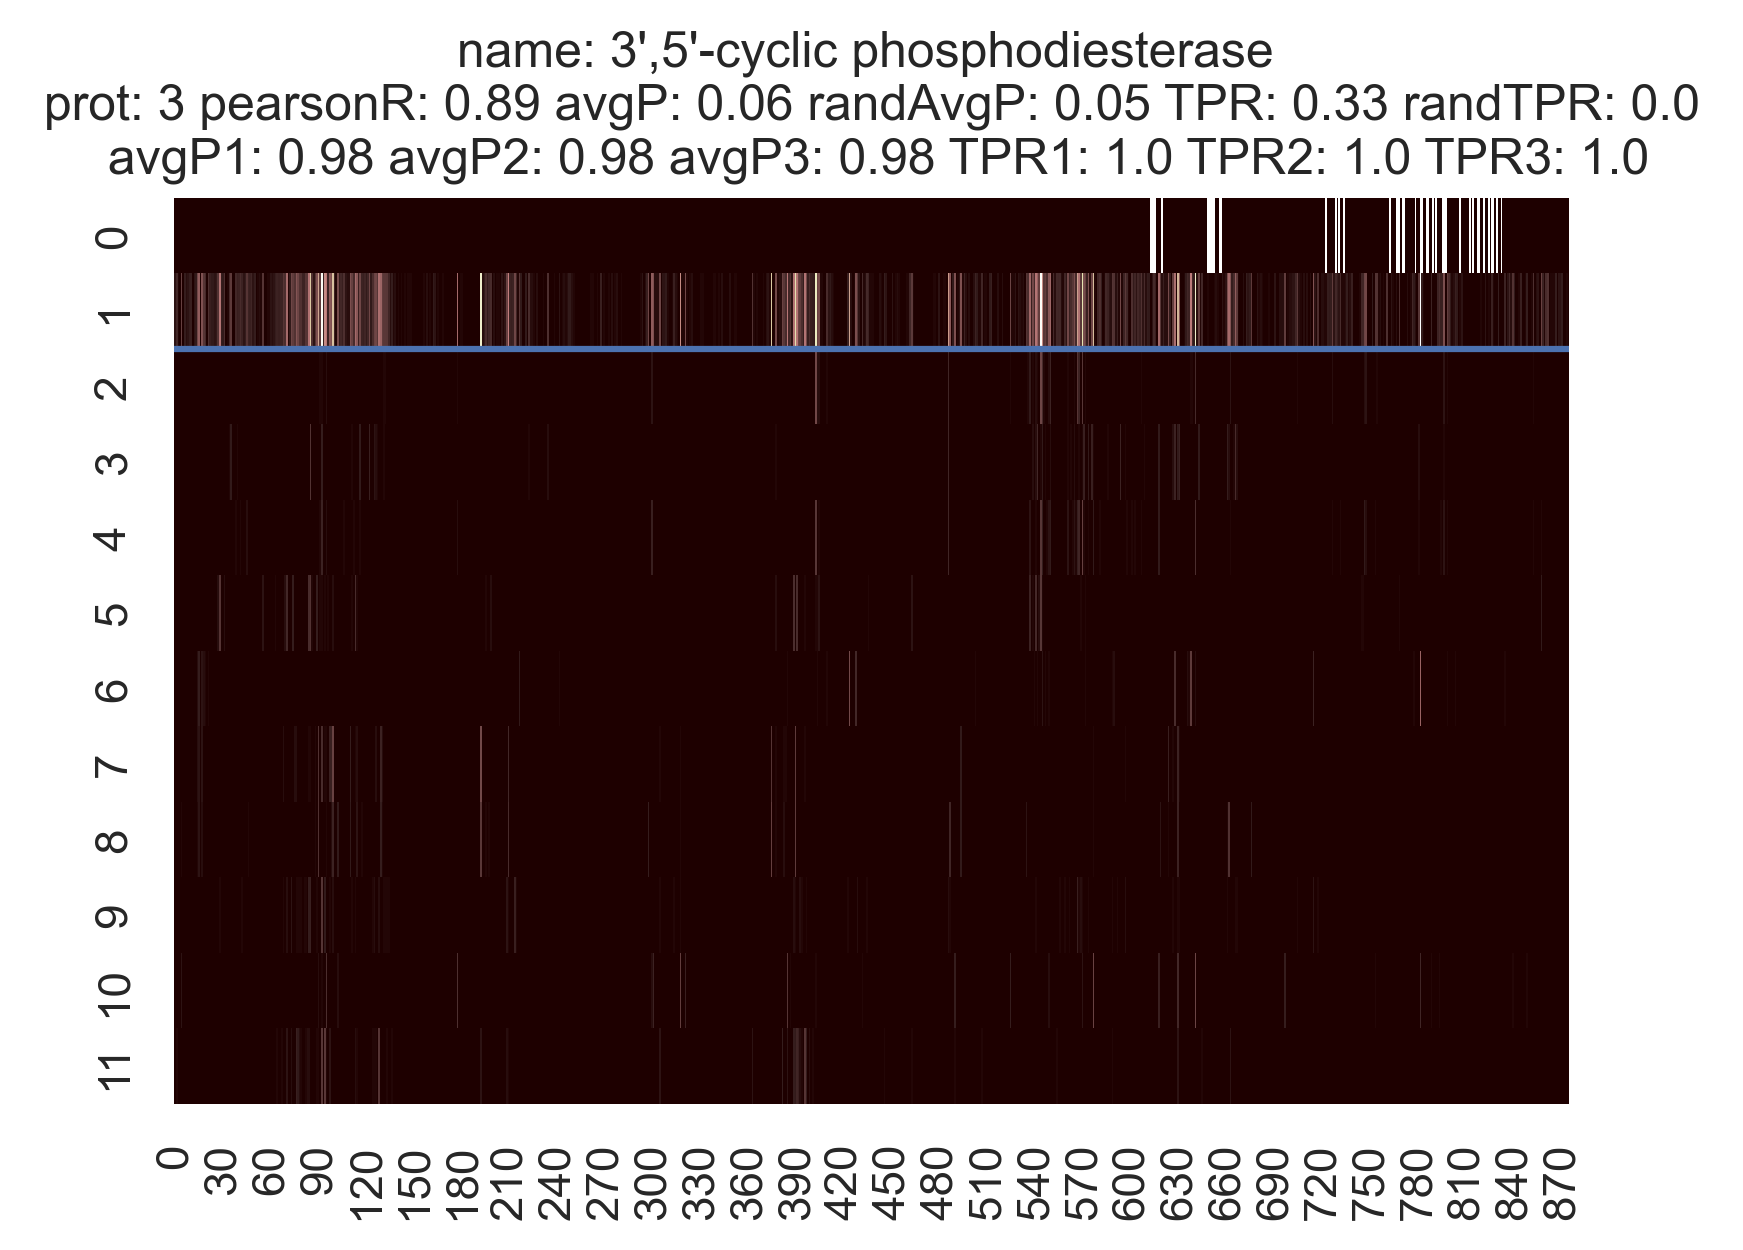

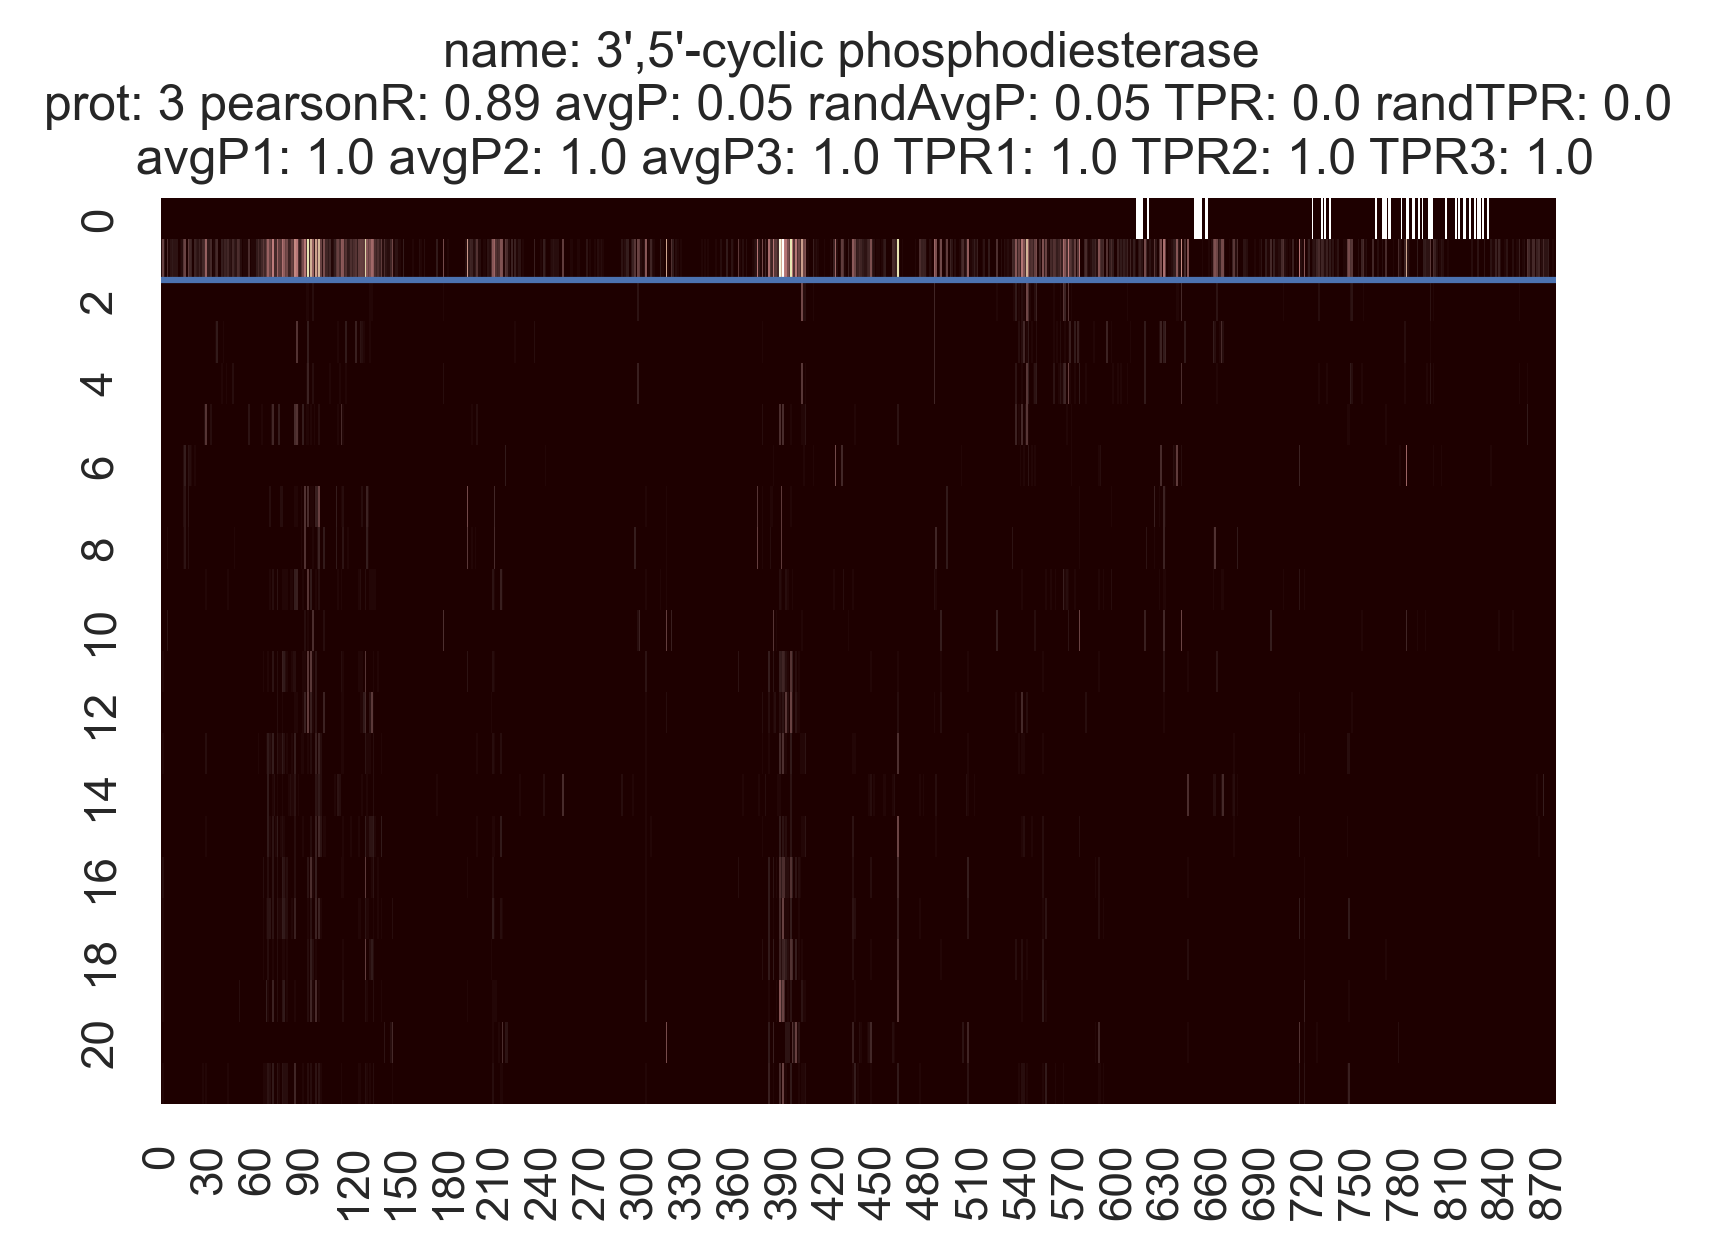

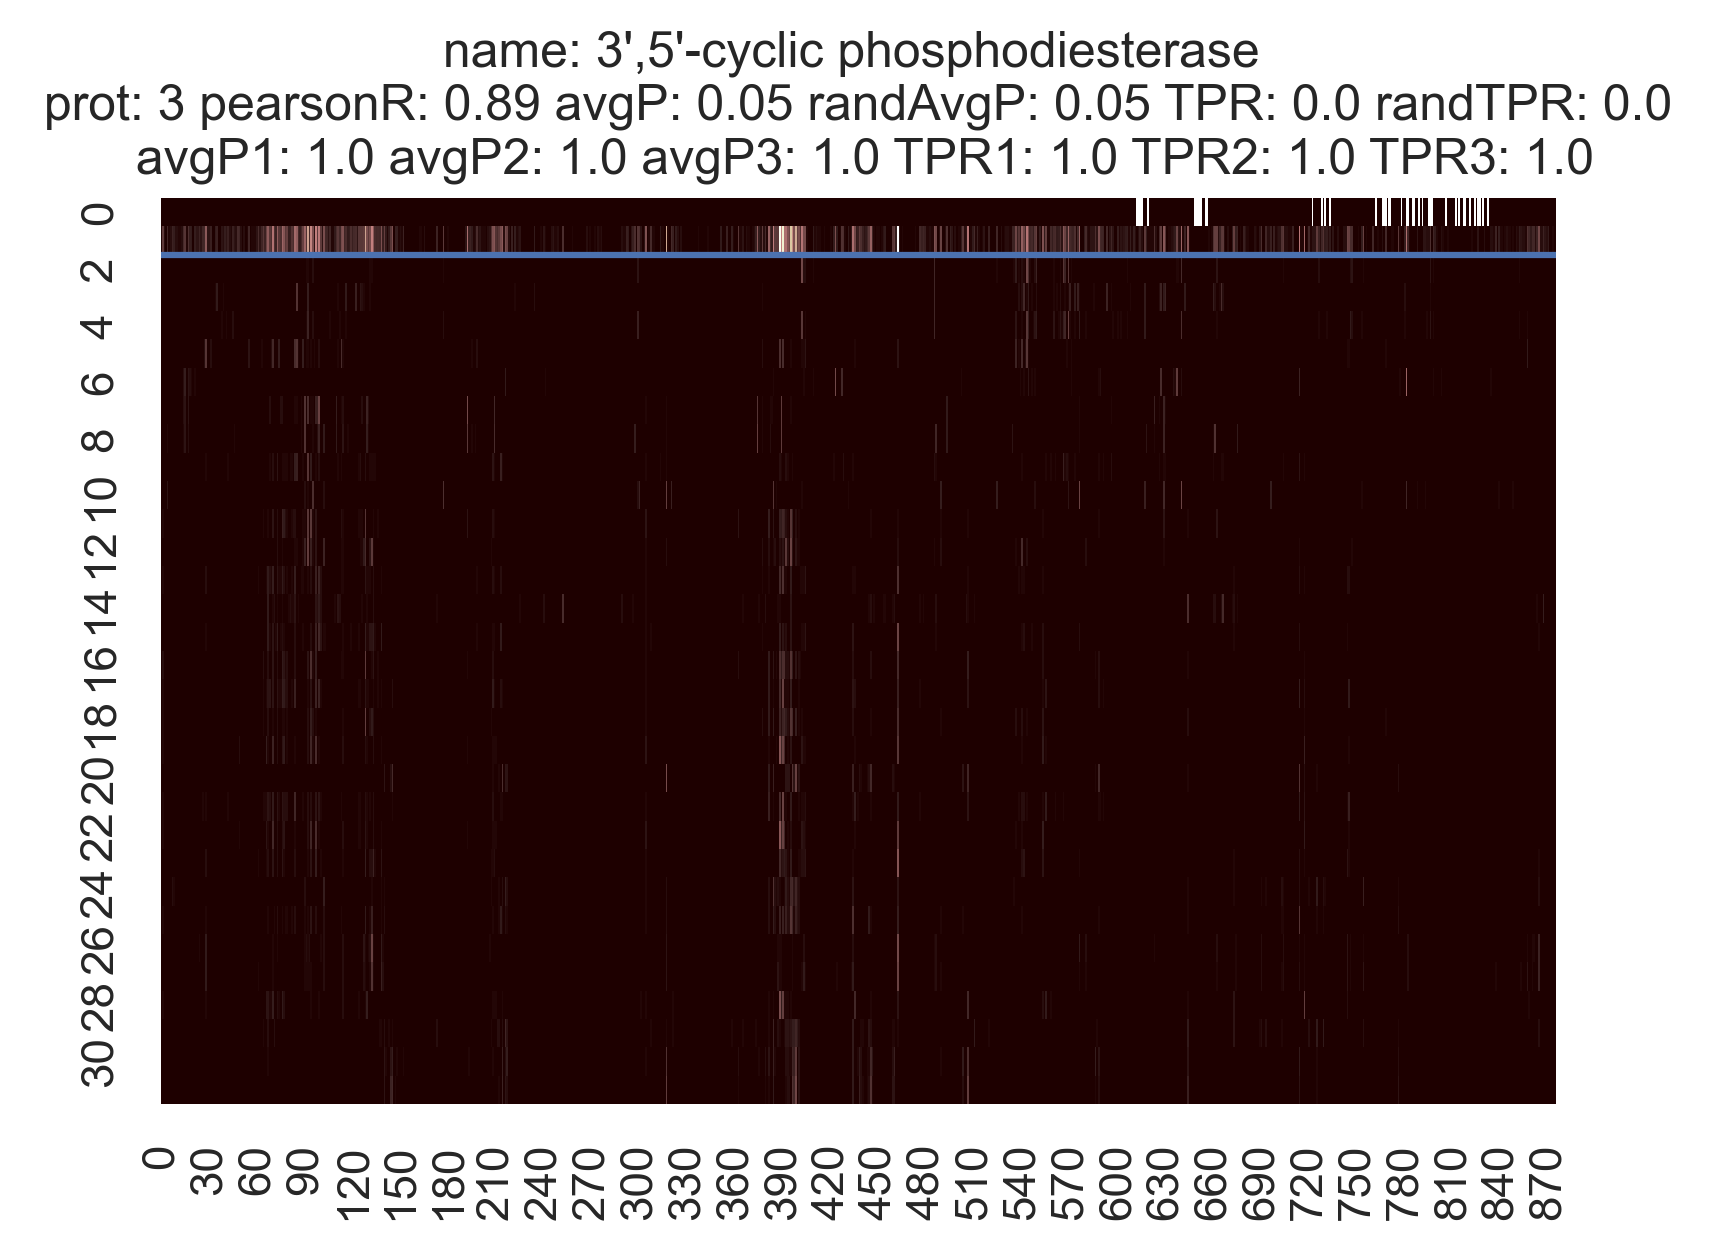

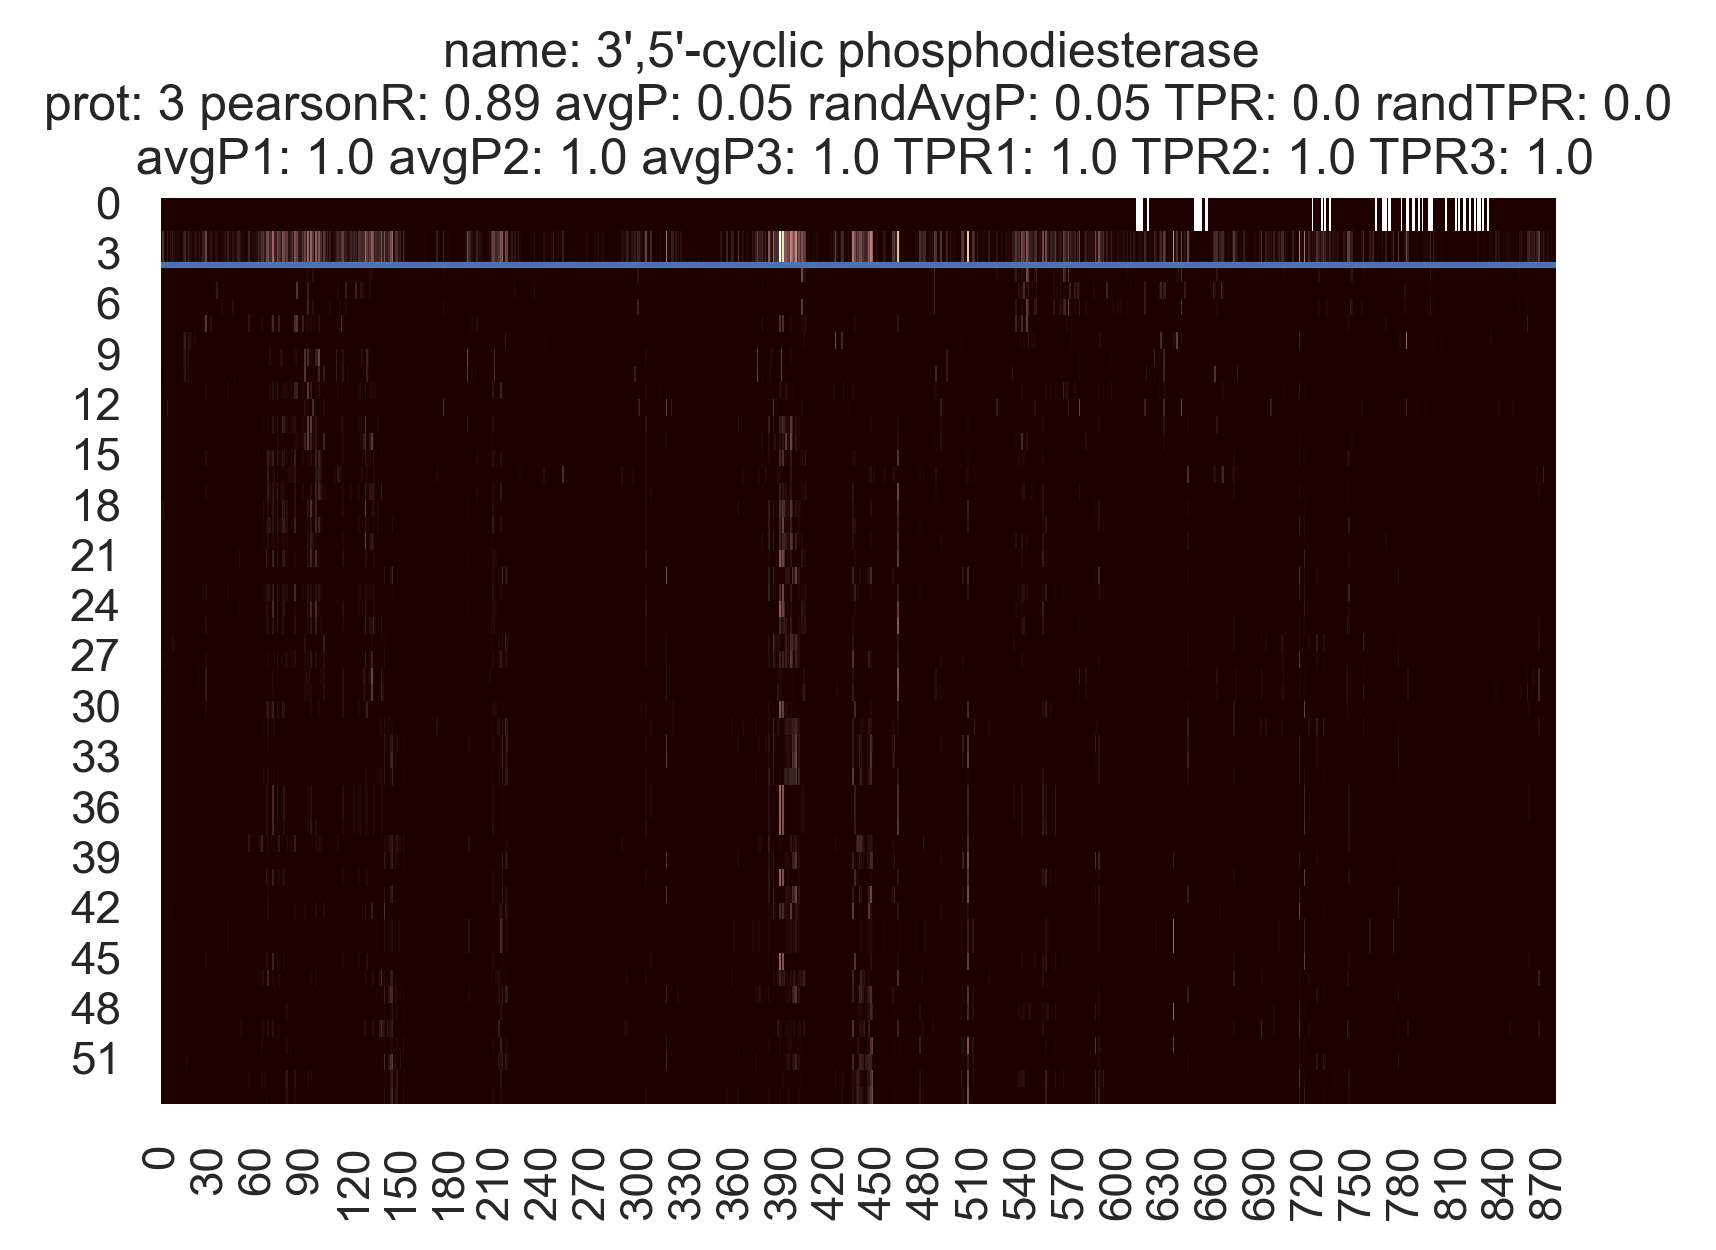

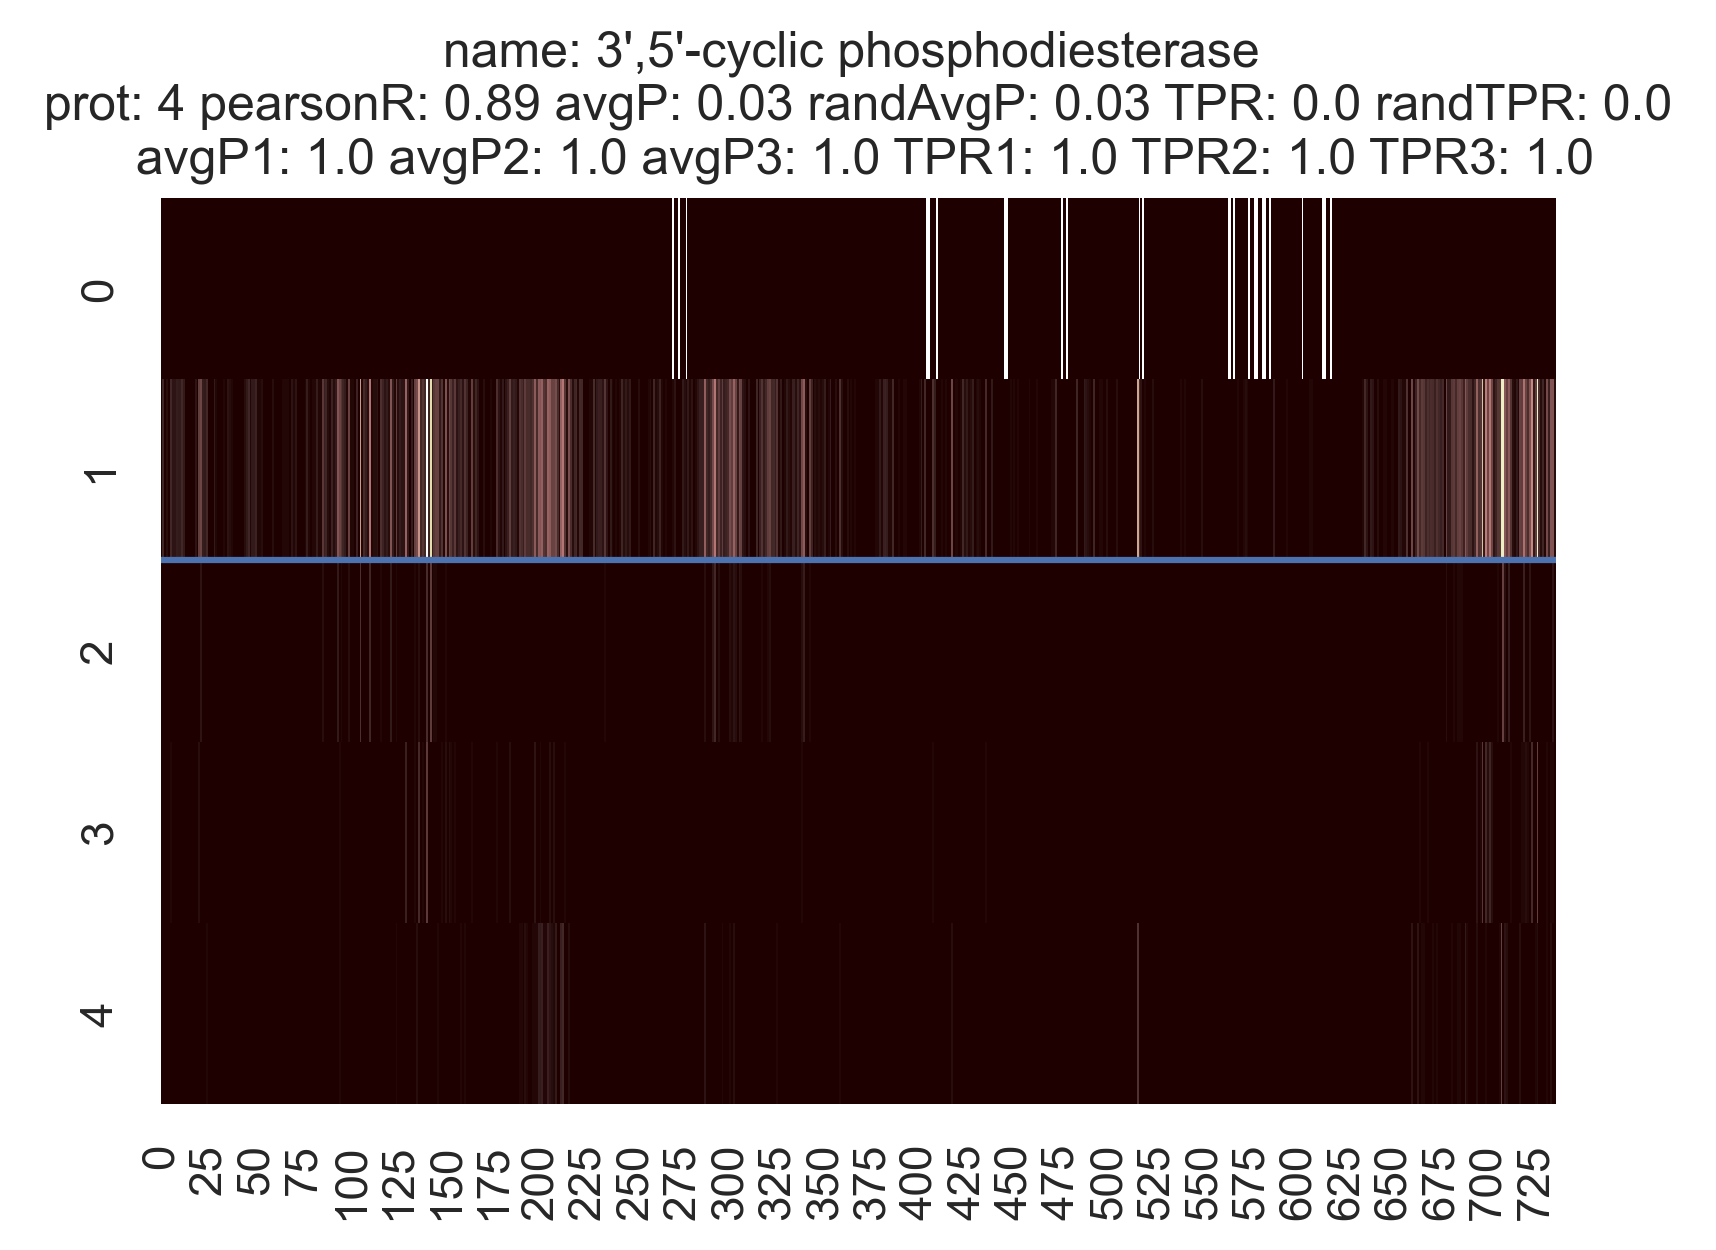

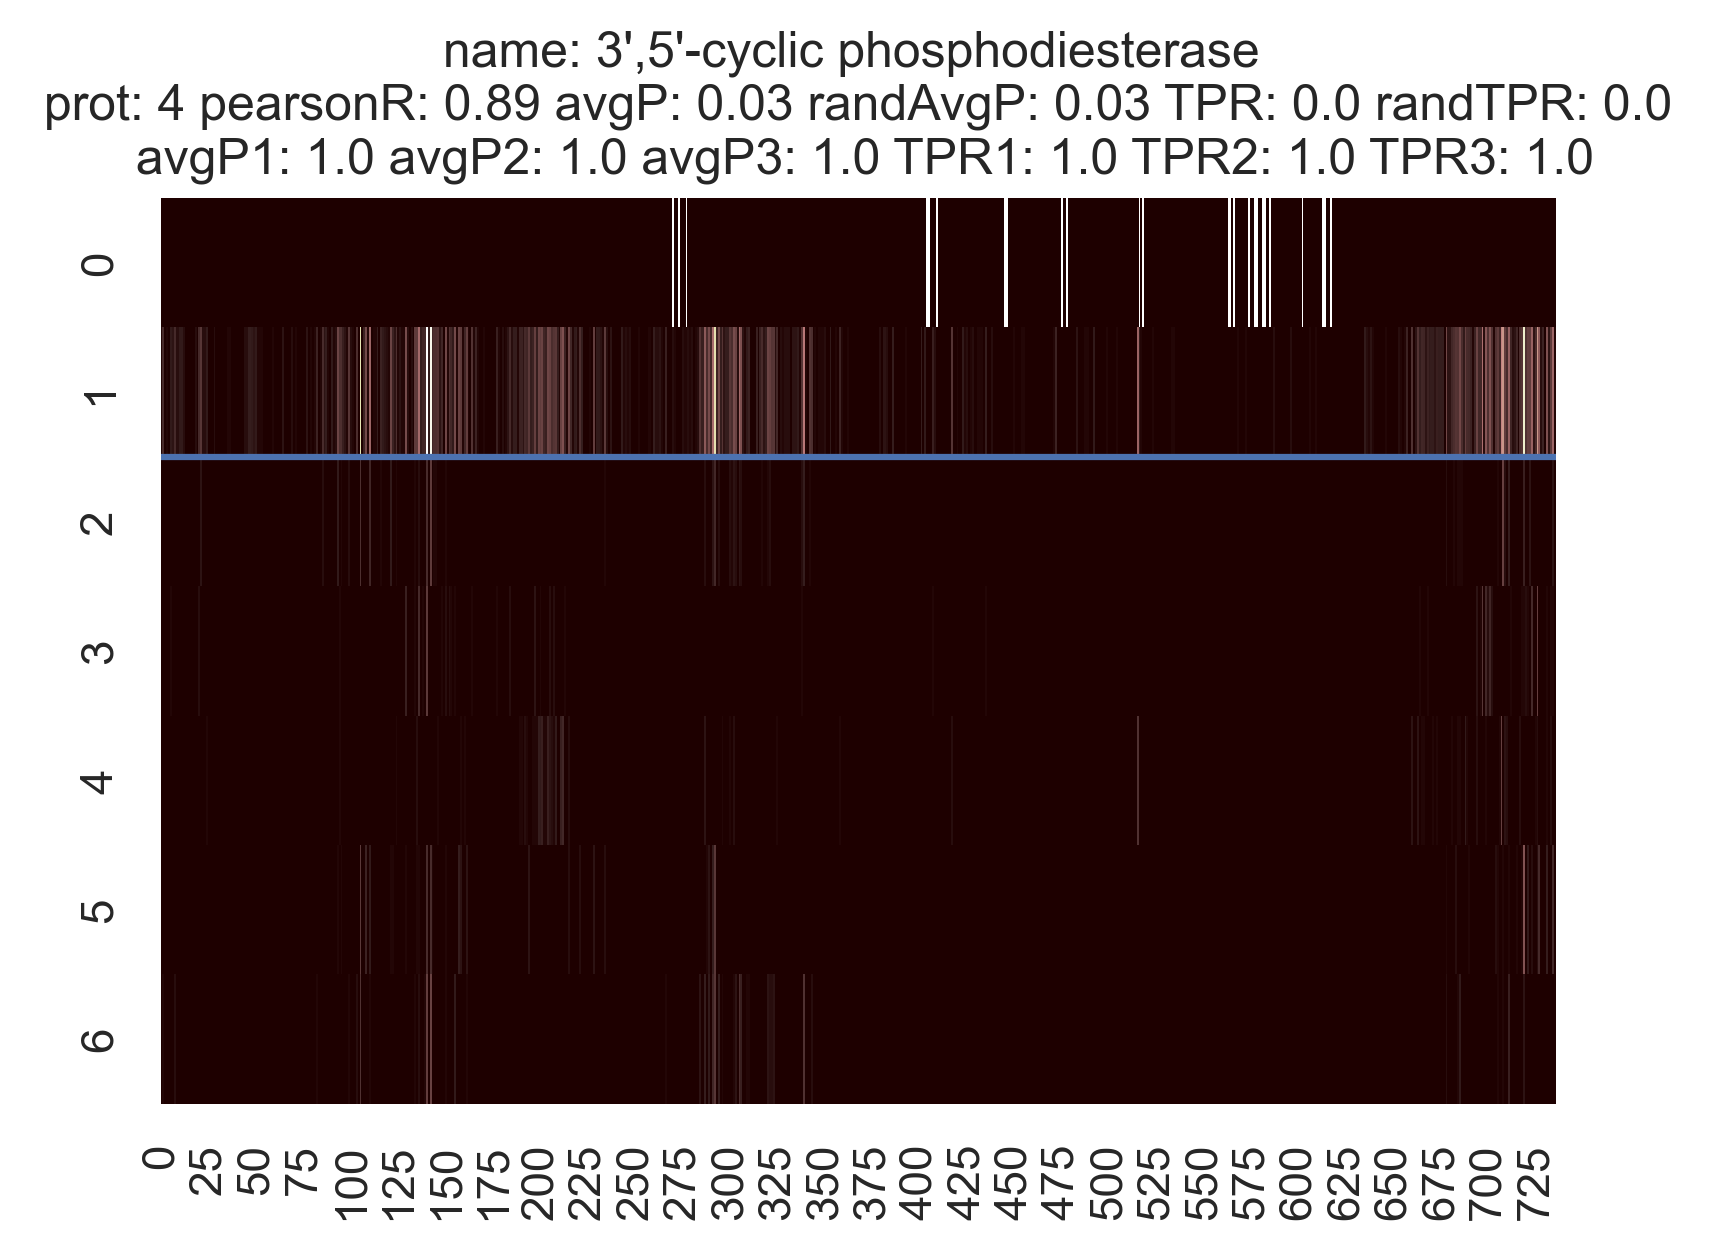

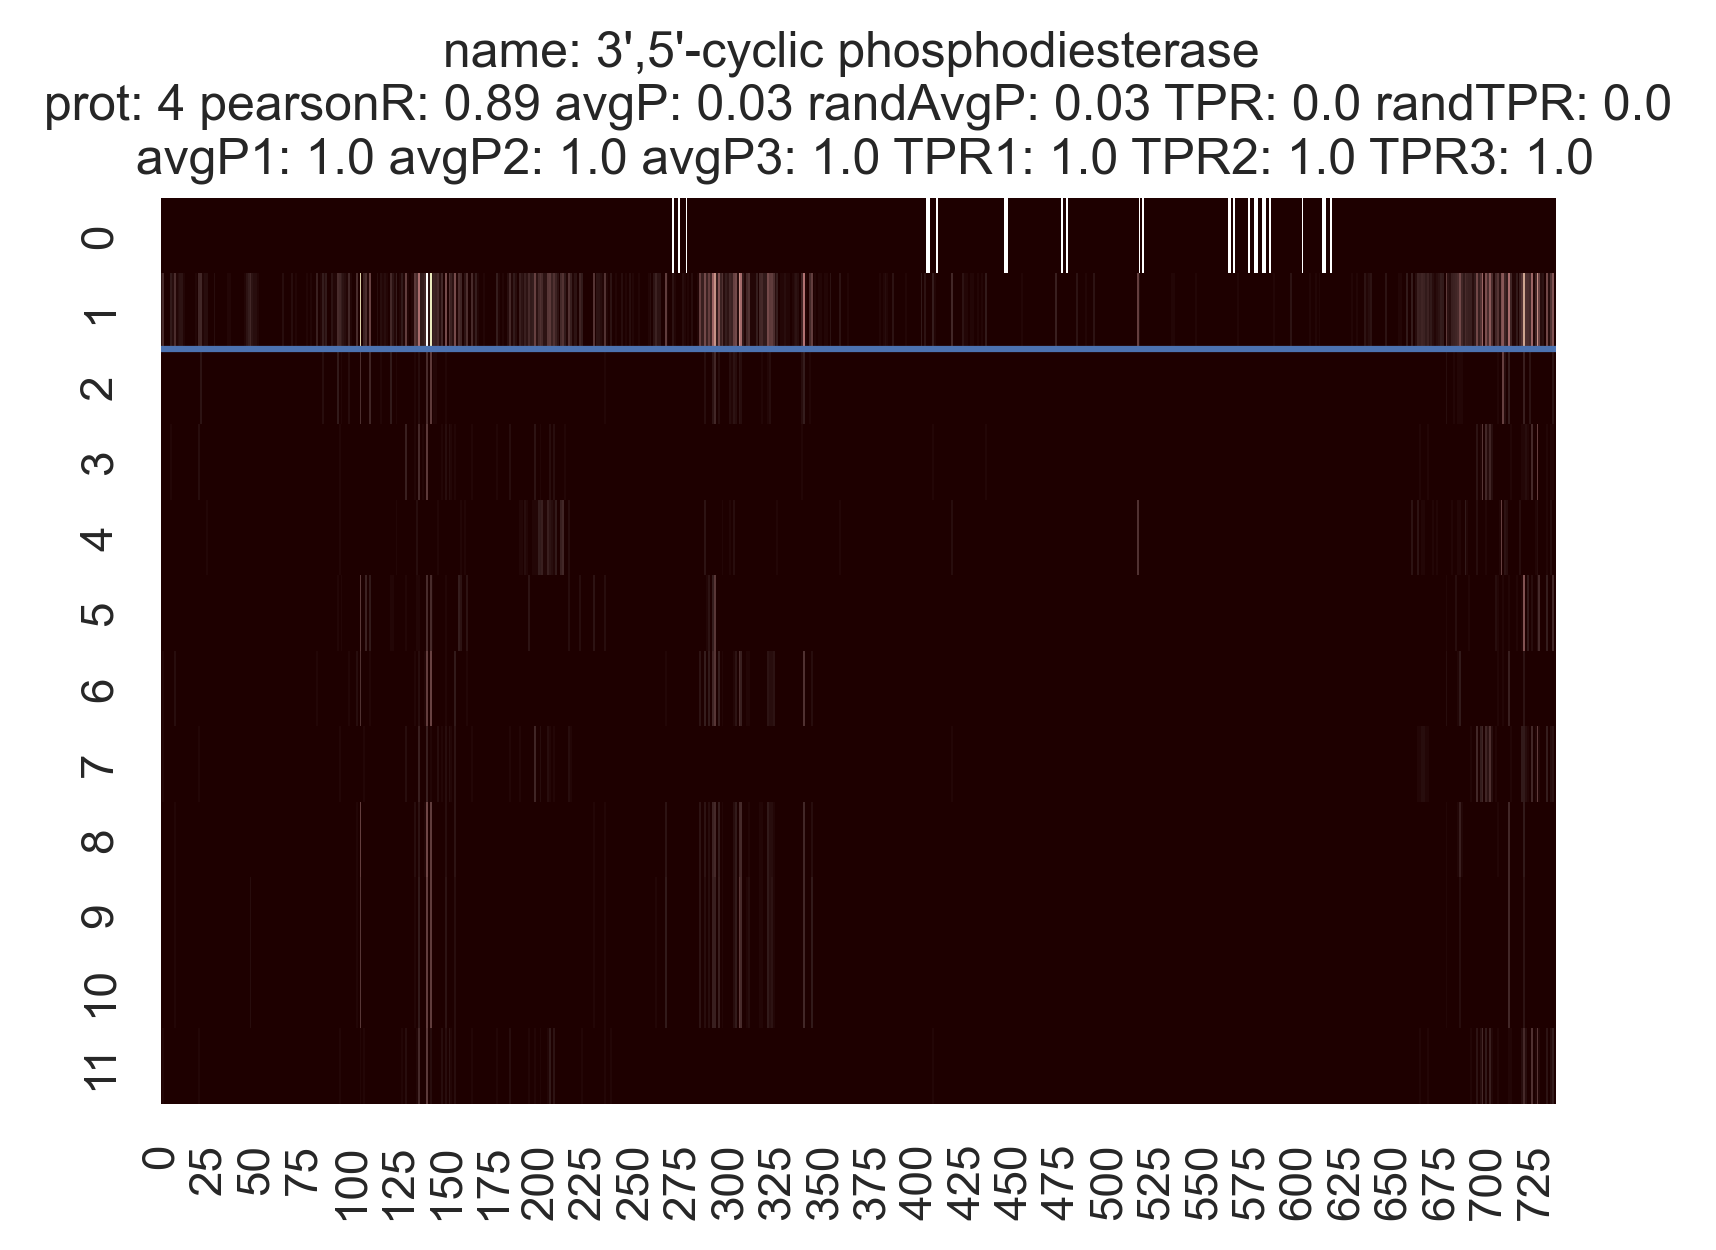

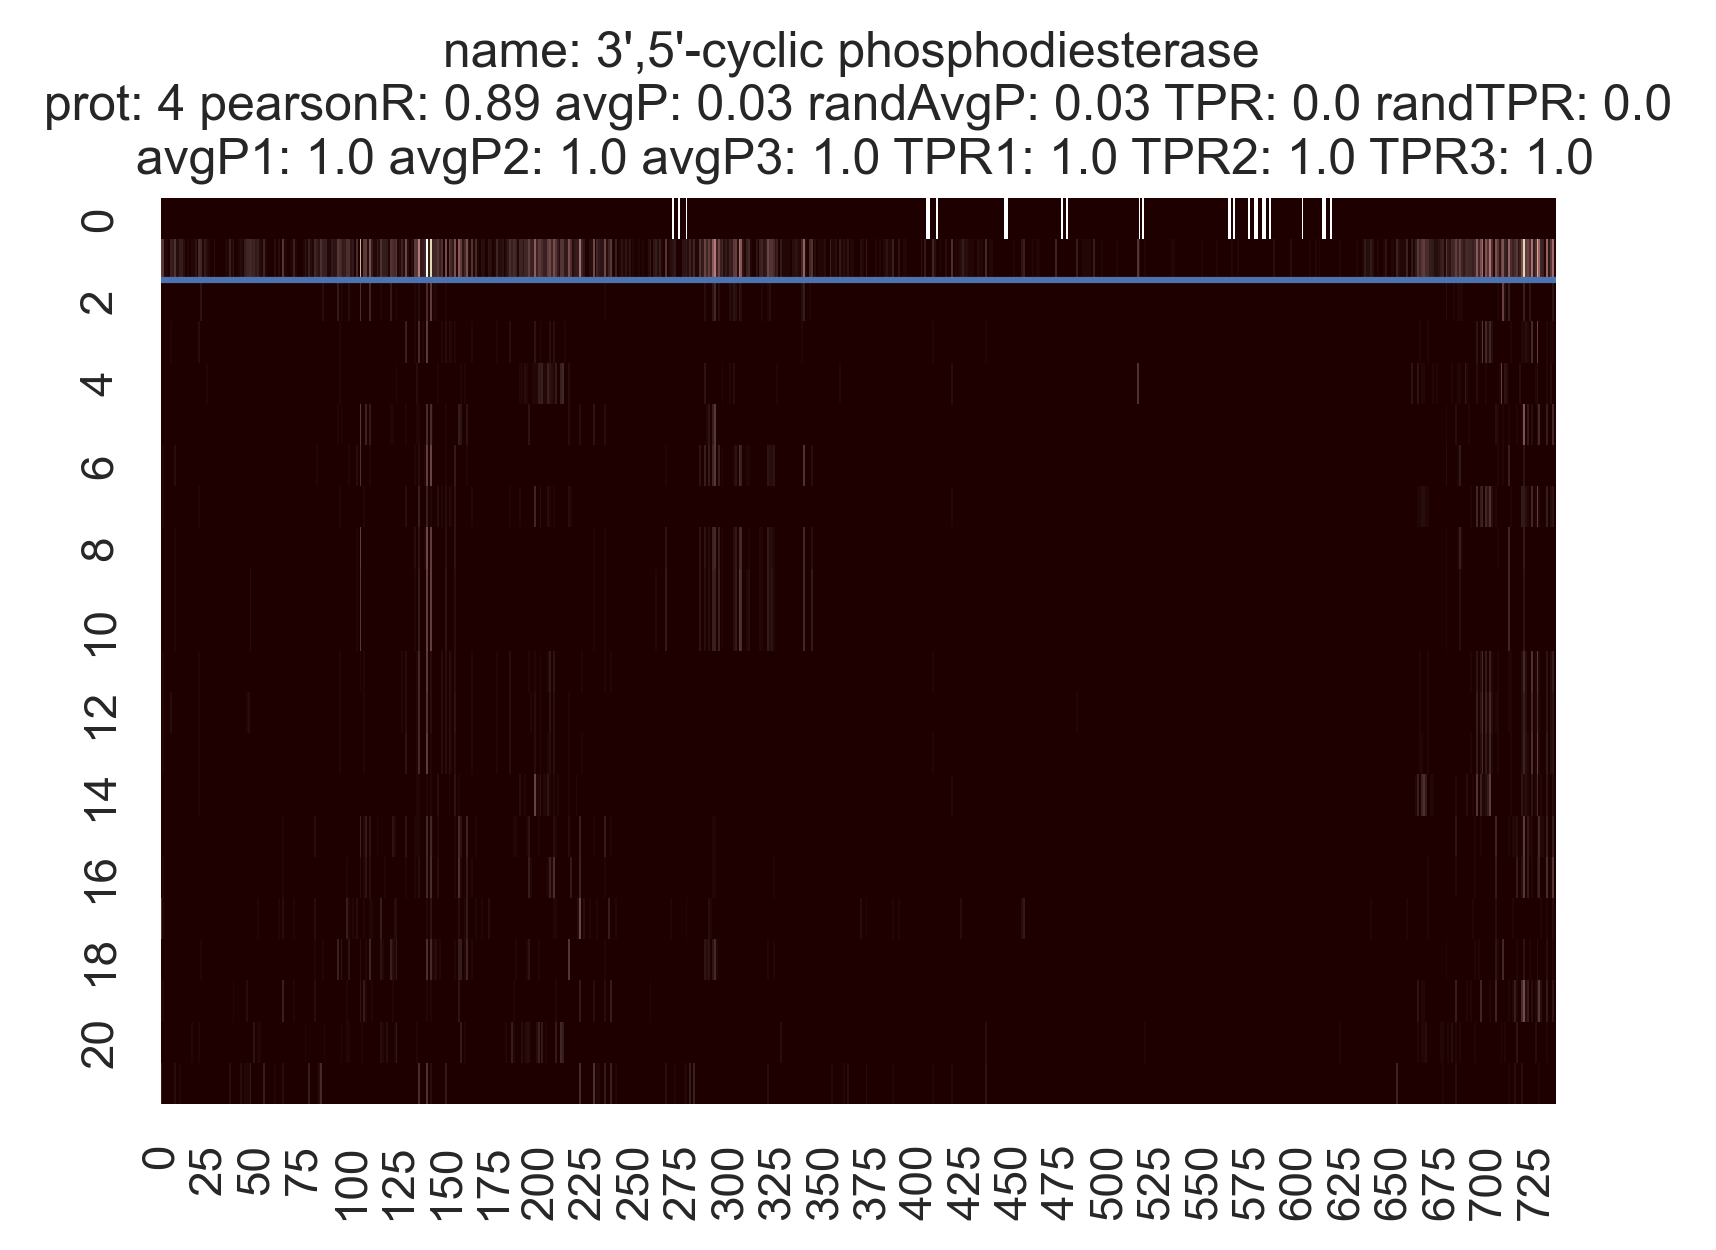

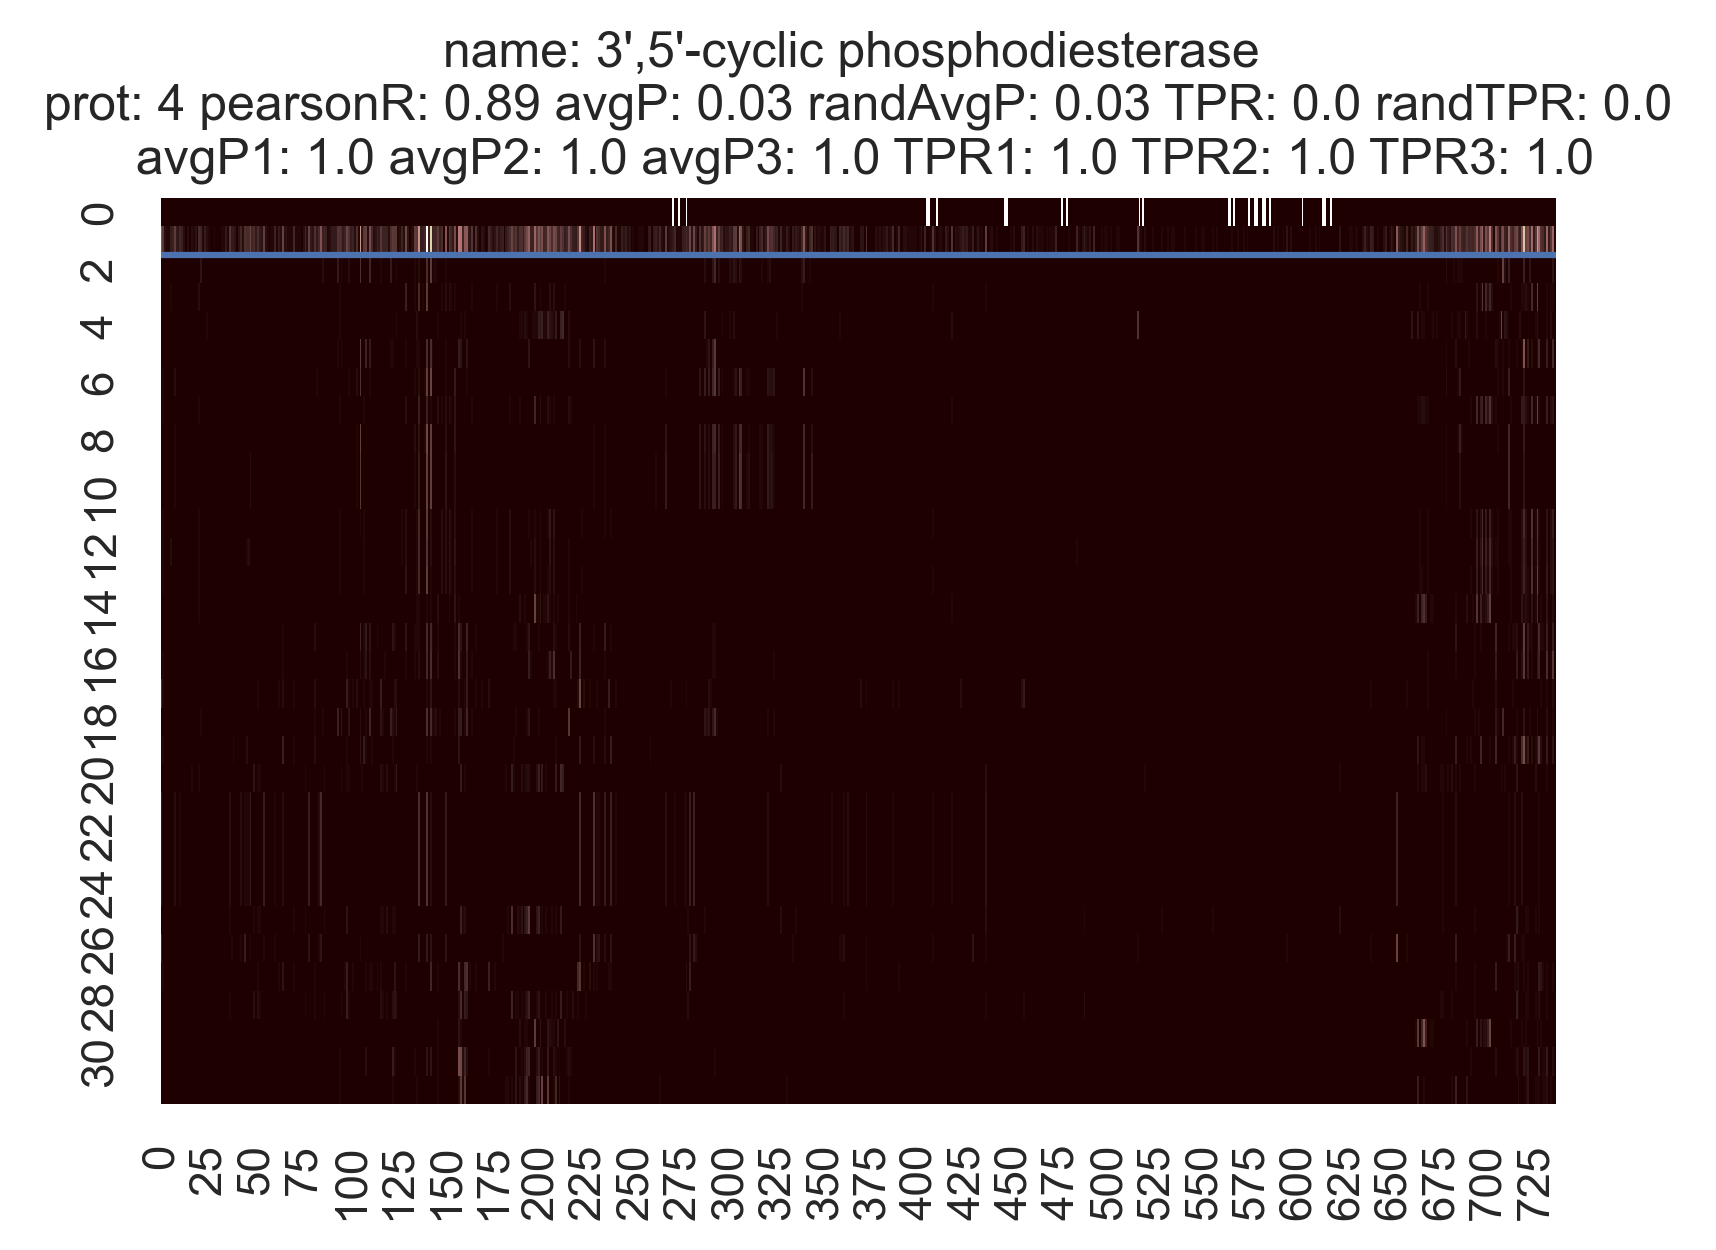

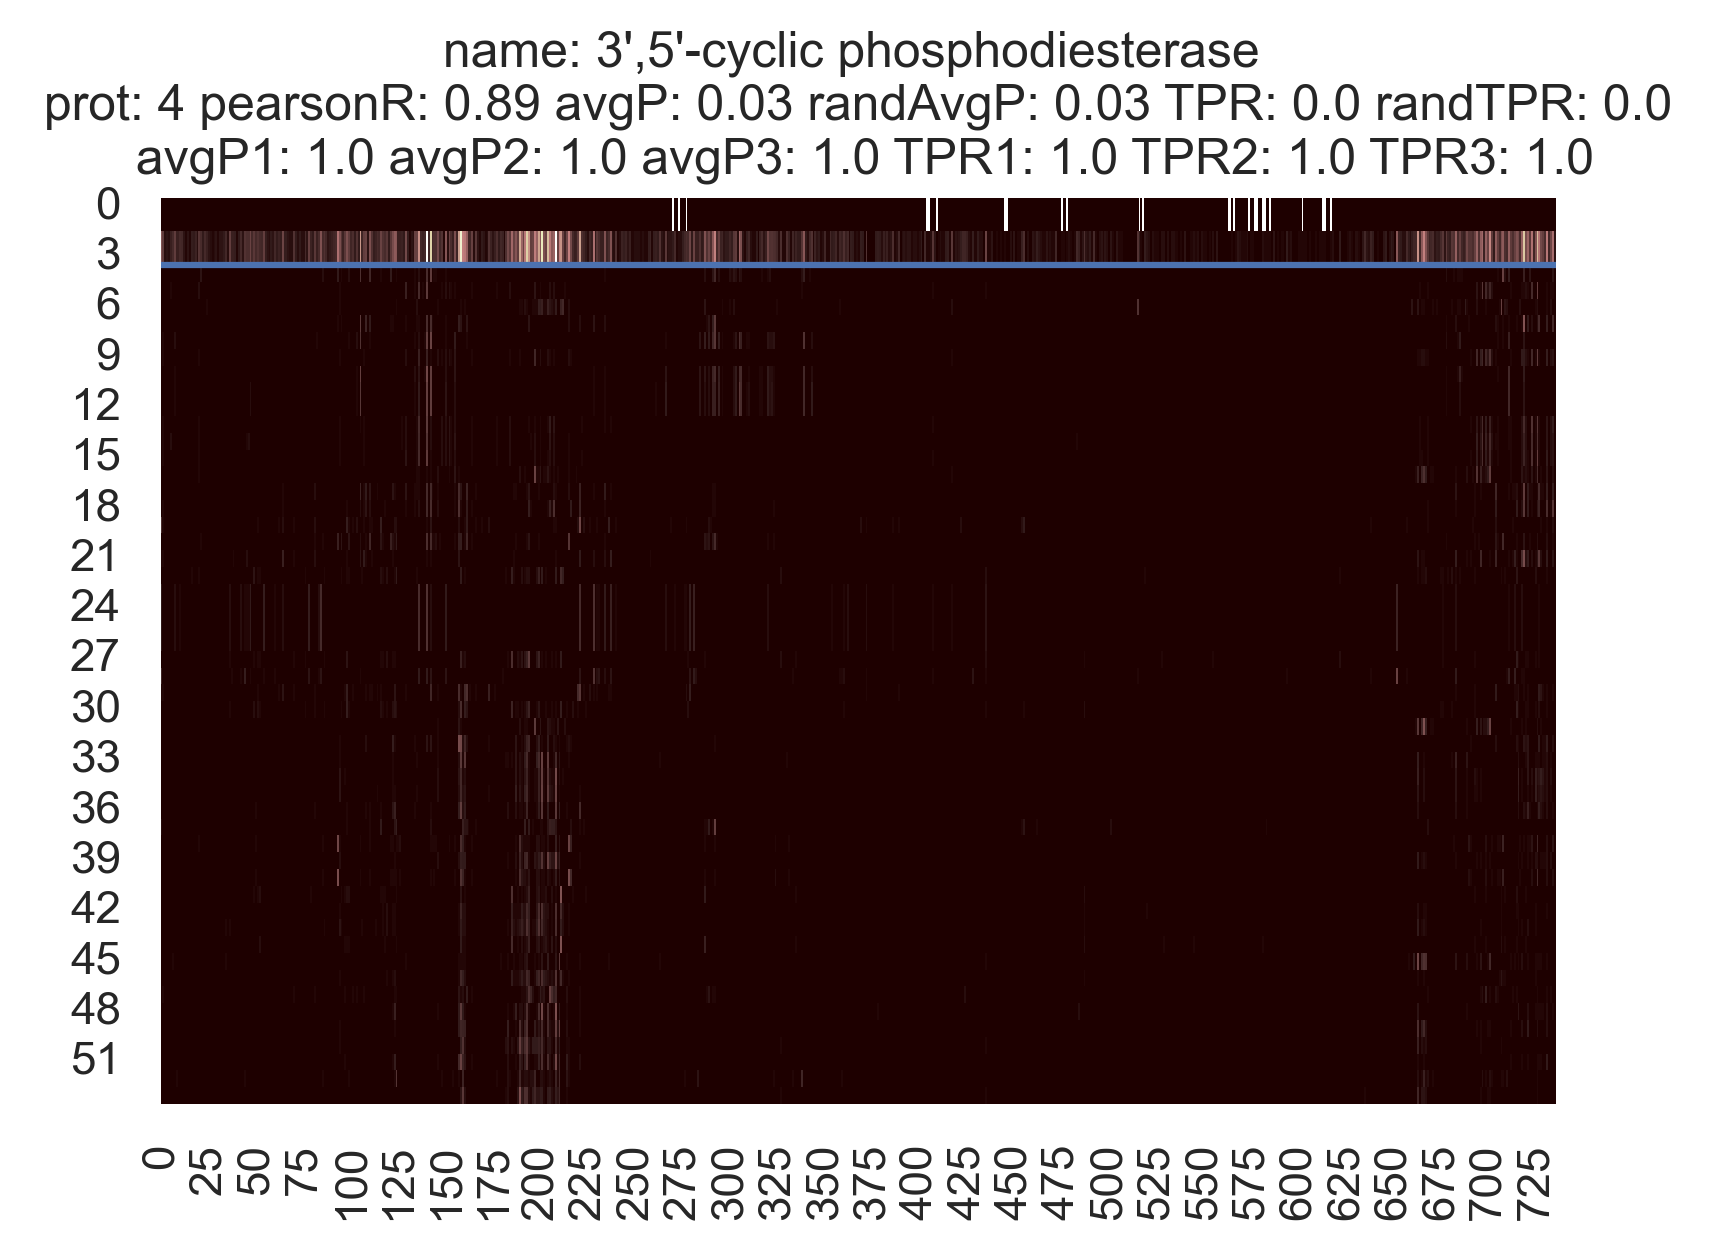

20it [03:09,  9.46s/it]
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "C:\Users\HannesStark\anaconda3\envs\geom\lib\site-packages\IPython\core\interactiveshell.py", line 3444, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "C:\Users\HANNES~1\AppData\Local\Temp/ipykernel_5452/2965385281.py", line 84, in <module>
    plt.show()
  File "C:\Users\HannesStark\anaconda3\envs\geom\lib\site-packages\matplotlib\pyplot.py", line 368, in show
    return _backend_mod.show(*args, **kwargs)
  File "C:\Users\HannesStark\anaconda3\envs\geom\lib\site-packages\matplotlib_inline\backend_inline.py", line 43, in show
    metadata=_fetch_figure_metadata(figure_manager.canvas.figure)
  File "C:\Users\HannesStark\anaconda3\envs\geom\lib\site-packages\IPython\core\display.py", line 320, in display
    format_dict, md_dict = format(obj, include=include, exclude=exclude)
  File "C:\Users\HannesStark\anaconda3\envs\geom\lib\site-packages\IPython\core\formatters.py", line 180, in format
    data = formatter(obj)
  F

TypeError: object of type 'NoneType' has no len()

In [8]:
from sklearn.metrics import roc_auc_score, average_precision_score, precision_score

print(pearsonRs)
for name, pearsonR in tqdm(zip(names, pearsonRs)):
    if pearsonR < 0.82: continue
    attention_weights_name = os.path.join(input_name, name, 'default/version_0/attn_weights_test_head_0.csv')

    csv_input = pd.read_csv(attention_weights_name)
    csv_input = csv_input.sort_values(by=['preds-0'], ascending=False)
    #csv_input = csv_input.drop(csv_input.index[range(10,len(csv_input))])
    query_sequences = list(set(csv_input['proteins_seq'].tolist()))
    for query_idx, query_sequence in enumerate(query_sequences):
        seq_info = binding_db.loc[binding_db['BindingDB Target Chain  Sequence'] == query_sequence]
        complex_ids_repeated = seq_info['PDB ID(s) for Ligand-Target Complex'].dropna().tolist()
        complex_ids = list(set([pdbid for repeated in complex_ids_repeated for pdbid in str(repeated).split(',')]))
        if complex_ids == []: continue
        target_ids_repeated = seq_info['PDB ID(s) of Target Chain'].dropna().tolist()
        target_ids = list(set([pdbid for repeated in target_ids_repeated for pdbid in str(repeated).split(',')]))
        comp_and_target_ids = list(set(complex_ids) | set(target_ids))
        has_target = anno.loc[anno['PDBID'].isin(comp_and_target_ids)]
        has_target_by_sequence = anno.loc[anno['sequence'].isin(query_sequences)]
        sequences = has_target['sequence'].tolist()

        all_alignments = []
        for sequence in sequences:
            try:
                alignments = pairwise2.align.globalxx(query_sequence, sequence)
                all_alignments.append(alignments[0])
            except:
                continue
        if all_alignments == []: continue

        scores = [alignment.score for alignment in all_alignments]
        top3_misalginment_scores = sorted(list(set(-np.array(scores) + len(query_sequence))))[:3]
        misaligned_allowance = top3_misalginment_scores[-1]

        alignment_ratio = 0.01  # This is the percentage of a sequence that needs to be aligned to the original sequence to include its binding sites

        row = csv_input.loc[csv_input['proteins_seq'] == query_sequence]

        for top_k in [3, 5, 10, 20, 30, 50]:
            attention = np.array(row.values.tolist())
            attention = attention[:, 7:len(query_sequence) + 7].astype(float)[:top_k]
            attention_mean = attention.mean(axis=0)
            attention_mean = attention_mean / attention_mean.max()
            #attention_mean = attention_mean > 0.3
            #softmax_mean = np.exp(attention_mean) / sum(np.exp(attention_mean))
            #attention_mean = attention_mean / attention_mean.sum()
            top_prediction_idx = attention_mean.argsort()[-3:][::-1]
            top_predictions = np.zeros_like(attention_mean)
            top_predictions[np.array(top_prediction_idx)] = 1

            repeats = int(np.ceil(attention.shape[0] / 30))
            is_binding_site = binding_site_annotation(all_alignments, has_target_frame=has_target,
                                                      input_sequence=query_sequence)

            roc_auc = roc_auc_score(is_binding_site, top_predictions)
            avgP = average_precision_score(is_binding_site, top_predictions)
            true_pos_rate = precision_score(is_binding_site, top_predictions)
            random_idx = np.random.randint(0, len(is_binding_site), size=3)
            random = np.zeros_like(is_binding_site)
            random[random_idx] = 1
            randomAvgP = average_precision_score(is_binding_site, random)
            random_true_positive_rate = precision_score(is_binding_site, random)
            is_binding_site = is_binding_site.astype(int)
            top_predictions = top_predictions.astype(int)
            preds_dist1 = realign(is_binding_site, top_predictions, dist=1).astype(int)
            preds_dist2 = realign(is_binding_site, top_predictions, dist=2).astype(int)
            preds_dist3 = realign(is_binding_site, top_predictions, dist=3).astype(int)
            avgP1 = average_precision_score(is_binding_site, preds_dist1)
            avgP2 = average_precision_score(is_binding_site, preds_dist2)
            avgP3 = average_precision_score(is_binding_site, preds_dist3)
            true_pos_rate1 = precision_score(is_binding_site, preds_dist1)
            true_pos_rate2 = precision_score(is_binding_site, preds_dist2)
            true_pos_rate3 = precision_score(is_binding_site, preds_dist3)
            visualization = np.concatenate(
                [np.tile(is_binding_site, (repeats, 1)), np.tile(attention_mean, (repeats, 1)), attention], axis=0)
            ax = sn.heatmap(visualization, annot=False, cmap='pink', cbar=False)
            plt.title(
                f'name: {name} \n prot: {query_idx} pearsonR: {round(pearsonR, 2)} avgP: {round(avgP, 2)} randAvgP: {round(randomAvgP, 2)} TPR: {round(true_pos_rate, 2)} randTPR: {round(random_true_positive_rate, 2)} \n avgP1: {round(avgP1,2)} avgP2: {round(avgP2,2)} avgP3: {round(avgP3,2)} TPR1: {round(true_pos_rate1,2)} TPR2: {round(true_pos_rate2,2)} TPR3: {round(true_pos_rate3,2)} \n avgP1: {round(avgP1,2)} avgP2: {round(avgP2,2)} avgP3: {round(avgP3,2)} TPR1: {round(true_pos_rate1,2)} TPR2: {round(true_pos_rate2,2)} TPR3: {round(true_pos_rate3,2)}')
            ax.hlines([repeats * 2], *ax.get_xlim())
            plt.savefig(
                f'{output_name}/{name}_prot{query_idx}_top{top_k}_pearsonR{round(pearsonR, 2)}_avgP{round(avgP, 2)}_tpr{round(true_pos_rate, 2)}.jpg')
            plt.show()
            plt.clf()
            #break